## DGE testing using diffxpy: for all coarse-grained cell types all conditions vs. CC

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import sparse

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3               
sc.logging.print_version_and_date()
sc.logging.print_header()

# making sure plots & clusters are reproducible
np.random.seed(42)

# custom functions
import sc_toolbox as sct
import re

# import diffxpy for DE testing
import diffxpy.api as de
import warnings
warnings.filterwarnings("ignore")

Running Scanpy 1.8.1, on 2022-01-13 18:19.


/home/niklas/miniconda3/envs/niche_fibrosis_env_diffxpy/lib/python3.8/site-packages/numba/core/cpu.py:97: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ModuleNotFoundError(No module named 'numba.targets')'.
  numba.core.entrypoints.init_all()
2022-01-13 18:19:35.256166: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-13 18:19:35.256190: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.19.5 scipy==1.7.1 pandas==1.3.3 scikit-learn==1.0.1 statsmodels==0.12.2 pynndescent==0.5.4


In [2]:
## path variable
adata_dir = '/home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/211201_PCLS_human_ASK_joint_annotated_NIKLAS.h5ad'
results_dir = '/home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/'

In [3]:
## load data
adata = sc.read(adata_dir)

In [4]:
adata

AnnData object with n_obs × n_vars = 71055 × 17343
    obs: 'condition', 'modality', 'name', 'patient', 'timepoint', 'treatment', 'identifier', 'n_counts', 'n_genes', 'percent_mito', 'QC_group', 'doublet_scores', 'size_factors', 'leiden_1', 'leiden_2', 'cell_type', 'cell_type_group'
    var: 'n_cells', 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'cell_type_colors', 'cell_type_group_colors', 'condition_colors', 'dendrogram_cell_type', 'hvg', 'identifier_colors', 'leiden', 'leiden_1_colors', 'leiden_2_colors', 'name_colors', 'neighbors', 'patient_colors', 'pca', 'rank_genes_groups', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'unsouped_counts'
    obsp: 'connectivities', 'distances'

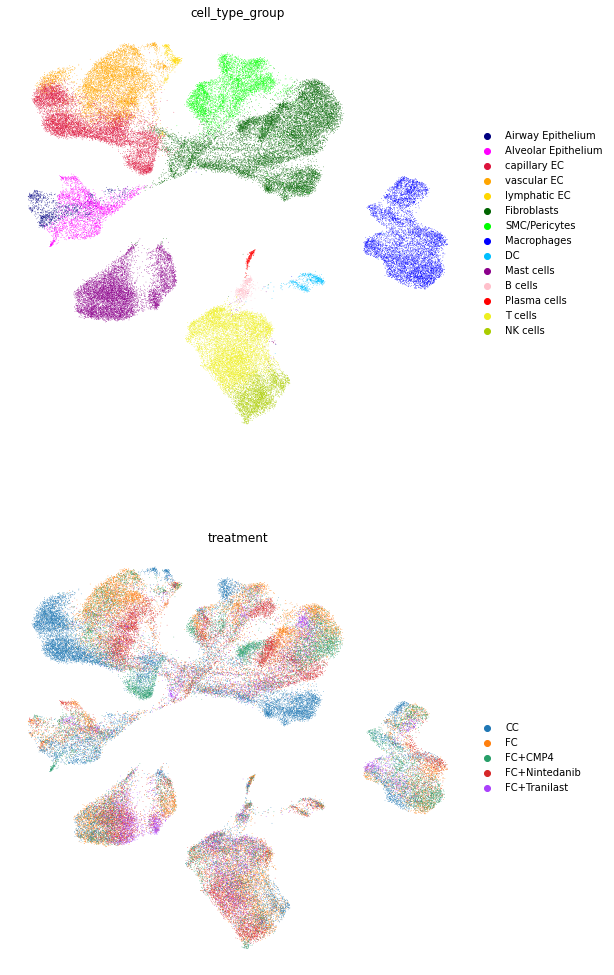

In [5]:
## plot UMAP
rcParams['figure.figsize'] = 8, 8
sc.pl.umap(adata, color = ['cell_type_group','treatment'], ncols = 1, frameon = False)

### Run DGE testing for all coarse graind cell type: Fibrotic Cocktail (FC) vs Control Cocktail (CC) after 6 days

In [6]:
## don't include Tranilast
adata = adata[-adata.obs.treatment.isin(['FC+Tranilast'])].copy()

In [7]:
## Recommendation from Malte, scale the total number of counts beforehand
adata.obs['n_counts_scaled'] = adata.obs['n_counts']/adata.obs['n_counts'].mean()

In [8]:
adata.obs['treatment'].value_counts()

FC               19029
CC               17090
FC+Nintedanib    14824
FC+CMP4          12638
Name: treatment, dtype: int64

In [9]:
## get an overview of the cell type distribution across treatments
pd.crosstab(adata.obs['cell_type_group'],adata.obs['treatment'])

treatment              CC    FC  FC+CMP4  FC+Nintedanib
cell_type_group                                        
Airway Epithelium     403   405      195            166
Alveolar Epithelium  1136   797      604            329
capillary EC         5476   658     1375            898
vascular EC           827  3149     1272           1664
lymphatic EC          154   154      115            104
Fibroblasts          3953  3311     3079           3401
SMC/Pericytes         975  1482      918           1358
Macrophages          1540  1894     2179            832
DC                     72   218      102            159
Mast cells            875  2660     1064           2369
B cells                89   114      110             92
Plasma cells           54    85       48             39
T cells               988  2898     1248           2522
NK cells              548  1204      329            891

In [10]:
cell_type_names = list(adata.obs.cell_type_group.cat.categories)
cell_type_names

['Airway Epithelium',
 'Alveolar Epithelium',
 'capillary EC',
 'vascular EC',
 'lymphatic EC',
 'Fibroblasts',
 'SMC/Pericytes',
 'Macrophages',
 'DC',
 'Mast cells',
 'B cells',
 'Plasma cells',
 'T cells',
 'NK cells']

In [11]:
## check N cells per type labels
adata.obs.cell_type_group.value_counts()

Fibroblasts            13744
capillary EC            8407
T cells                 7656
Mast cells              6968
vascular EC             6912
Macrophages             6445
SMC/Pericytes           4733
NK cells                2972
Alveolar Epithelium     2866
Airway Epithelium       1169
DC                       551
lymphatic EC             527
B cells                  405
Plasma cells             226
Name: cell_type_group, dtype: int64

In [12]:
adata.obs.treatment.cat.categories

Index(['CC', 'FC', 'FC+CMP4', 'FC+Nintedanib'], dtype='object')

In [13]:
## check treatment labels
adata.obs.treatment.cat.categories
treatment_groups = adata.obs.treatment.cat.categories[1:4]
treatment_groups

Index(['FC', 'FC+CMP4', 'FC+Nintedanib'], dtype='object')

### Generate raw count object

In [14]:
adata.obs['grouping'] = adata.obs['treatment']



Performing DGE testing: Airway Epithelium FC vs. CC 


filtered out 4546 genes that are detected in less than 5 cells


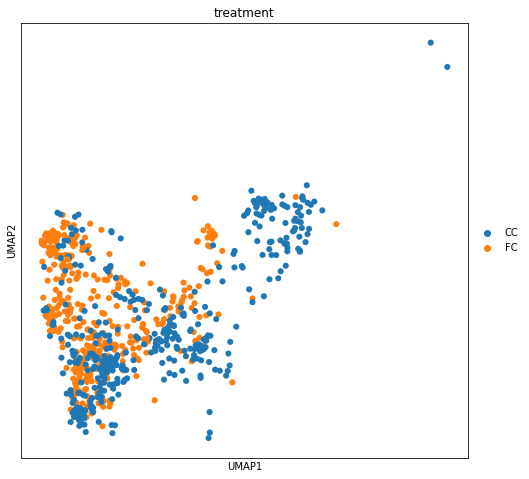

***DGE testing set-up: Airway Epithelium FC vs. CC***

N cells (total):
808

N cells (per condition):
FC    405
CC    403
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 18:20:11
training location model: True
training scale model: True
iter   0: ll=37531755.671771
caught 89 linalg singular matrix errors
iter   1: ll=36648344.781499, converged: 0.00% (loc: 18.55%, scale update: False), in 1.87sec
iter   2: ll=36369828.632065, converged: 0.00% (loc: 18.55%, scale update: False), in 1.49sec
iter   3: ll=36329094.963208, converged: 0.00% (loc: 18.55%, scale update: False), in 1.45sec
iter   4: ll=36326247.522422, converged: 0.00% (loc: 18.55%, scale update: False), in 1.46sec
iter   5: ll=36326113.105741, converged: 0.00% (loc: 18.64%, scale update: False), in 1.36sec
iter   6: ll=6070832.472749, converged: 0.00% (loc: 0.00%, scale update: True), in 20.00sec
caught 86 linalg singular matrix errors
iter   7: ll=6028632.260789, converged: 0.00% (loc: 3.81%, scale updat

iter  85: ll=5916456.559133, converged: 99.89% (loc: 99.99%, scale update: False), in 0.17sec
iter  86: ll=5916456.559133, converged: 99.89% (loc: 100.00%, scale update: False), in 0.15sec
iter  87: ll=5916456.558971, converged: 99.94% (loc: 99.94%, scale update: True), in 1.34sec
iter  88: ll=5916456.558882, converged: 99.94% (loc: 99.96%, scale update: False), in 0.21sec
iter  89: ll=5916456.558881, converged: 99.94% (loc: 99.99%, scale update: False), in 0.19sec
iter  90: ll=5916456.558881, converged: 99.94% (loc: 99.99%, scale update: False), in 0.15sec
iter  91: ll=5916456.558881, converged: 99.94% (loc: 100.00%, scale update: False), in 0.14sec
iter  92: ll=5916456.558831, converged: 99.96% (loc: 99.96%, scale update: True), in 1.35sec
iter  93: ll=5916456.558803, converged: 99.96% (loc: 99.96%, scale update: False), in 0.18sec
iter  94: ll=5916456.558803, converged: 99.96% (loc: 99.99%, scale update: False), in 0.18sec
iter  95: ll=5916456.558803, converged: 99.96% (loc: 100.00%

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

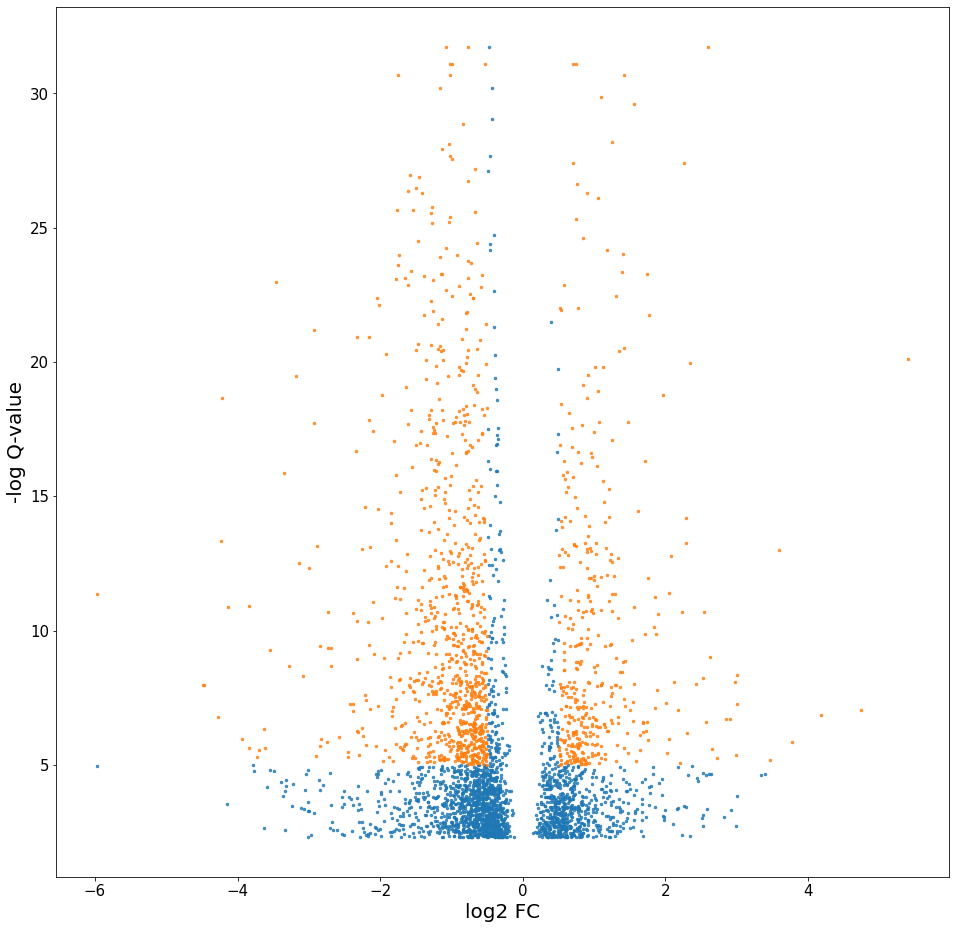

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_Airway_Epithelium_FC_vs_CC_DGE_results.csv


Performing DGE testing: Airway Epithelium FC+CMP4 vs. CC 


filtered out 4784 genes that are detected in less than 5 cells


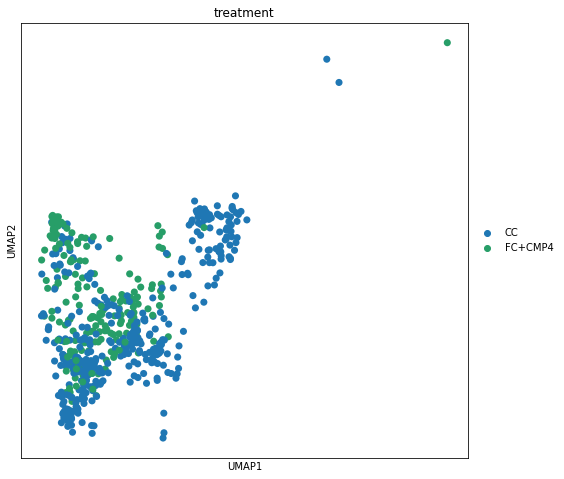

***DGE testing set-up: Airway Epithelium FC+CMP4 vs. CC***

N cells (total):
598

N cells (per condition):
CC         403
FC+CMP4    195
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 18:23:48
training location model: True
training scale model: True
iter   0: ll=26026784.421258
caught 97 linalg singular matrix errors
iter   1: ll=25462913.082176, converged: 0.00% (loc: 17.14%, scale update: False), in 1.47sec
iter   2: ll=25264879.711081, converged: 0.00% (loc: 17.14%, scale update: False), in 1.34sec
iter   3: ll=25225120.793565, converged: 0.00% (loc: 17.14%, scale update: False), in 1.44sec
iter   4: ll=25218747.894348, converged: 0.00% (loc: 17.14%, scale update: False), in 1.44sec
iter   5: ll=25217680.900380, converged: 0.00% (loc: 17.20%, scale update: False), in 1.31sec
iter   6: ll=4536899.310935, converged: 0.00% (loc: 0.00%, scale update: True), in 17.18sec
caught 95 linalg singular matrix errors
iter   7: ll=4511863.326521, converged: 0.00% (loc: 1.1

iter  84: ll=4395801.223651, converged: 99.72% (loc: 99.72%, scale update: True), in 1.83sec
iter  85: ll=4395801.222101, converged: 99.72% (loc: 99.83%, scale update: False), in 0.42sec
iter  86: ll=4395801.221984, converged: 99.72% (loc: 99.91%, scale update: False), in 0.33sec
iter  87: ll=4395801.221975, converged: 99.72% (loc: 99.95%, scale update: False), in 0.23sec
iter  88: ll=4395801.221974, converged: 99.72% (loc: 99.97%, scale update: False), in 0.20sec
iter  89: ll=4395801.221974, converged: 99.72% (loc: 99.99%, scale update: False), in 0.17sec
iter  90: ll=4395801.220451, converged: 99.80% (loc: 99.80%, scale update: True), in 1.77sec
iter  91: ll=4395801.219190, converged: 99.80% (loc: 99.89%, scale update: False), in 0.37sec
iter  92: ll=4395801.219100, converged: 99.80% (loc: 99.94%, scale update: False), in 0.27sec
iter  93: ll=4395801.219093, converged: 99.80% (loc: 99.95%, scale update: False), in 0.20sec
iter  94: ll=4395801.219092, converged: 99.80% (loc: 99.97%, s

iter 173: ll=4395801.205181, converged: 99.97% (loc: 100.00%, scale update: False), in 0.12sec
iter 174: ll=4395801.204992, converged: 99.97% (loc: 99.97%, scale update: True), in 1.22sec
iter 175: ll=4395801.204821, converged: 99.97% (loc: 99.98%, scale update: False), in 0.18sec
iter 176: ll=4395801.204815, converged: 99.97% (loc: 99.98%, scale update: False), in 0.17sec
iter 177: ll=4395801.204815, converged: 99.97% (loc: 99.99%, scale update: False), in 0.16sec
iter 178: ll=4395801.204815, converged: 99.97% (loc: 99.99%, scale update: False), in 0.15sec
iter 179: ll=4395801.204815, converged: 99.97% (loc: 100.00%, scale update: False), in 0.11sec
iter 180: ll=4395801.204646, converged: 99.97% (loc: 99.97%, scale update: True), in 1.23sec
iter 181: ll=4395801.204491, converged: 99.97% (loc: 99.98%, scale update: False), in 0.18sec
iter 182: ll=4395801.204486, converged: 99.97% (loc: 99.98%, scale update: False), in 0.16sec
iter 183: ll=4395801.204486, converged: 99.97% (loc: 99.99%,

iter 261: ll=4395801.201510, converged: 99.98% (loc: 99.99%, scale update: False), in 0.15sec
iter 262: ll=4395801.201510, converged: 99.98% (loc: 100.00%, scale update: False), in 0.15sec
iter 263: ll=4395801.201429, converged: 99.98% (loc: 99.98%, scale update: True), in 0.19sec
iter 264: ll=4395801.201348, converged: 99.98% (loc: 99.98%, scale update: False), in 0.16sec
iter 265: ll=4395801.201347, converged: 99.98% (loc: 99.99%, scale update: False), in 0.16sec
iter 266: ll=4395801.201347, converged: 99.98% (loc: 99.99%, scale update: False), in 0.14sec
iter 267: ll=4395801.201347, converged: 99.98% (loc: 100.00%, scale update: False), in 0.14sec
iter 268: ll=4395801.201264, converged: 99.98% (loc: 99.98%, scale update: True), in 0.20sec
iter 269: ll=4395801.201180, converged: 99.98% (loc: 99.98%, scale update: False), in 0.16sec
iter 270: ll=4395801.201179, converged: 99.98% (loc: 99.99%, scale update: False), in 0.17sec
iter 271: ll=4395801.201179, converged: 99.98% (loc: 99.99%,

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

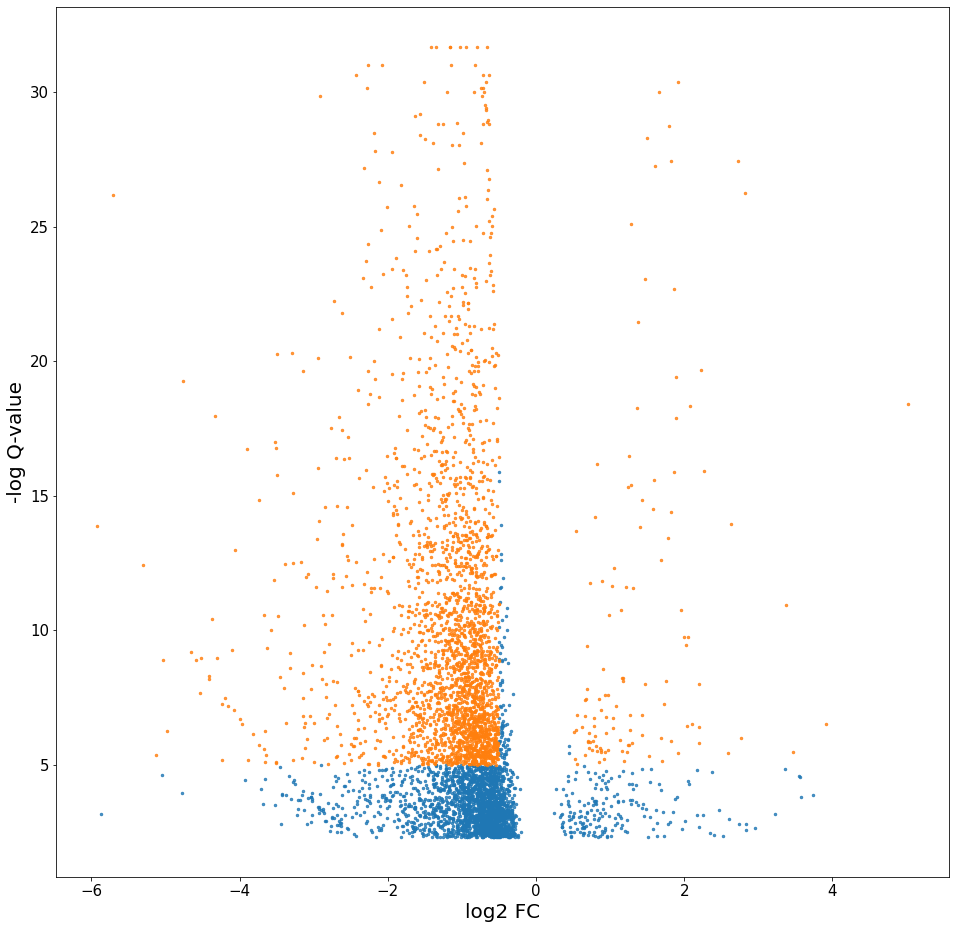

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_Airway_Epithelium_FC+CMP4_vs_CC_DGE_results.csv


Performing DGE testing: Airway Epithelium FC+Nintedanib vs. CC 


filtered out 4771 genes that are detected in less than 5 cells


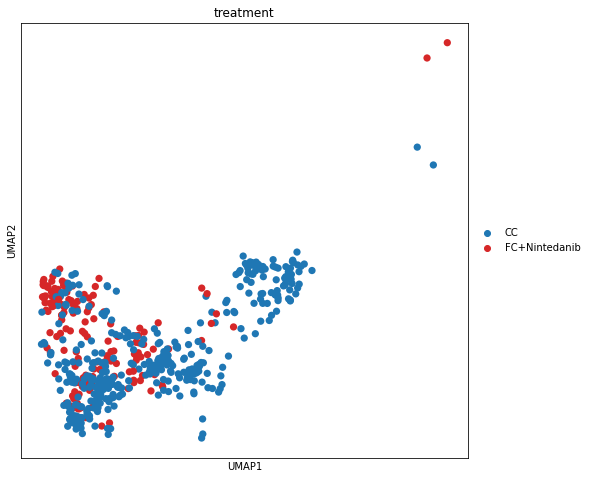

***DGE testing set-up: Airway Epithelium FC+Nintedanib vs. CC***

N cells (total):
569

N cells (per condition):
CC               403
FC+Nintedanib    166
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 18:28:08
training location model: True
training scale model: True
iter   0: ll=30220152.830990
caught 105 linalg singular matrix errors
iter   1: ll=29630313.734389, converged: 0.00% (loc: 19.77%, scale update: False), in 1.44sec
iter   2: ll=29431567.160838, converged: 0.00% (loc: 19.77%, scale update: False), in 1.33sec
iter   3: ll=29398745.850804, converged: 0.00% (loc: 19.77%, scale update: False), in 1.43sec
iter   4: ll=29396129.914146, converged: 0.00% (loc: 19.77%, scale update: False), in 1.43sec
iter   5: ll=29395995.654588, converged: 0.00% (loc: 19.77%, scale update: False), in 1.44sec
iter   6: ll=4332252.281272, converged: 0.00% (loc: 0.00%, scale update: True), in 17.17sec
caught 102 linalg singular matrix errors
iter   7: ll=4291634.961797, conver

iter  83: ll=4146964.929121, converged: 99.74% (loc: 99.99%, scale update: False), in 0.14sec
iter  84: ll=4146947.724360, converged: 99.83% (loc: 99.83%, scale update: True), in 1.80sec
iter  85: ll=4146947.724303, converged: 99.83% (loc: 99.87%, scale update: False), in 0.34sec
iter  86: ll=4146947.724299, converged: 99.83% (loc: 99.94%, scale update: False), in 0.29sec
iter  87: ll=4146947.724298, converged: 99.83% (loc: 99.98%, scale update: False), in 0.20sec
iter  88: ll=4146947.724298, converged: 99.83% (loc: 99.99%, scale update: False), in 0.17sec
iter  89: ll=4146947.724298, converged: 99.83% (loc: 99.99%, scale update: False), in 0.14sec
iter  90: ll=4146947.458660, converged: 99.86% (loc: 99.86%, scale update: True), in 1.73sec
iter  91: ll=4146947.458633, converged: 99.86% (loc: 99.89%, scale update: False), in 0.30sec
iter  92: ll=4146947.458631, converged: 99.86% (loc: 99.94%, scale update: False), in 0.27sec
iter  93: ll=4146947.458631, converged: 99.86% (loc: 99.99%, s

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

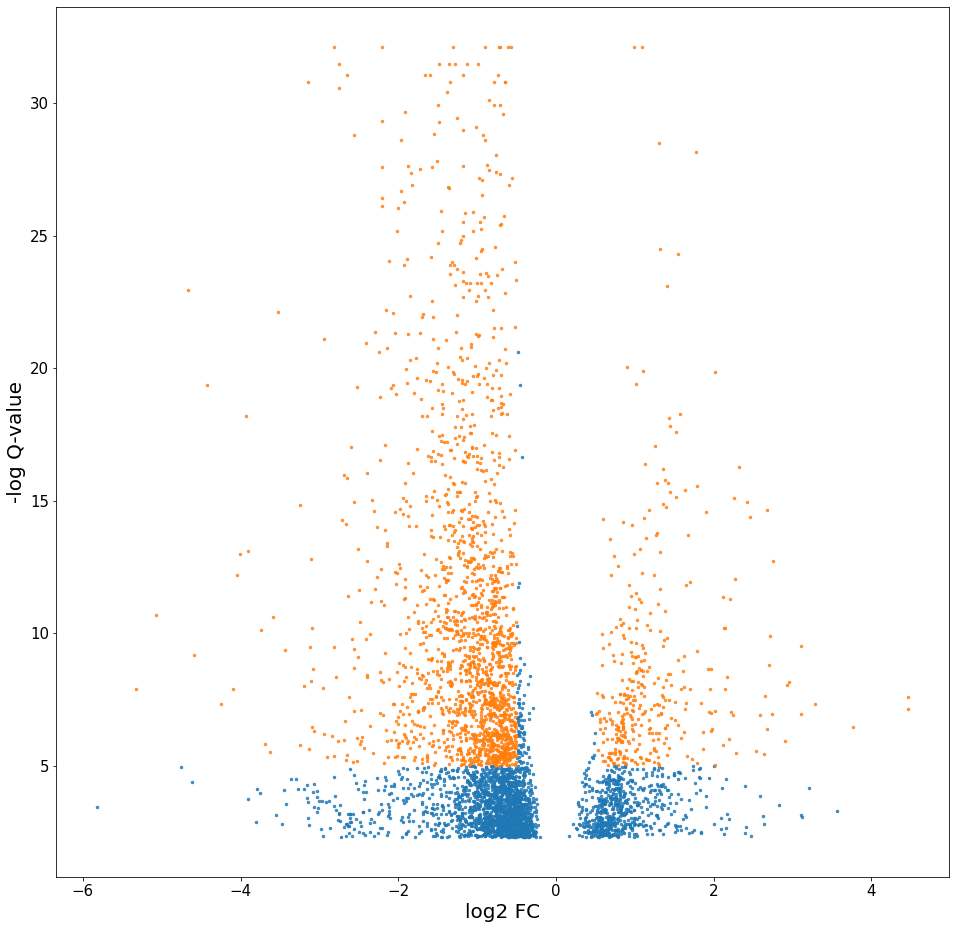

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_Airway_Epithelium_FC+Nintedanib_vs_CC_DGE_results.csv


Performing DGE testing: Alveolar Epithelium FC vs. CC 


filtered out 3824 genes that are detected in less than 5 cells


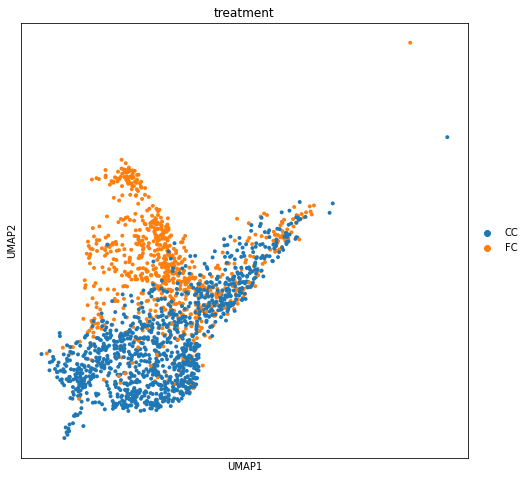

***DGE testing set-up: Alveolar Epithelium FC vs. CC***

N cells (total):
1933

N cells (per condition):
CC    1136
FC     797
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 18:31:41
training location model: True
training scale model: True
iter   0: ll=66509920.548682
caught 145 linalg singular matrix errors
iter   1: ll=64466966.928233, converged: 0.00% (loc: 17.66%, scale update: False), in 3.46sec
iter   2: ll=63762994.891525, converged: 0.00% (loc: 17.66%, scale update: False), in 2.99sec
iter   3: ll=63642446.227284, converged: 0.00% (loc: 17.66%, scale update: False), in 3.18sec
iter   4: ll=63629556.720754, converged: 0.00% (loc: 17.66%, scale update: False), in 2.93sec
iter   5: ll=63628115.391893, converged: 0.00% (loc: 17.71%, scale update: False), in 3.22sec
iter   6: ll=15721140.869378, converged: 0.00% (loc: 0.00%, scale update: True), in 34.99sec
caught 142 linalg singular matrix errors
iter   7: ll=15666486.157945, converged: 0.00% (loc: 1.43%, sc

iter  84: ll=15591862.215272, converged: 99.89% (loc: 99.89%, scale update: True), in 3.86sec
iter  85: ll=15591862.214978, converged: 99.89% (loc: 99.94%, scale update: False), in 0.28sec
iter  86: ll=15591862.214935, converged: 99.89% (loc: 99.96%, scale update: False), in 0.22sec
iter  87: ll=15591862.214928, converged: 99.89% (loc: 99.98%, scale update: False), in 0.21sec
iter  88: ll=15591862.214927, converged: 99.89% (loc: 99.99%, scale update: False), in 0.20sec
iter  89: ll=15591862.214927, converged: 99.89% (loc: 99.99%, scale update: False), in 0.19sec
iter  90: ll=15591862.214635, converged: 99.93% (loc: 99.93%, scale update: True), in 3.55sec
iter  91: ll=15591862.214415, converged: 99.93% (loc: 99.96%, scale update: False), in 0.34sec
iter  92: ll=15591862.214383, converged: 99.93% (loc: 99.96%, scale update: False), in 0.20sec
iter  93: ll=15591862.214378, converged: 99.93% (loc: 99.99%, scale update: False), in 0.21sec
iter  94: ll=15591862.214377, converged: 99.93% (loc

iter 171: ll=15591862.212316, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 172: ll=15591862.212316, converged: 99.99% (loc: 99.99%, scale update: False), in 0.20sec
iter 173: ll=15591862.212316, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 174: ll=15591862.212291, converged: 99.99% (loc: 99.99%, scale update: True), in 0.23sec
iter 175: ll=15591862.212271, converged: 99.99% (loc: 99.99%, scale update: False), in 0.19sec
iter 176: ll=15591862.212268, converged: 99.99% (loc: 99.99%, scale update: False), in 0.17sec
iter 177: ll=15591862.212268, converged: 99.99% (loc: 99.99%, scale update: False), in 0.17sec
iter 178: ll=15591862.212268, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 179: ll=15591862.212268, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 180: ll=15591862.212245, converged: 99.99% (loc: 99.99%, scale update: True), in 0.24sec
iter 181: ll=15591862.212227, converged: 99.99% (loc

iter 258: ll=15591862.211861, converged: 99.99% (loc: 99.99%, scale update: True), in 0.22sec
iter 259: ll=15591862.211852, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 260: ll=15591862.211850, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 261: ll=15591862.211850, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 262: ll=15591862.211850, converged: 99.99% (loc: 99.99%, scale update: False), in 0.17sec
iter 263: ll=15591862.211850, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 264: ll=15591862.211840, converged: 99.99% (loc: 99.99%, scale update: True), in 0.23sec
iter 265: ll=15591862.211831, converged: 99.99% (loc: 99.99%, scale update: False), in 0.19sec
iter 266: ll=15591862.211830, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 267: ll=15591862.211830, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 268: ll=15591862.211829, converged: 99.99% (loc

iter 345: ll=15591862.211594, converged: 99.99% (loc: 99.99%, scale update: False), in 0.17sec
iter 346: ll=15591862.211594, converged: 99.99% (loc: 99.99%, scale update: False), in 0.30sec
iter 347: ll=15591862.211594, converged: 99.99% (loc: 99.99%, scale update: False), in 0.17sec
iter 348: ll=15591862.211585, converged: 99.99% (loc: 99.99%, scale update: True), in 0.20sec
iter 349: ll=15591862.211578, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 350: ll=15591862.211577, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 351: ll=15591862.211577, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 352: ll=15591862.211577, converged: 99.99% (loc: 99.99%, scale update: False), in 0.19sec
iter 353: ll=15591862.211577, converged: 99.99% (loc: 99.99%, scale update: False), in 0.19sec
iter 354: ll=15591862.211568, converged: 99.99% (loc: 99.99%, scale update: True), in 0.20sec
iter 355: ll=15591862.211560, converged: 99.99% (loc

iter 432: ll=15591862.211307, converged: 99.99% (loc: 99.99%, scale update: True), in 0.19sec
iter 433: ll=15591862.211297, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 434: ll=15591862.211295, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 435: ll=15591862.211295, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 436: ll=15591862.211295, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 437: ll=15591862.211295, converged: 99.99% (loc: 99.99%, scale update: False), in 0.31sec
iter 438: ll=15591862.211283, converged: 99.99% (loc: 99.99%, scale update: True), in 0.20sec
iter 439: ll=15591862.211272, converged: 99.99% (loc: 99.99%, scale update: False), in 0.17sec
iter 440: ll=15591862.211270, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 441: ll=15591862.211270, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 442: ll=15591862.211270, converged: 99.99% (loc

iter 519: ll=15591862.210781, converged: 99.99% (loc: 99.99%, scale update: False), in 0.17sec
iter 520: ll=15591862.210781, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 521: ll=15591862.210781, converged: 99.99% (loc: 99.99%, scale update: False), in 0.17sec
iter 522: ll=15591862.210753, converged: 99.99% (loc: 99.99%, scale update: True), in 0.19sec
iter 523: ll=15591862.210727, converged: 99.99% (loc: 99.99%, scale update: False), in 0.19sec
iter 524: ll=15591862.210723, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 525: ll=15591862.210723, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 526: ll=15591862.210723, converged: 99.99% (loc: 99.99%, scale update: False), in 0.32sec
iter 527: ll=15591862.210723, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 528: ll=15591862.210692, converged: 99.99% (loc: 99.99%, scale update: True), in 0.19sec
iter 529: ll=15591862.210664, converged: 99.99% (loc

iter 606: ll=15591862.209052, converged: 99.99% (loc: 99.99%, scale update: True), in 0.20sec
iter 607: ll=15591862.208945, converged: 99.99% (loc: 99.99%, scale update: False), in 0.17sec
iter 608: ll=15591862.208931, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 609: ll=15591862.208929, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 610: ll=15591862.208929, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 611: ll=15591862.208929, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 612: ll=15591862.208800, converged: 99.99% (loc: 99.99%, scale update: True), in 0.20sec
iter 613: ll=15591862.208680, converged: 99.99% (loc: 99.99%, scale update: False), in 0.17sec
iter 614: ll=15591862.208664, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 615: ll=15591862.208662, converged: 99.99% (loc: 99.99%, scale update: False), in 0.17sec
iter 616: ll=15591862.208662, converged: 99.99% (loc

iter 694: ll=15591862.199046, converged: 99.99% (loc: 99.99%, scale update: False), in 0.16sec
iter 695: ll=15591862.199046, converged: 99.99% (loc: 99.99%, scale update: False), in 0.17sec
iter 696: ll=15591862.198282, converged: 99.99% (loc: 99.99%, scale update: True), in 0.18sec
iter 697: ll=15591862.197567, converged: 99.99% (loc: 99.99%, scale update: False), in 0.17sec
iter 698: ll=15591862.197488, converged: 99.99% (loc: 99.99%, scale update: False), in 0.16sec
iter 699: ll=15591862.197479, converged: 99.99% (loc: 99.99%, scale update: False), in 0.17sec
iter 700: ll=15591862.197478, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 701: ll=15591862.197478, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 702: ll=15591862.196634, converged: 99.99% (loc: 99.99%, scale update: True), in 0.20sec
iter 703: ll=15591862.195847, converged: 99.99% (loc: 99.99%, scale update: False), in 0.19sec
iter 704: ll=15591862.195761, converged: 99.99% (loc

iter 867: ll=15591862.166930, converged: 99.99% (loc: 99.99%, scale update: True), in 0.19sec
iter 868: ll=15591862.166925, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 869: ll=15591862.166925, converged: 99.99% (loc: 99.99%, scale update: False), in 0.17sec
iter 870: ll=15591862.166925, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 871: ll=15591862.166925, converged: 99.99% (loc: 100.00%, scale update: False), in 0.18sec
iter 872: ll=15591862.166920, converged: 99.99% (loc: 99.99%, scale update: True), in 0.21sec
iter 873: ll=15591862.166917, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 874: ll=15591862.166917, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 875: ll=15591862.166917, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 876: ll=15591862.166917, converged: 99.99% (loc: 100.00%, scale update: False), in 0.18sec
iter 877: ll=15591862.166914, converged: 99.99% (l

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

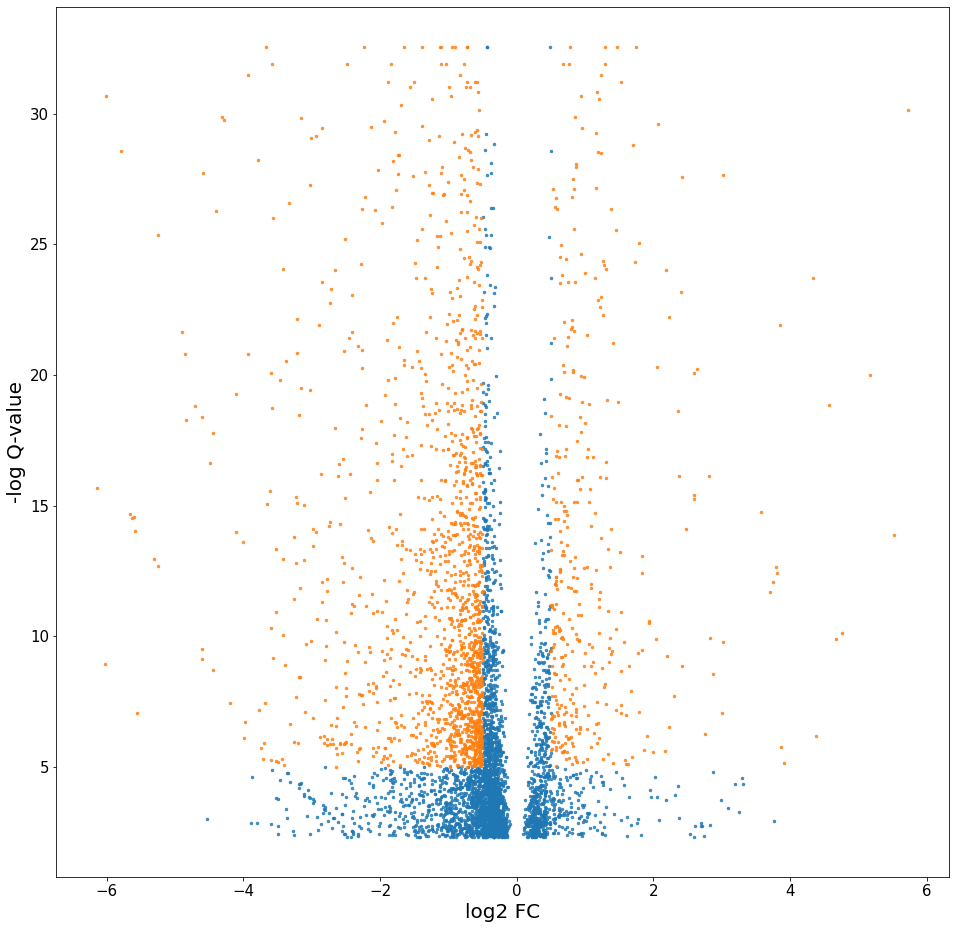

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_Alveolar_Epithelium_FC_vs_CC_DGE_results.csv


Performing DGE testing: Alveolar Epithelium FC+CMP4 vs. CC 


filtered out 3783 genes that are detected in less than 5 cells


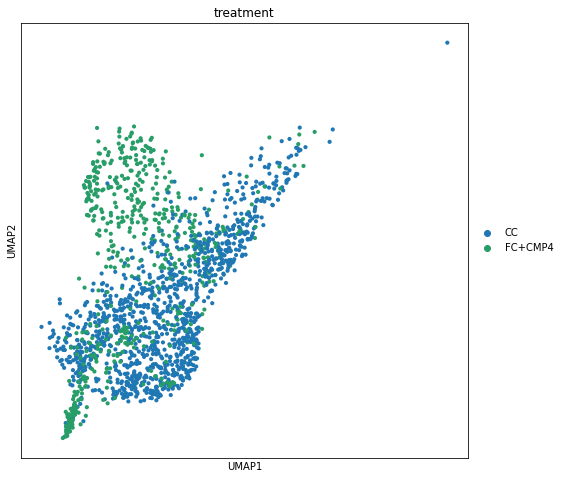

***DGE testing set-up: Alveolar Epithelium FC+CMP4 vs. CC***

N cells (total):
1740

N cells (per condition):
CC         1136
FC+CMP4     604
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 18:40:08
training location model: True
training scale model: True
iter   0: ll=110387233.347113
caught 135 linalg singular matrix errors
iter   1: ll=107835833.246952, converged: 0.00% (loc: 22.31%, scale update: False), in 2.82sec
iter   2: ll=106800587.860241, converged: 0.00% (loc: 22.31%, scale update: False), in 2.44sec
iter   3: ll=106539535.103868, converged: 0.00% (loc: 22.31%, scale update: False), in 2.41sec
iter   4: ll=106491144.070237, converged: 0.00% (loc: 22.31%, scale update: False), in 2.53sec
iter   5: ll=106482991.689506, converged: 0.00% (loc: 22.31%, scale update: False), in 2.54sec
iter   6: ll=15615728.383748, converged: 0.00% (loc: 0.00%, scale update: True), in 36.90sec
caught 129 linalg singular matrix errors
iter   7: ll=15525640.381656, converged: 

iter  84: ll=15398731.924693, converged: 99.81% (loc: 99.81%, scale update: True), in 3.81sec
iter  85: ll=15398731.923750, converged: 99.81% (loc: 99.84%, scale update: False), in 0.38sec
iter  86: ll=15398731.923734, converged: 99.81% (loc: 99.91%, scale update: False), in 0.33sec
iter  87: ll=15398731.923733, converged: 99.81% (loc: 99.93%, scale update: False), in 0.25sec
iter  88: ll=15398731.923733, converged: 99.81% (loc: 99.98%, scale update: False), in 0.22sec
iter  89: ll=15398731.923733, converged: 99.81% (loc: 99.99%, scale update: False), in 0.18sec
iter  90: ll=15398695.701099, converged: 99.83% (loc: 99.83%, scale update: True), in 3.81sec
iter  91: ll=15398695.700519, converged: 99.83% (loc: 99.88%, scale update: False), in 0.36sec
iter  92: ll=15398695.700512, converged: 99.83% (loc: 99.93%, scale update: False), in 0.28sec
iter  93: ll=15398695.700511, converged: 99.83% (loc: 99.94%, scale update: False), in 0.23sec
iter  94: ll=15398695.700511, converged: 99.83% (loc

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

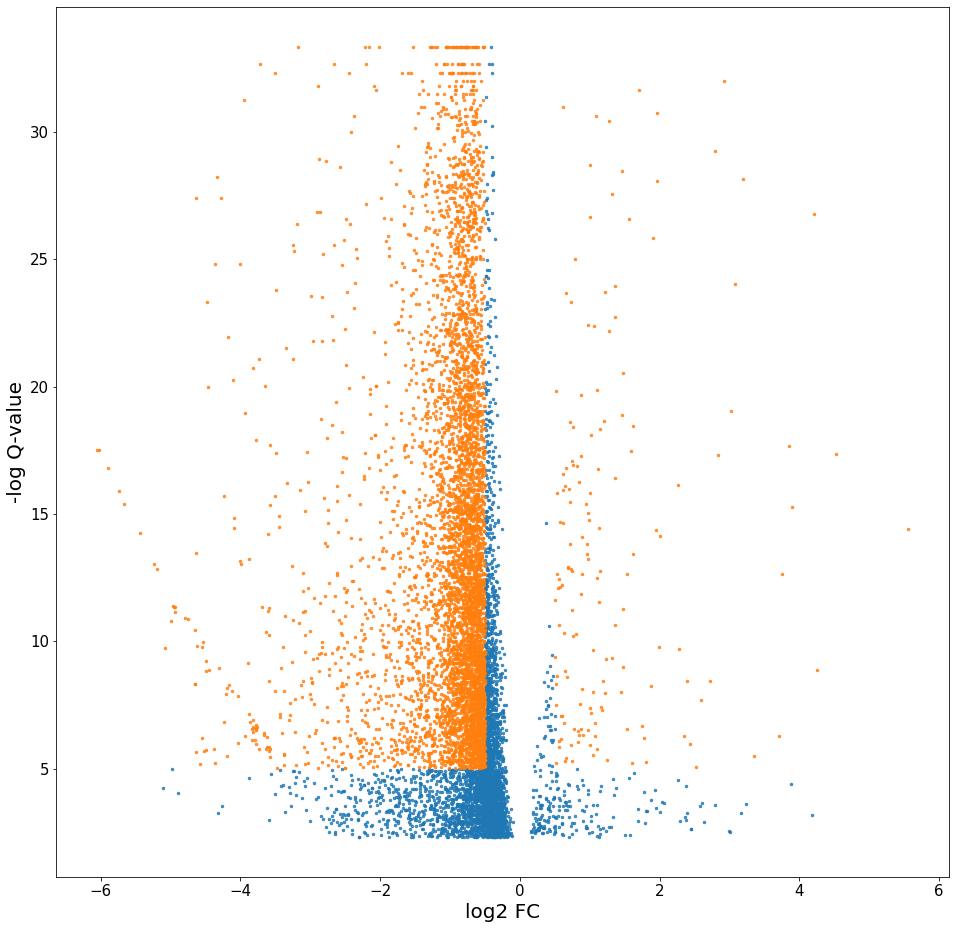

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_Alveolar_Epithelium_FC+CMP4_vs_CC_DGE_results.csv


Performing DGE testing: Alveolar Epithelium FC+Nintedanib vs. CC 


filtered out 3919 genes that are detected in less than 5 cells


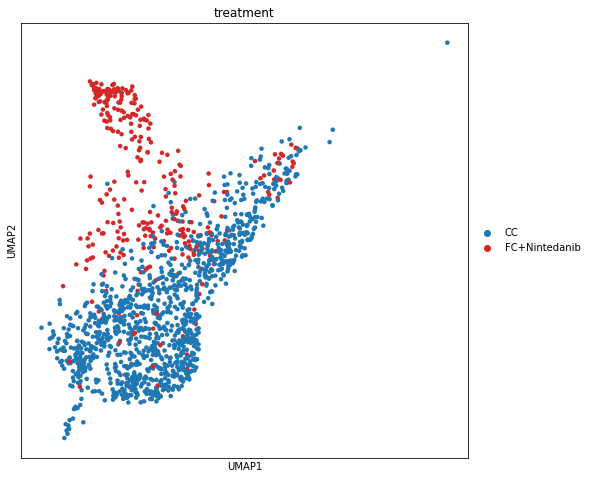

***DGE testing set-up: Alveolar Epithelium FC+Nintedanib vs. CC***

N cells (total):
1465

N cells (per condition):
CC               1136
FC+Nintedanib     329
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 18:46:58
training location model: True
training scale model: True
iter   0: ll=89304172.413311
caught 267 linalg singular matrix errors
iter   1: ll=87285857.722403, converged: 0.00% (loc: 22.62%, scale update: False), in 2.94sec
iter   2: ll=86461567.848409, converged: 0.00% (loc: 22.62%, scale update: False), in 2.41sec
iter   3: ll=86241944.264946, converged: 0.00% (loc: 22.62%, scale update: False), in 2.63sec
iter   4: ll=86195893.621944, converged: 0.00% (loc: 22.62%, scale update: False), in 2.44sec
iter   5: ll=86187145.732204, converged: 0.00% (loc: 22.63%, scale update: False), in 2.66sec
iter   6: ll=13006112.694812, converged: 0.00% (loc: 0.00%, scale update: True), in 30.42sec
caught 263 linalg singular matrix errors
iter   7: ll=12935540.415965,

iter  83: ll=12815744.111464, converged: 99.78% (loc: 99.99%, scale update: False), in 0.20sec
iter  84: ll=12815744.104865, converged: 99.82% (loc: 99.82%, scale update: True), in 3.90sec
iter  85: ll=12815744.098817, converged: 99.82% (loc: 99.88%, scale update: False), in 0.36sec
iter  86: ll=12815744.098317, converged: 99.82% (loc: 99.93%, scale update: False), in 0.28sec
iter  87: ll=12815744.098262, converged: 99.82% (loc: 99.96%, scale update: False), in 0.22sec
iter  88: ll=12815744.098255, converged: 99.82% (loc: 99.97%, scale update: False), in 0.18sec
iter  89: ll=12815744.098254, converged: 99.82% (loc: 99.99%, scale update: False), in 0.18sec
iter  90: ll=12815744.091255, converged: 99.88% (loc: 99.88%, scale update: True), in 4.03sec
iter  91: ll=12815744.084391, converged: 99.88% (loc: 99.92%, scale update: False), in 0.28sec
iter  92: ll=12815744.083940, converged: 99.88% (loc: 99.96%, scale update: False), in 0.24sec
iter  93: ll=12815744.083897, converged: 99.88% (loc

iter 171: ll=12815743.996299, converged: 99.99% (loc: 99.99%, scale update: False), in 0.17sec
iter 172: ll=12815743.996298, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 173: ll=12815743.996298, converged: 99.99% (loc: 100.00%, scale update: False), in 0.16sec
iter 174: ll=12815743.996071, converged: 99.99% (loc: 99.99%, scale update: True), in 0.19sec
iter 175: ll=12815743.995850, converged: 99.99% (loc: 99.99%, scale update: False), in 0.17sec
iter 176: ll=12815743.995837, converged: 99.99% (loc: 99.99%, scale update: False), in 0.16sec
iter 177: ll=12815743.995836, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 178: ll=12815743.995836, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter 179: ll=12815743.995836, converged: 99.99% (loc: 100.00%, scale update: False), in 0.16sec
iter 180: ll=12815743.995590, converged: 99.99% (loc: 99.99%, scale update: True), in 0.20sec
iter 181: ll=12815743.995348, converged: 99.99% (l

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

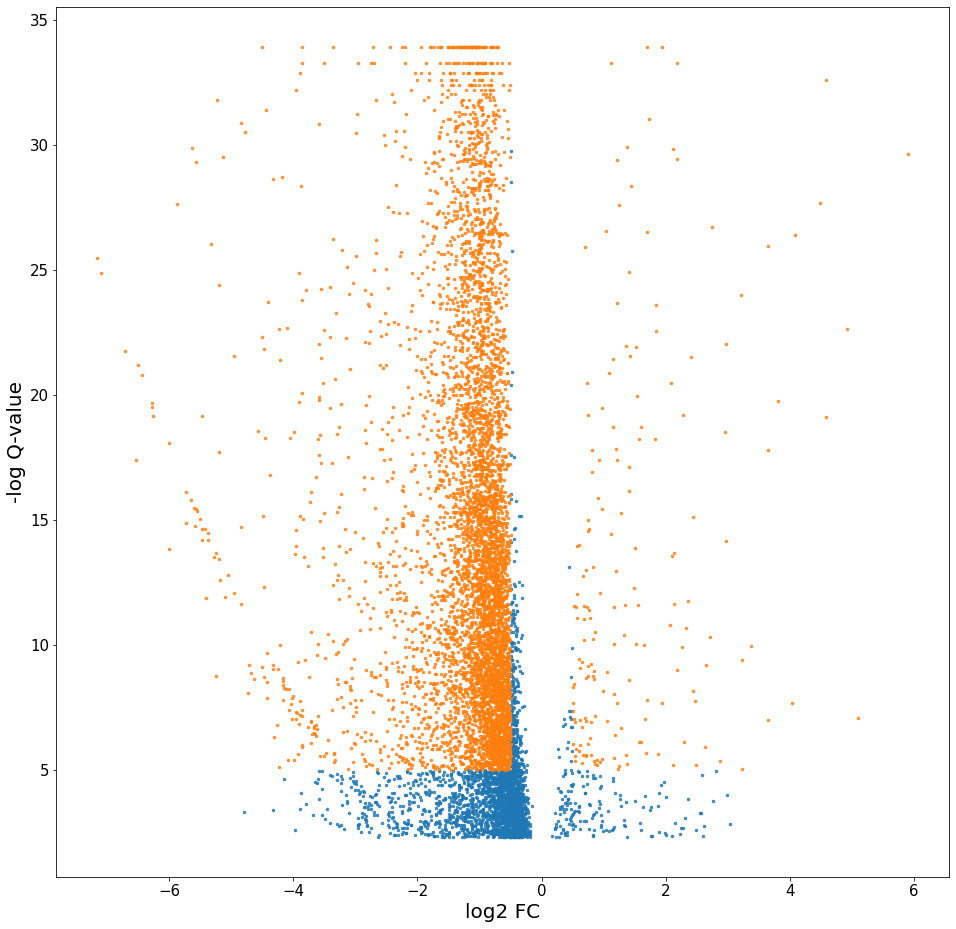

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_Alveolar_Epithelium_FC+Nintedanib_vs_CC_DGE_results.csv


Performing DGE testing: capillary EC FC vs. CC 


filtered out 4673 genes that are detected in less than 5 cells


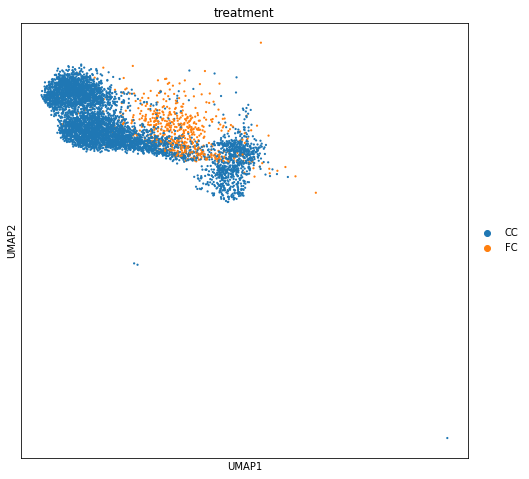

***DGE testing set-up: capillary EC FC vs. CC***

N cells (total):
6134

N cells (per condition):
CC    5476
FC     658
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 18:53:15
training location model: True
training scale model: True
iter   0: ll=29943603.201272
caught 829 linalg singular matrix errors
iter   1: ll=27289959.631544, converged: 0.00% (loc: 7.18%, scale update: False), in 7.62sec
iter   2: ll=26473955.252472, converged: 0.00% (loc: 7.18%, scale update: False), in 5.75sec
iter   3: ll=26401799.352619, converged: 0.00% (loc: 7.18%, scale update: False), in 5.64sec
iter   4: ll=26401191.441950, converged: 0.00% (loc: 7.18%, scale update: False), in 5.70sec
iter   5: ll=26401190.709211, converged: 0.00% (loc: 11.22%, scale update: False), in 5.68sec
iter   6: ll=24090822.852538, converged: 0.03% (loc: 0.03%, scale update: True), in 101.95sec
caught 821 linalg singular matrix errors
iter   7: ll=24086978.642144, converged: 0.03% (loc: 7.30%, scale update

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

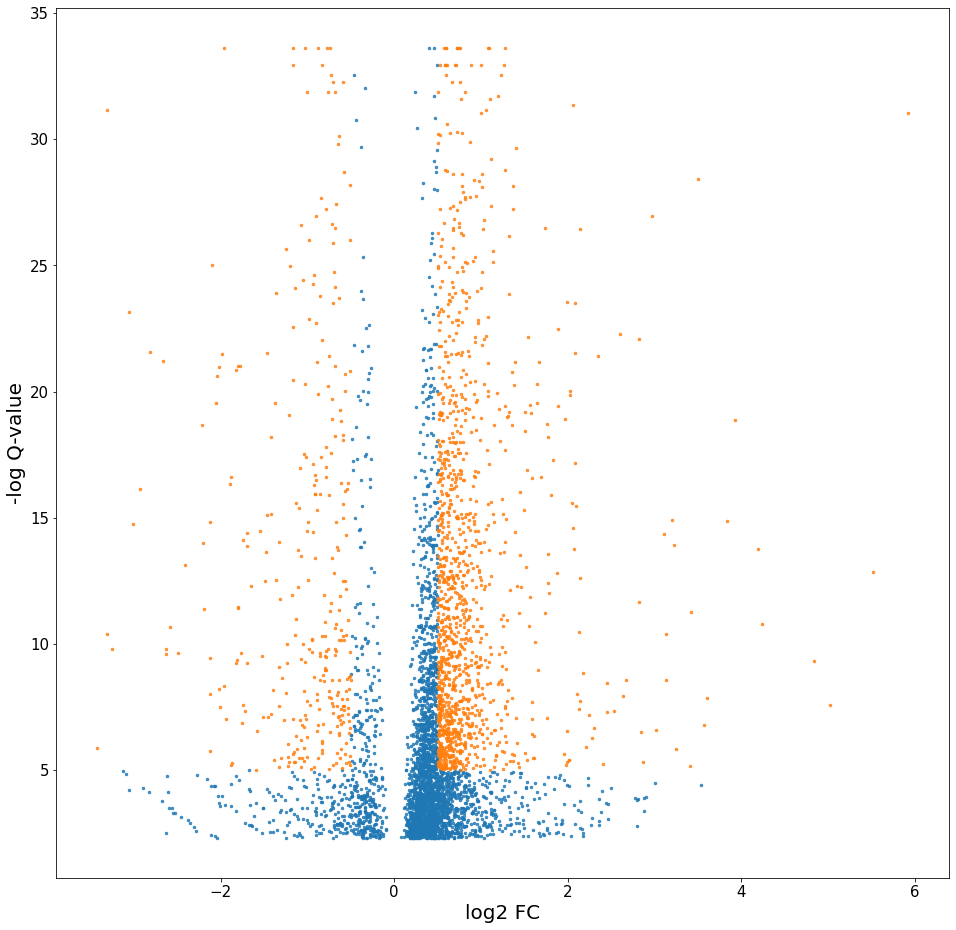

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_capillary_EC_FC_vs_CC_DGE_results.csv


Performing DGE testing: capillary EC FC+CMP4 vs. CC 


filtered out 4301 genes that are detected in less than 5 cells


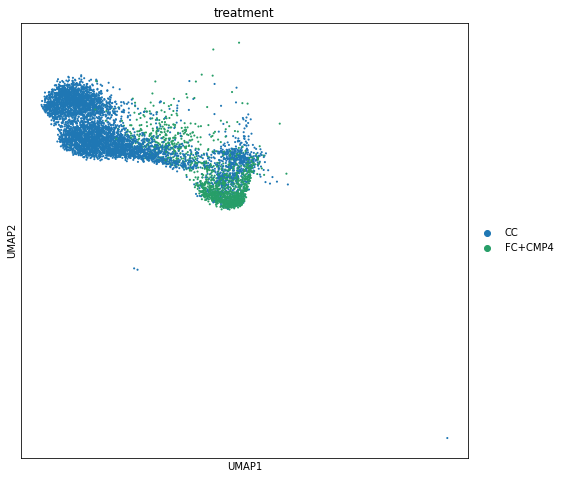

***DGE testing set-up: capillary EC FC+CMP4 vs. CC***

N cells (total):
6851

N cells (per condition):
CC         5476
FC+CMP4    1375
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 19:02:43
training location model: True
training scale model: True
iter   0: ll=41038508.527603
caught 342 linalg singular matrix errors
iter   1: ll=37807860.830953, converged: 0.00% (loc: 5.05%, scale update: False), in 7.99sec
iter   2: ll=36823582.759429, converged: 0.00% (loc: 5.05%, scale update: False), in 6.74sec
iter   3: ll=36734971.606498, converged: 0.00% (loc: 5.05%, scale update: False), in 6.62sec
iter   4: ll=36733926.318767, converged: 0.00% (loc: 5.05%, scale update: False), in 6.77sec
iter   5: ll=36733894.308754, converged: 0.00% (loc: 6.07%, scale update: False), in 6.83sec
iter   6: ll=32255003.564446, converged: 0.00% (loc: 0.00%, scale update: True), in 122.16sec
caught 342 linalg singular matrix errors
iter   7: ll=32237353.984677, converged: 0.00% (loc: 3.63%

iter  82: ll=32220064.579105, converged: 99.92% (loc: 100.00%, scale update: False), in 0.26sec
iter  83: ll=32220064.579102, converged: 99.94% (loc: 99.94%, scale update: True), in 7.28sec
iter  84: ll=32220064.579100, converged: 99.94% (loc: 99.96%, scale update: False), in 0.35sec
iter  85: ll=32220064.579100, converged: 99.94% (loc: 99.98%, scale update: False), in 0.49sec
iter  86: ll=32220064.579100, converged: 99.94% (loc: 99.99%, scale update: False), in 0.32sec
iter  87: ll=32220064.579100, converged: 99.94% (loc: 100.00%, scale update: False), in 0.28sec
iter  88: ll=32220064.579099, converged: 99.96% (loc: 99.96%, scale update: True), in 6.27sec
iter  89: ll=32220064.579098, converged: 99.96% (loc: 99.97%, scale update: False), in 0.29sec
iter  90: ll=32220064.579098, converged: 99.96% (loc: 99.98%, scale update: False), in 0.31sec
iter  91: ll=32220064.579098, converged: 99.96% (loc: 100.00%, scale update: False), in 0.29sec
iter  92: ll=32220064.579098, converged: 99.97% (

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

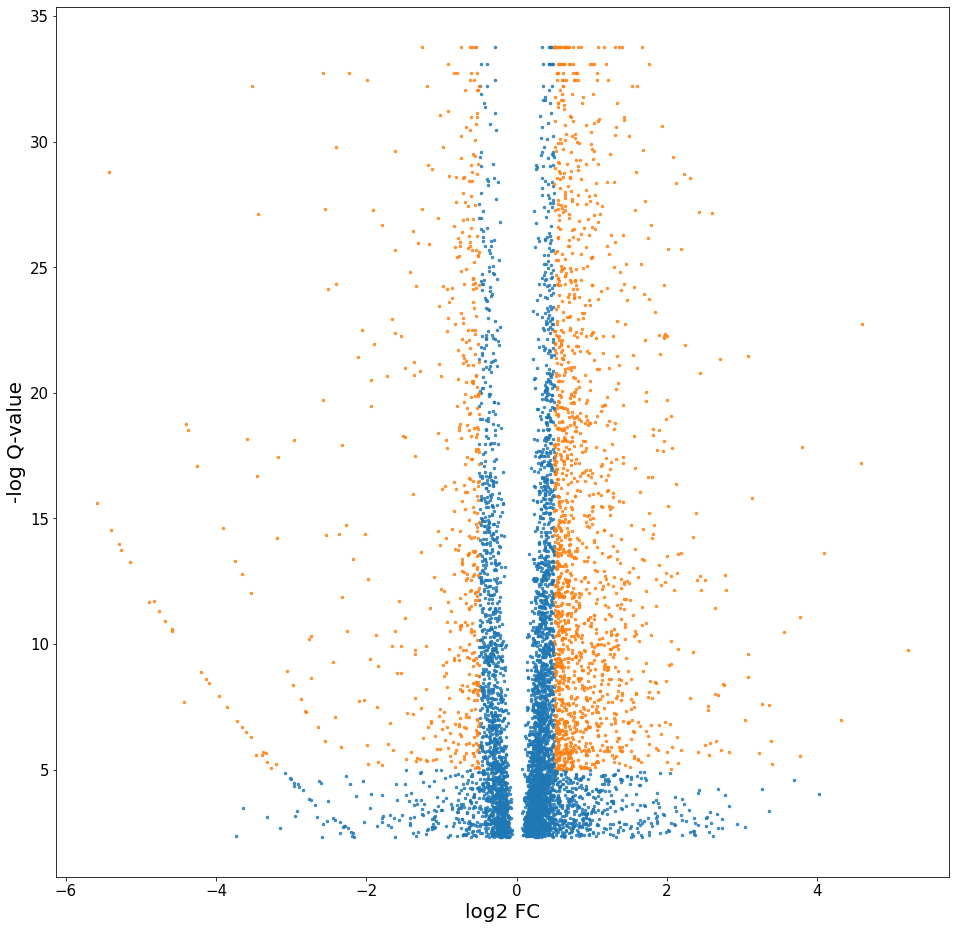

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_capillary_EC_FC+CMP4_vs_CC_DGE_results.csv


Performing DGE testing: capillary EC FC+Nintedanib vs. CC 


filtered out 4611 genes that are detected in less than 5 cells


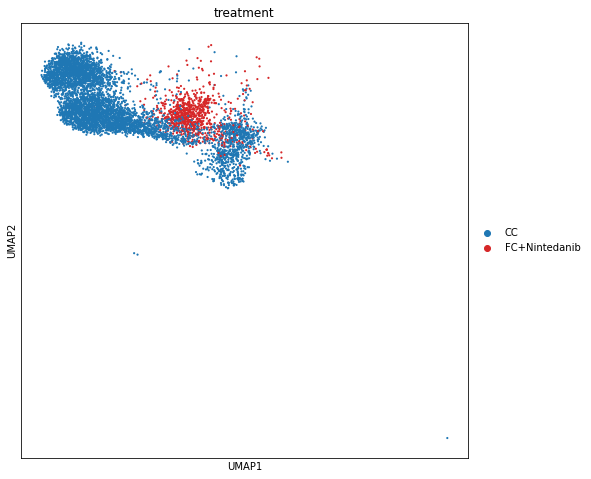

***DGE testing set-up: capillary EC FC+Nintedanib vs. CC***

N cells (total):
6374

N cells (per condition):
CC               5476
FC+Nintedanib     898
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 19:16:39
training location model: True
training scale model: True
iter   0: ll=31880694.149860
caught 620 linalg singular matrix errors
iter   1: ll=29072737.604817, converged: 0.00% (loc: 5.70%, scale update: False), in 6.99sec
iter   2: ll=28229166.301375, converged: 0.00% (loc: 5.70%, scale update: False), in 5.67sec
iter   3: ll=28156522.888946, converged: 0.00% (loc: 5.70%, scale update: False), in 5.45sec
iter   4: ll=28155915.191817, converged: 0.00% (loc: 5.71%, scale update: False), in 5.70sec
iter   5: ll=28155914.503110, converged: 0.00% (loc: 13.07%, scale update: False), in 5.75sec
iter   6: ll=25795406.957988, converged: 0.00% (loc: 0.00%, scale update: True), in 106.14sec
caught 616 linalg singular matrix errors
iter   7: ll=25791780.445725, converged

iter  83: ll=25761582.861833, converged: 99.97% (loc: 99.97%, scale update: True), in 4.62sec
iter  84: ll=25761582.861824, converged: 99.97% (loc: 99.97%, scale update: False), in 0.46sec
iter  85: ll=25761582.861824, converged: 99.97% (loc: 99.97%, scale update: False), in 0.30sec
iter  86: ll=25761582.861824, converged: 99.97% (loc: 99.99%, scale update: False), in 0.25sec
iter  87: ll=25761582.861824, converged: 99.97% (loc: 100.00%, scale update: False), in 0.27sec
iter  88: ll=25761582.861818, converged: 99.97% (loc: 99.97%, scale update: True), in 4.47sec
iter  89: ll=25761582.861813, converged: 99.97% (loc: 99.97%, scale update: False), in 0.32sec
iter  90: ll=25761582.861813, converged: 99.97% (loc: 99.98%, scale update: False), in 0.30sec
iter  91: ll=25761582.861813, converged: 99.97% (loc: 99.99%, scale update: False), in 0.30sec
iter  92: ll=25761582.861813, converged: 99.97% (loc: 100.00%, scale update: False), in 0.25sec
iter  93: ll=25761582.861810, converged: 99.97% (l

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

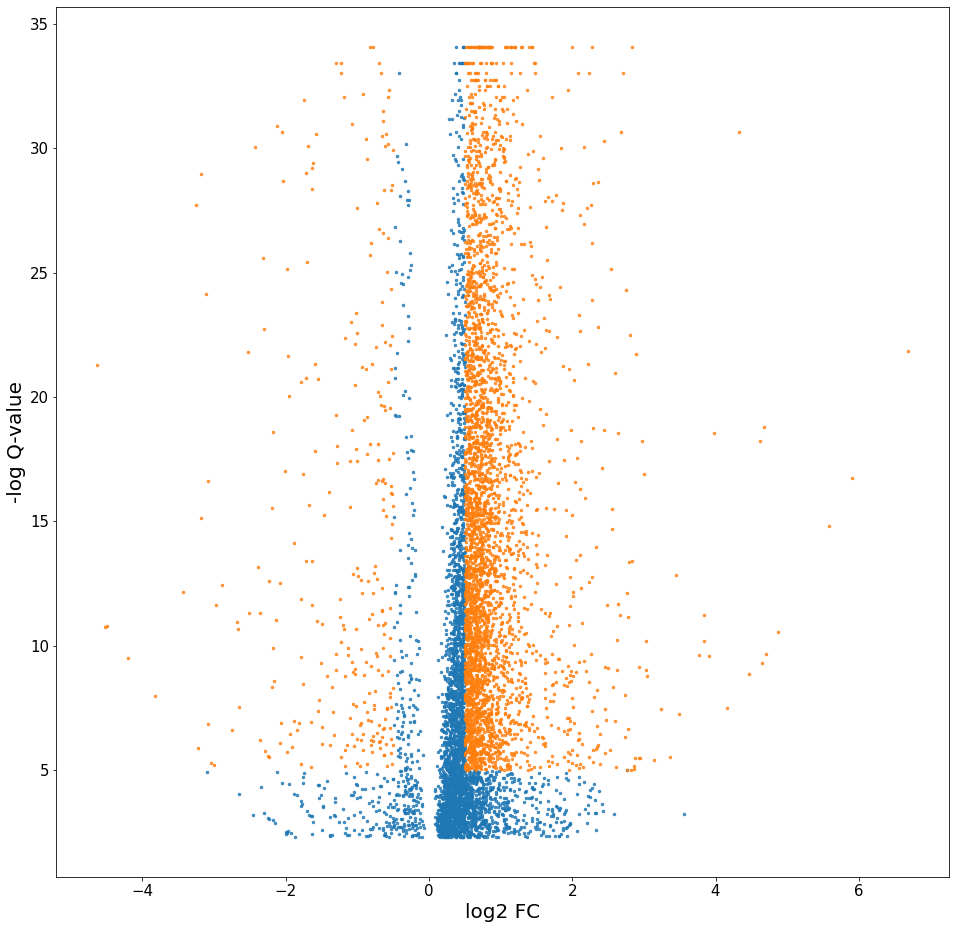

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_capillary_EC_FC+Nintedanib_vs_CC_DGE_results.csv


Performing DGE testing: vascular EC FC vs. CC 


filtered out 4408 genes that are detected in less than 5 cells


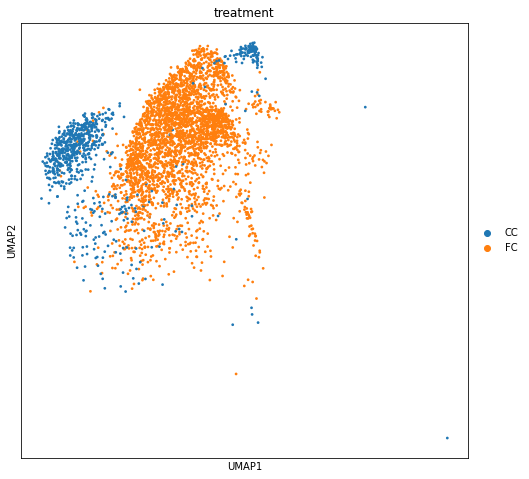

***DGE testing set-up: vascular EC FC vs. CC***

N cells (total):
3976

N cells (per condition):
FC    3149
CC     827
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 19:27:04
training location model: True
training scale model: True
iter   0: ll=35297805.018114
caught 665 linalg singular matrix errors
iter   1: ll=31908414.196088, converged: 0.00% (loc: 7.93%, scale update: False), in 4.62sec
iter   2: ll=31033563.754755, converged: 0.00% (loc: 7.93%, scale update: False), in 4.53sec
iter   3: ll=30961245.878454, converged: 0.00% (loc: 7.93%, scale update: False), in 4.13sec
iter   4: ll=30959857.460534, converged: 0.00% (loc: 7.93%, scale update: False), in 3.88sec
iter   5: ll=30959840.611979, converged: 0.00% (loc: 8.47%, scale update: False), in 4.16sec
iter   6: ll=26271629.430298, converged: 0.03% (loc: 0.03%, scale update: True), in 78.30sec
caught 644 linalg singular matrix errors
iter   7: ll=26257523.781894, converged: 0.03% (loc: 5.74%, scale update: F

iter  82: ll=26138339.161930, converged: 99.95% (loc: 99.97%, scale update: False), in 0.24sec
iter  83: ll=26138339.161930, converged: 99.95% (loc: 100.00%, scale update: False), in 0.21sec
iter  84: ll=26138339.161929, converged: 99.95% (loc: 99.95%, scale update: True), in 6.43sec
iter  85: ll=26138339.161928, converged: 99.95% (loc: 99.96%, scale update: False), in 0.23sec
iter  86: ll=26138339.161928, converged: 99.95% (loc: 99.98%, scale update: False), in 0.24sec
iter  87: ll=26138339.161928, converged: 99.95% (loc: 100.00%, scale update: False), in 0.22sec
iter  88: ll=26138339.161927, converged: 99.95% (loc: 99.95%, scale update: True), in 6.41sec
iter  89: ll=26138339.161927, converged: 99.95% (loc: 99.97%, scale update: False), in 0.25sec
iter  90: ll=26138339.161927, converged: 99.95% (loc: 99.99%, scale update: False), in 0.23sec
iter  91: ll=26138339.161927, converged: 99.95% (loc: 100.00%, scale update: False), in 0.19sec
iter  92: ll=26138339.161927, converged: 99.96% (

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

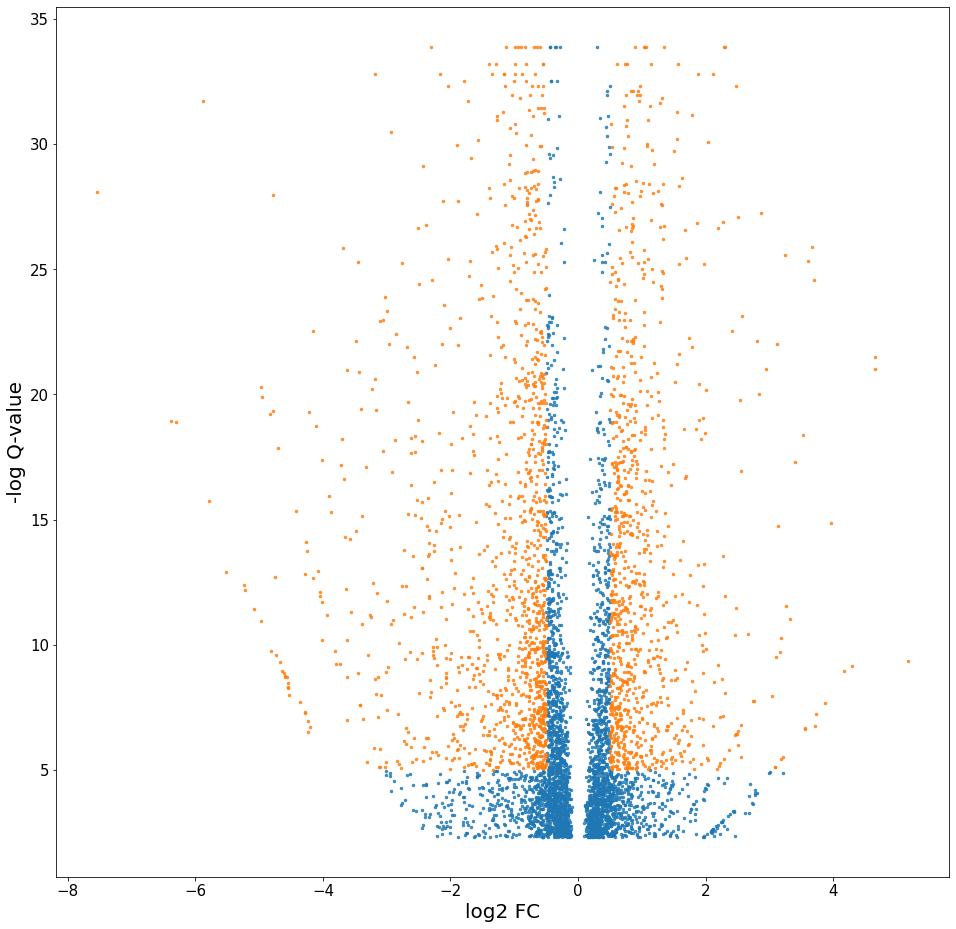

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_vascular_EC_FC_vs_CC_DGE_results.csv


Performing DGE testing: vascular EC FC+CMP4 vs. CC 


filtered out 5433 genes that are detected in less than 5 cells


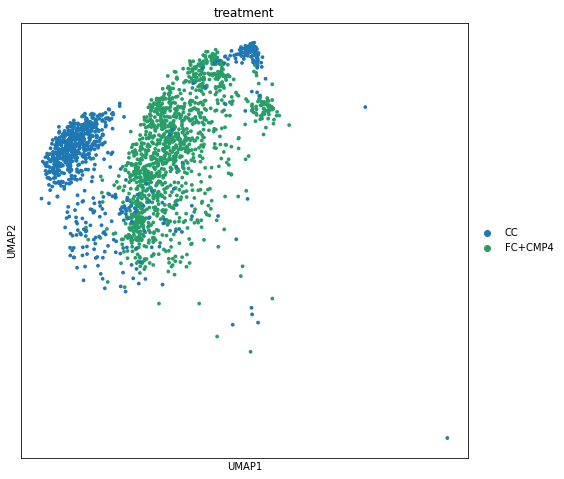

***DGE testing set-up: vascular EC FC+CMP4 vs. CC***

N cells (total):
2099

N cells (per condition):
FC+CMP4    1272
CC          827
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 19:36:59
training location model: True
training scale model: True
iter   0: ll=14235162.352549
caught 221 linalg singular matrix errors
iter   1: ll=12792308.324838, converged: 0.00% (loc: 3.18%, scale update: False), in 3.11sec
iter   2: ll=12466431.544140, converged: 0.00% (loc: 3.18%, scale update: False), in 3.08sec
iter   3: ll=12447648.896402, converged: 0.00% (loc: 3.18%, scale update: False), in 3.13sec
iter   4: ll=12447505.504729, converged: 0.00% (loc: 3.18%, scale update: False), in 2.86sec
iter   5: ll=12447504.446224, converged: 0.00% (loc: 6.49%, scale update: False), in 2.76sec
iter   6: ll=11407589.094690, converged: 0.01% (loc: 0.01%, scale update: True), in 35.44sec
caught 220 linalg singular matrix errors
iter   7: ll=11403949.767626, converged: 0.01% (loc: 2.37%, 

iter  82: ll=11385543.222087, converged: 99.98% (loc: 99.98%, scale update: True), in 0.22sec
iter  83: ll=11385543.222087, converged: 99.98% (loc: 99.98%, scale update: False), in 0.18sec
iter  84: ll=11385543.222087, converged: 99.98% (loc: 100.00%, scale update: False), in 0.18sec
iter  85: ll=11385543.222086, converged: 99.98% (loc: 99.98%, scale update: True), in 0.34sec
iter  86: ll=11385543.222086, converged: 99.98% (loc: 99.99%, scale update: False), in 0.19sec
iter  87: ll=11385543.222086, converged: 99.98% (loc: 100.00%, scale update: False), in 0.16sec
iter  88: ll=11385543.222086, converged: 99.98% (loc: 99.98%, scale update: True), in 0.19sec
iter  89: ll=11385543.222086, converged: 99.98% (loc: 99.99%, scale update: False), in 0.18sec
iter  90: ll=11385543.222086, converged: 99.98% (loc: 100.00%, scale update: False), in 0.17sec
iter  91: ll=11385543.222086, converged: 99.99% (loc: 99.99%, scale update: True), in 0.21sec
iter  92: ll=11385543.222086, converged: 99.99% (lo

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

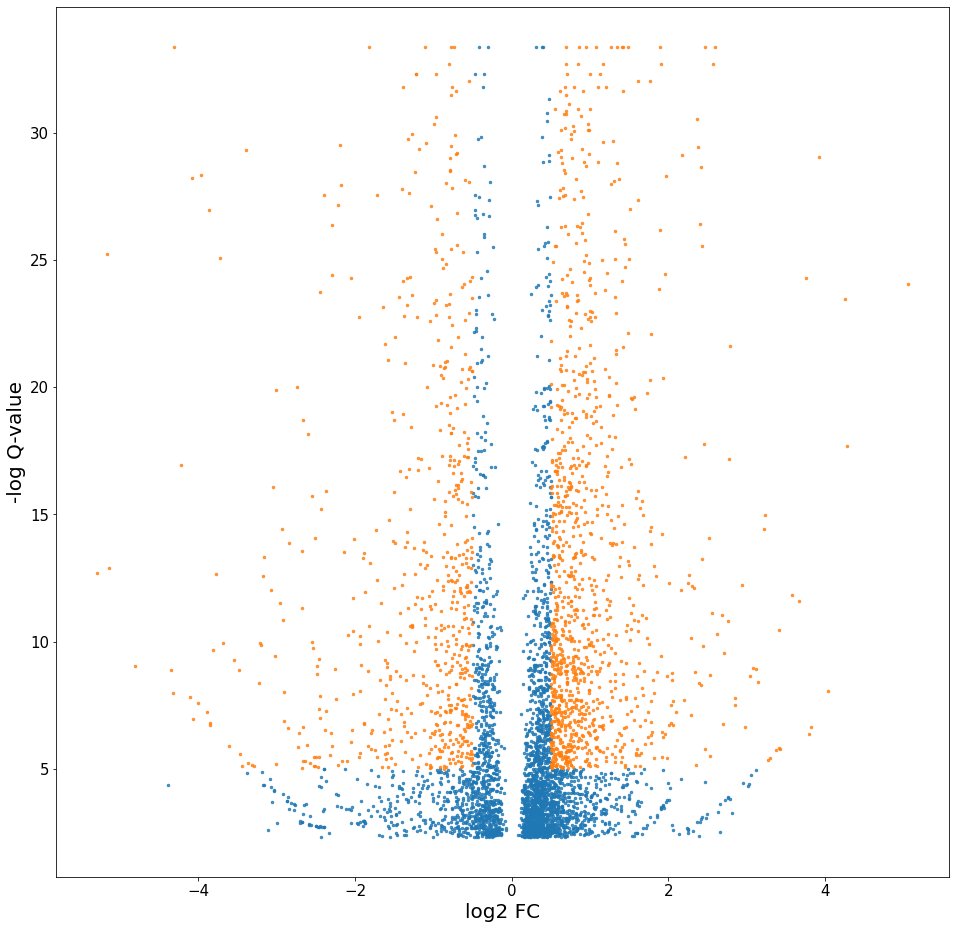

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_vascular_EC_FC+CMP4_vs_CC_DGE_results.csv


Performing DGE testing: vascular EC FC+Nintedanib vs. CC 


filtered out 4992 genes that are detected in less than 5 cells


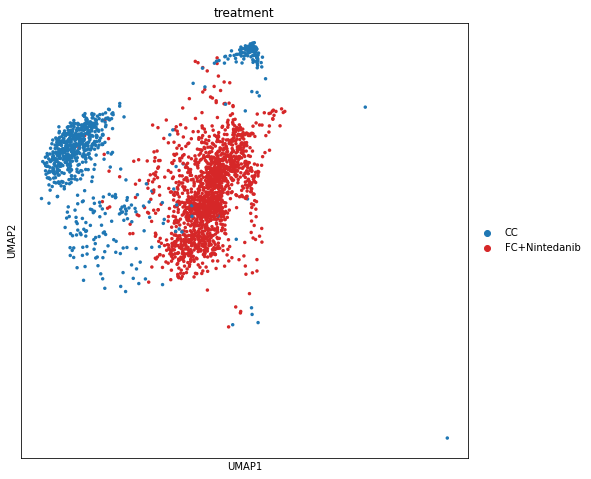

***DGE testing set-up: vascular EC FC+Nintedanib vs. CC***

N cells (total):
2491

N cells (per condition):
FC+Nintedanib    1664
CC                827
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 19:41:52
training location model: True
training scale model: True
iter   0: ll=19391887.917168
caught 450 linalg singular matrix errors
iter   1: ll=17453747.705583, converged: 0.00% (loc: 5.39%, scale update: False), in 3.42sec
iter   2: ll=17017801.852791, converged: 0.00% (loc: 5.39%, scale update: False), in 3.10sec
iter   3: ll=16991746.925946, converged: 0.00% (loc: 5.39%, scale update: False), in 3.03sec
iter   4: ll=16991512.352051, converged: 0.00% (loc: 5.39%, scale update: False), in 3.10sec
iter   5: ll=16991510.416521, converged: 0.00% (loc: 7.41%, scale update: False), in 2.88sec
iter   6: ll=15328236.556775, converged: 0.02% (loc: 0.02%, scale update: True), in 43.49sec
caught 444 linalg singular matrix errors
iter   7: ll=15323463.112675, converged: 0

iter  82: ll=15293813.844561, converged: 99.99% (loc: 99.99%, scale update: False), in 0.18sec
iter  83: ll=15293813.844561, converged: 99.99% (loc: 100.00%, scale update: False), in 0.17sec
iter  84: ll=15293813.844560, converged: 99.99% (loc: 99.99%, scale update: True), in 0.18sec
iter  85: ll=15293813.844559, converged: 99.99% (loc: 99.99%, scale update: False), in 0.17sec
iter  86: ll=15293813.844559, converged: 99.99% (loc: 100.00%, scale update: False), in 0.17sec
iter  87: ll=15293813.844558, converged: 99.99% (loc: 99.99%, scale update: True), in 0.17sec
iter  88: ll=15293813.844557, converged: 99.99% (loc: 99.99%, scale update: False), in 0.17sec
iter  89: ll=15293813.844557, converged: 99.99% (loc: 100.00%, scale update: False), in 0.18sec
iter  90: ll=15293813.844557, converged: 99.99% (loc: 99.99%, scale update: True), in 0.19sec
iter  91: ll=15293813.844557, converged: 99.99% (loc: 99.99%, scale update: False), in 0.16sec
iter  92: ll=15293813.844557, converged: 99.99% (l

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

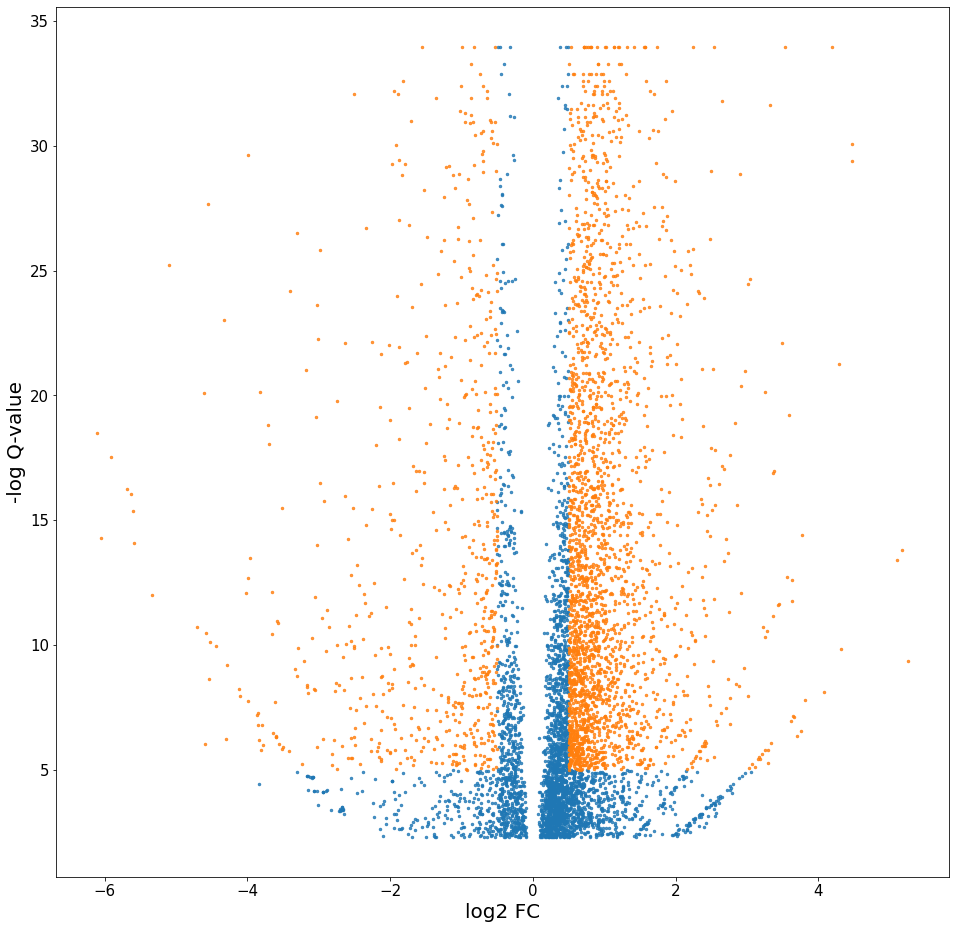

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_vascular_EC_FC+Nintedanib_vs_CC_DGE_results.csv


Performing DGE testing: lymphatic EC FC vs. CC 


filtered out 6886 genes that are detected in less than 5 cells


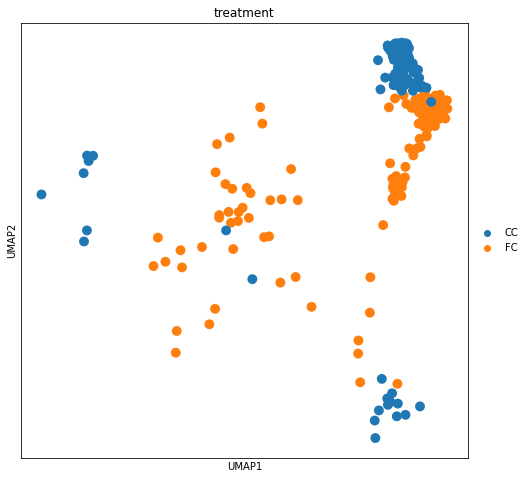

***DGE testing set-up: lymphatic EC FC vs. CC***

N cells (total):
308

N cells (per condition):
CC    154
FC    154
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 19:47:18
training location model: True
training scale model: True
iter   0: ll=5271313.885882
caught 126 linalg singular matrix errors
iter   1: ll=5041977.434402, converged: 0.00% (loc: 7.71%, scale update: False), in 1.26sec
iter   2: ll=4977747.761193, converged: 0.00% (loc: 7.71%, scale update: False), in 1.10sec
iter   3: ll=4970558.060507, converged: 0.00% (loc: 7.71%, scale update: False), in 1.20sec
iter   4: ll=4970149.735860, converged: 0.00% (loc: 7.71%, scale update: False), in 1.08sec
iter   5: ll=4970120.530428, converged: 0.00% (loc: 8.02%, scale update: False), in 1.20sec
iter   6: ll=1861113.844049, converged: 0.00% (loc: 0.00%, scale update: True), in 11.79sec
caught 122 linalg singular matrix errors
iter   7: ll=1849452.527275, converged: 0.00% (loc: 1.63%, scale update: False), in 

iter  84: ll=1788753.090009, converged: 99.49% (loc: 99.49%, scale update: True), in 1.57sec
iter  85: ll=1788753.081345, converged: 99.49% (loc: 99.60%, scale update: False), in 0.46sec
iter  86: ll=1788753.081282, converged: 99.49% (loc: 99.80%, scale update: False), in 0.40sec
iter  87: ll=1788753.081278, converged: 99.49% (loc: 99.90%, scale update: False), in 0.27sec
iter  88: ll=1788753.081277, converged: 99.49% (loc: 99.97%, scale update: False), in 0.21sec
iter  89: ll=1788753.081277, converged: 99.49% (loc: 99.98%, scale update: False), in 0.15sec
iter  90: ll=1788753.072282, converged: 99.59% (loc: 99.59%, scale update: True), in 1.46sec
iter  91: ll=1788753.066792, converged: 99.59% (loc: 99.69%, scale update: False), in 0.53sec
iter  92: ll=1788753.066742, converged: 99.59% (loc: 99.84%, scale update: False), in 0.35sec
iter  93: ll=1788753.066738, converged: 99.59% (loc: 99.94%, scale update: False), in 0.26sec
iter  94: ll=1788753.066737, converged: 99.59% (loc: 99.97%, s

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

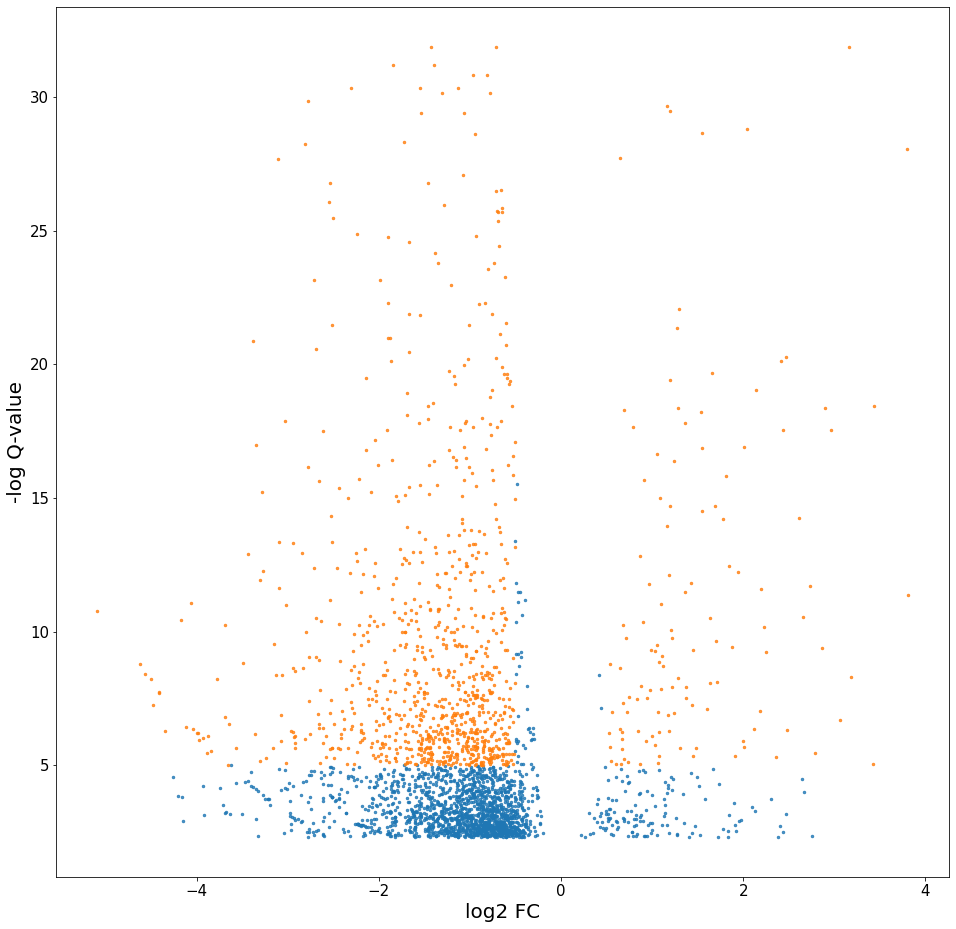

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_lymphatic_EC_FC_vs_CC_DGE_results.csv


Performing DGE testing: lymphatic EC FC+CMP4 vs. CC 


filtered out 7011 genes that are detected in less than 5 cells


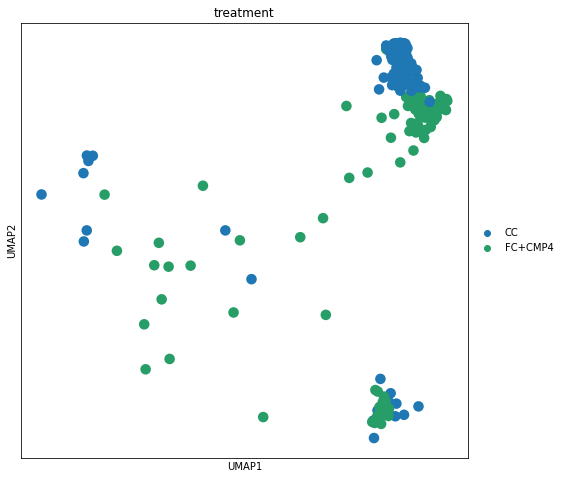

***DGE testing set-up: lymphatic EC FC+CMP4 vs. CC***

N cells (total):
269

N cells (per condition):
CC         154
FC+CMP4    115
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 19:50:25
training location model: True
training scale model: True
iter   0: ll=6181234.103425
caught 95 linalg singular matrix errors
iter   1: ll=5943872.151048, converged: 0.00% (loc: 9.72%, scale update: False), in 1.19sec
iter   2: ll=5884842.693973, converged: 0.00% (loc: 9.72%, scale update: False), in 1.04sec
iter   3: ll=5879688.104515, converged: 0.00% (loc: 9.72%, scale update: False), in 1.22sec
iter   4: ll=5879491.067201, converged: 0.00% (loc: 9.72%, scale update: False), in 1.08sec
iter   5: ll=5879478.418695, converged: 0.00% (loc: 10.09%, scale update: False), in 1.23sec
iter   6: ll=1665437.687695, converged: 0.00% (loc: 0.00%, scale update: True), in 11.85sec
caught 93 linalg singular matrix errors
iter   7: ll=1650882.260887, converged: 0.00% (loc: 1.17%, scale updat

iter  84: ll=1598066.861185, converged: 99.83% (loc: 99.83%, scale update: True), in 1.39sec
iter  85: ll=1598066.860534, converged: 99.83% (loc: 99.88%, scale update: False), in 0.28sec
iter  86: ll=1598066.860509, converged: 99.83% (loc: 99.92%, scale update: False), in 0.23sec
iter  87: ll=1598066.860508, converged: 99.83% (loc: 99.95%, scale update: False), in 0.19sec
iter  88: ll=1598066.860508, converged: 99.83% (loc: 99.97%, scale update: False), in 0.16sec
iter  89: ll=1598066.860508, converged: 99.83% (loc: 99.99%, scale update: False), in 0.16sec
iter  90: ll=1598066.859844, converged: 99.87% (loc: 99.87%, scale update: True), in 1.32sec
iter  91: ll=1598066.859223, converged: 99.87% (loc: 99.89%, scale update: False), in 0.38sec
iter  92: ll=1598066.859201, converged: 99.87% (loc: 99.93%, scale update: False), in 0.21sec
iter  93: ll=1598066.859200, converged: 99.87% (loc: 99.95%, scale update: False), in 0.19sec
iter  94: ll=1598066.859199, converged: 99.87% (loc: 99.97%, s

iter 172: ll=1598035.896456, converged: 99.96% (loc: 99.98%, scale update: False), in 0.16sec
iter 173: ll=1598035.896456, converged: 99.96% (loc: 100.00%, scale update: False), in 0.14sec
iter 174: ll=1598035.894152, converged: 99.96% (loc: 99.96%, scale update: True), in 1.17sec
iter 175: ll=1598035.891537, converged: 99.96% (loc: 99.96%, scale update: False), in 0.17sec
iter 176: ll=1598035.891520, converged: 99.96% (loc: 99.98%, scale update: False), in 0.16sec
iter 177: ll=1598035.891520, converged: 99.96% (loc: 99.98%, scale update: False), in 0.13sec
iter 178: ll=1598035.891520, converged: 99.96% (loc: 100.00%, scale update: False), in 0.15sec
iter 179: ll=1598035.888226, converged: 99.96% (loc: 99.96%, scale update: True), in 1.19sec
iter 180: ll=1598035.884431, converged: 99.96% (loc: 99.96%, scale update: False), in 0.16sec
iter 181: ll=1598035.884416, converged: 99.96% (loc: 99.98%, scale update: False), in 0.17sec
iter 182: ll=1598035.884416, converged: 99.96% (loc: 99.98%,

iter 347: ll=1598035.864718, converged: 99.99% (loc: 99.99%, scale update: False), in 0.12sec
iter 348: ll=1598035.864718, converged: 99.99% (loc: 100.00%, scale update: False), in 0.12sec
iter 349: ll=1598035.864716, converged: 99.99% (loc: 99.99%, scale update: True), in 0.13sec
iter 350: ll=1598035.864715, converged: 99.99% (loc: 99.99%, scale update: False), in 0.25sec
iter 351: ll=1598035.864715, converged: 99.99% (loc: 99.99%, scale update: False), in 0.13sec
iter 352: ll=1598035.864715, converged: 99.99% (loc: 99.99%, scale update: False), in 0.13sec
iter 353: ll=1598035.864715, converged: 99.99% (loc: 100.00%, scale update: False), in 0.12sec
iter 354: ll=1598035.864714, converged: 99.99% (loc: 99.99%, scale update: True), in 0.13sec
iter 355: ll=1598035.864713, converged: 99.99% (loc: 99.99%, scale update: False), in 0.12sec
iter 356: ll=1598035.864713, converged: 99.99% (loc: 99.99%, scale update: False), in 0.13sec
iter 357: ll=1598035.864713, converged: 99.99% (loc: 99.99%,

iter 522: ll=1598035.863902, converged: 99.99% (loc: 99.99%, scale update: False), in 0.12sec
iter 523: ll=1598035.863902, converged: 99.99% (loc: 100.00%, scale update: False), in 0.12sec
iter 524: ll=1598035.863795, converged: 99.99% (loc: 99.99%, scale update: True), in 0.13sec
iter 525: ll=1598035.863675, converged: 99.99% (loc: 99.99%, scale update: False), in 0.12sec
iter 526: ll=1598035.863669, converged: 99.99% (loc: 99.99%, scale update: False), in 0.12sec
iter 527: ll=1598035.863669, converged: 99.99% (loc: 99.99%, scale update: False), in 0.13sec
iter 528: ll=1598035.863669, converged: 99.99% (loc: 99.99%, scale update: False), in 0.12sec
iter 529: ll=1598035.863669, converged: 99.99% (loc: 100.00%, scale update: False), in 0.13sec
iter 530: ll=1598035.863517, converged: 99.99% (loc: 99.99%, scale update: True), in 0.13sec
iter 531: ll=1598035.863343, converged: 99.99% (loc: 99.99%, scale update: False), in 0.13sec
iter 532: ll=1598035.863336, converged: 99.99% (loc: 99.99%,

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

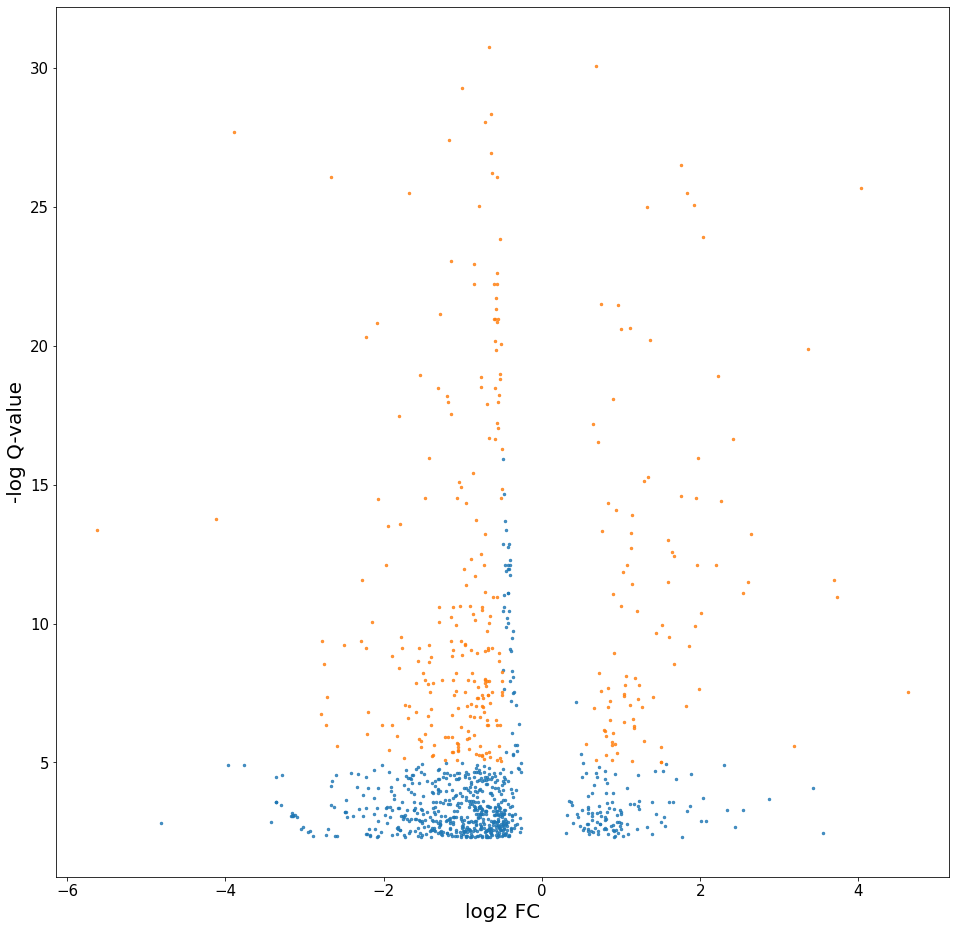

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_lymphatic_EC_FC+CMP4_vs_CC_DGE_results.csv


Performing DGE testing: lymphatic EC FC+Nintedanib vs. CC 


filtered out 6981 genes that are detected in less than 5 cells


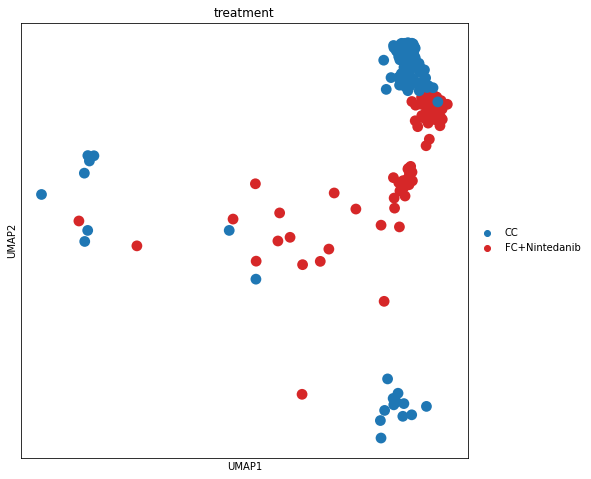

***DGE testing set-up: lymphatic EC FC+Nintedanib vs. CC***

N cells (total):
258

N cells (per condition):
CC               154
FC+Nintedanib    104
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 19:53:58
training location model: True
training scale model: True
iter   0: ll=9274138.459044
caught 105 linalg singular matrix errors
iter   1: ll=8983720.590826, converged: 0.00% (loc: 13.42%, scale update: False), in 1.20sec
iter   2: ll=8901301.879124, converged: 0.00% (loc: 13.42%, scale update: False), in 1.04sec
iter   3: ll=8890933.490019, converged: 0.00% (loc: 13.42%, scale update: False), in 1.18sec
iter   4: ll=8890248.797368, converged: 0.00% (loc: 13.42%, scale update: False), in 1.07sec
iter   5: ll=8890207.941920, converged: 0.00% (loc: 13.63%, scale update: False), in 1.19sec
iter   6: ll=1723862.206172, converged: 0.00% (loc: 0.00%, scale update: True), in 11.91sec
caught 98 linalg singular matrix errors
iter   7: ll=1698775.987045, converged: 0.00% (

iter  84: ll=1621405.230896, converged: 99.81% (loc: 99.81%, scale update: True), in 1.44sec
iter  85: ll=1621405.230404, converged: 99.81% (loc: 99.90%, scale update: False), in 0.28sec
iter  86: ll=1621405.230401, converged: 99.81% (loc: 99.96%, scale update: False), in 0.21sec
iter  87: ll=1621405.230401, converged: 99.81% (loc: 99.98%, scale update: False), in 0.16sec
iter  88: ll=1621405.230401, converged: 99.81% (loc: 99.99%, scale update: False), in 0.14sec
iter  89: ll=1621405.230401, converged: 99.81% (loc: 100.00%, scale update: False), in 0.13sec
iter  90: ll=1621405.229949, converged: 99.89% (loc: 99.89%, scale update: True), in 1.26sec
iter  91: ll=1621405.229550, converged: 99.89% (loc: 99.92%, scale update: False), in 0.23sec
iter  92: ll=1621405.229548, converged: 99.89% (loc: 99.96%, scale update: False), in 0.18sec
iter  93: ll=1621405.229548, converged: 99.89% (loc: 99.98%, scale update: False), in 0.16sec
iter  94: ll=1621405.229548, converged: 99.89% (loc: 100.00%,

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

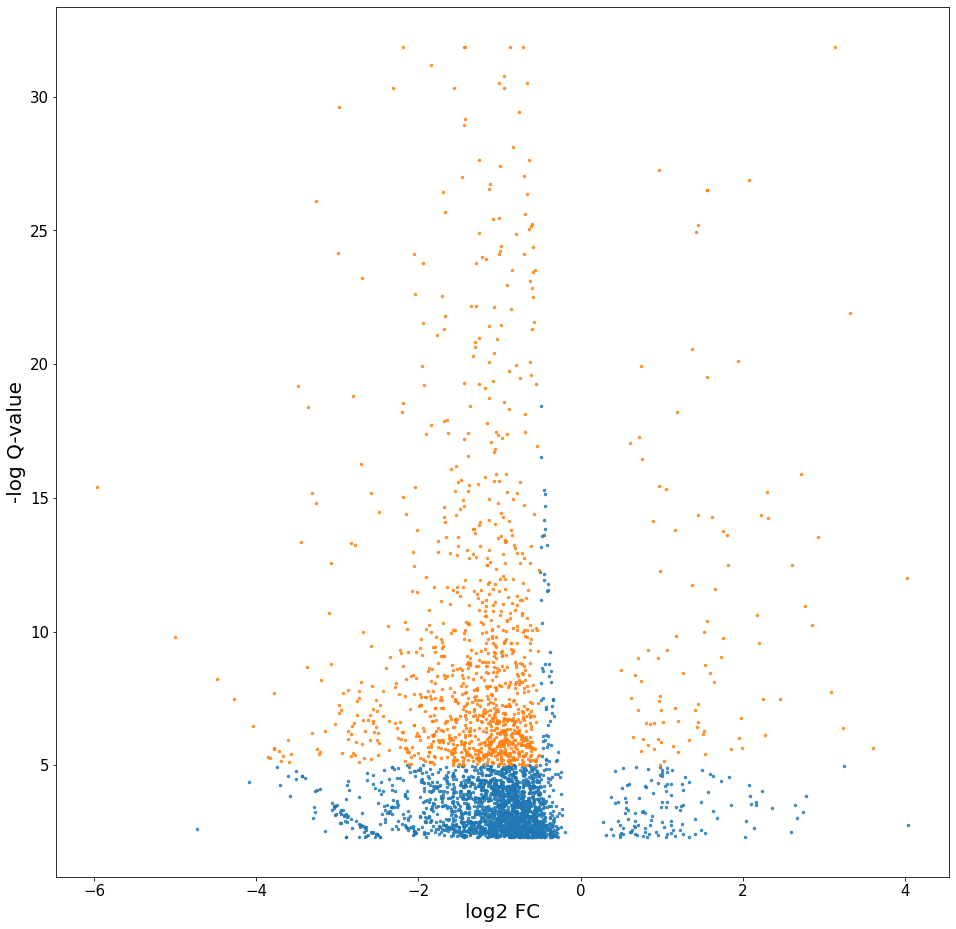

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_lymphatic_EC_FC+Nintedanib_vs_CC_DGE_results.csv


Performing DGE testing: Fibroblasts FC vs. CC 


filtered out 2848 genes that are detected in less than 5 cells


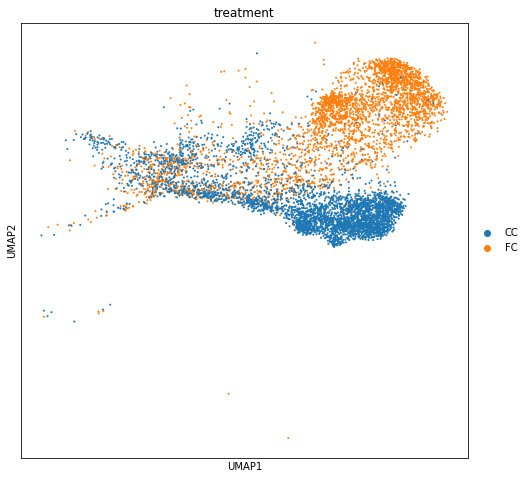

***DGE testing set-up: Fibroblasts FC vs. CC***

N cells (total):
7264

N cells (per condition):
CC    3953
FC    3311
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 19:56:23
training location model: True
training scale model: True
iter   0: ll=49621998.747681
caught 207 linalg singular matrix errors
iter   1: ll=45978661.627870, converged: 0.00% (loc: 2.88%, scale update: False), in 7.85sec
iter   2: ll=44968563.948445, converged: 0.00% (loc: 2.88%, scale update: False), in 6.68sec
iter   3: ll=44881300.608502, converged: 0.00% (loc: 2.88%, scale update: False), in 7.17sec
iter   4: ll=44879493.263695, converged: 0.00% (loc: 2.88%, scale update: False), in 6.94sec
iter   5: ll=44879438.447071, converged: 0.00% (loc: 3.28%, scale update: False), in 6.87sec
iter   6: ll=41890078.464080, converged: 0.01% (loc: 0.01%, scale update: True), in 142.63sec
caught 205 linalg singular matrix errors
iter   7: ll=41864894.882950, converged: 0.01% (loc: 2.66%, scale update: 

iter  83: ll=41849100.785717, converged: 99.94% (loc: 99.99%, scale update: False), in 0.27sec
iter  84: ll=41849100.785377, converged: 99.94% (loc: 99.94%, scale update: True), in 7.92sec
iter  85: ll=41849100.785077, converged: 99.94% (loc: 99.95%, scale update: False), in 0.38sec
iter  86: ll=41849100.785045, converged: 99.94% (loc: 99.97%, scale update: False), in 0.35sec
iter  87: ll=41849100.785041, converged: 99.94% (loc: 99.99%, scale update: False), in 0.32sec
iter  88: ll=41849100.785041, converged: 99.94% (loc: 99.99%, scale update: False), in 0.26sec
iter  89: ll=41849100.785041, converged: 99.94% (loc: 99.99%, scale update: False), in 0.27sec
iter  90: ll=41849100.784708, converged: 99.95% (loc: 99.95%, scale update: True), in 7.61sec
iter  91: ll=41849100.784408, converged: 99.95% (loc: 99.97%, scale update: False), in 0.35sec
iter  92: ll=41849100.784376, converged: 99.95% (loc: 99.97%, scale update: False), in 0.35sec
iter  93: ll=41849100.784372, converged: 99.95% (loc

iter 170: ll=41849100.734975, converged: 99.99% (loc: 99.99%, scale update: False), in 0.24sec
iter 171: ll=41849100.734925, converged: 99.99% (loc: 99.99%, scale update: False), in 0.25sec
iter 172: ll=41849100.734921, converged: 99.99% (loc: 99.99%, scale update: False), in 0.23sec
iter 173: ll=41849100.734921, converged: 99.99% (loc: 99.99%, scale update: False), in 0.24sec
iter 174: ll=41849100.722661, converged: 99.99% (loc: 99.99%, scale update: True), in 0.27sec
iter 175: ll=41849100.708418, converged: 99.99% (loc: 99.99%, scale update: False), in 0.25sec
iter 176: ll=41849100.707431, converged: 99.99% (loc: 99.99%, scale update: False), in 0.27sec
iter 177: ll=41849100.707369, converged: 99.99% (loc: 99.99%, scale update: False), in 0.25sec
iter 178: ll=41849100.707365, converged: 99.99% (loc: 99.99%, scale update: False), in 0.25sec
iter 179: ll=41849100.707365, converged: 99.99% (loc: 99.99%, scale update: False), in 0.25sec
iter 180: ll=41849100.687252, converged: 99.99% (lo

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

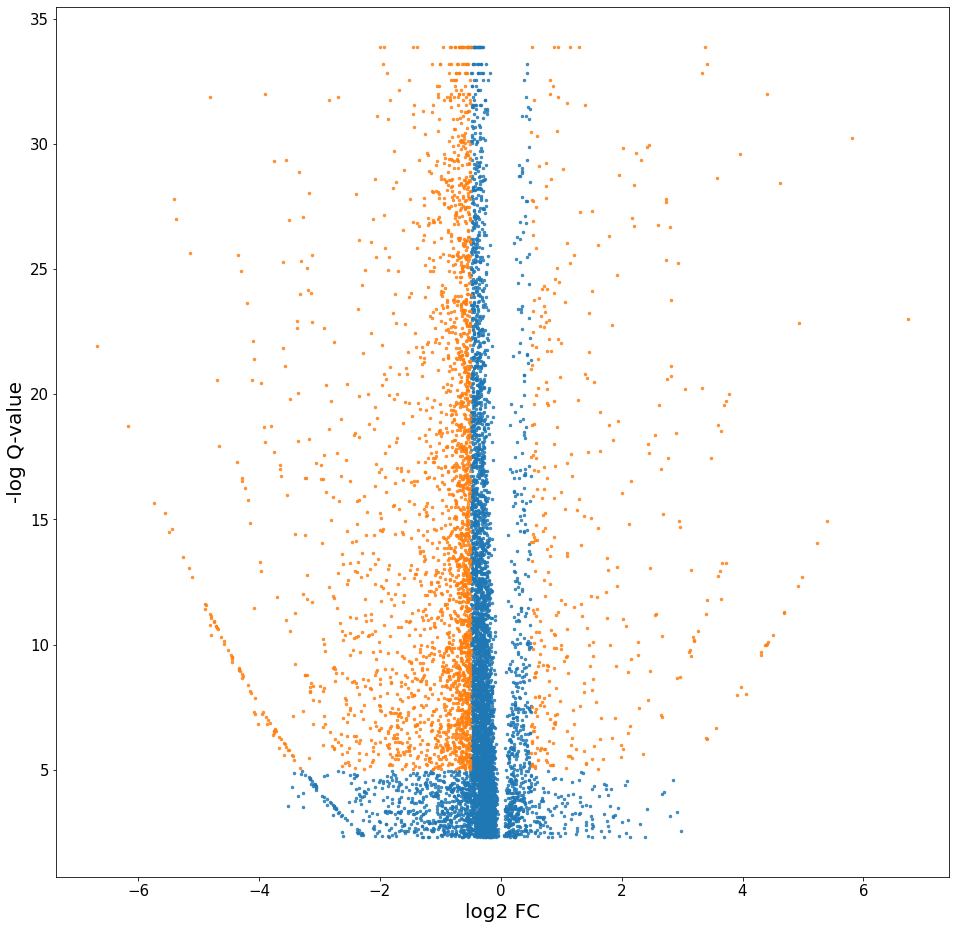

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_Fibroblasts_FC_vs_CC_DGE_results.csv


Performing DGE testing: Fibroblasts FC+CMP4 vs. CC 


filtered out 2888 genes that are detected in less than 5 cells


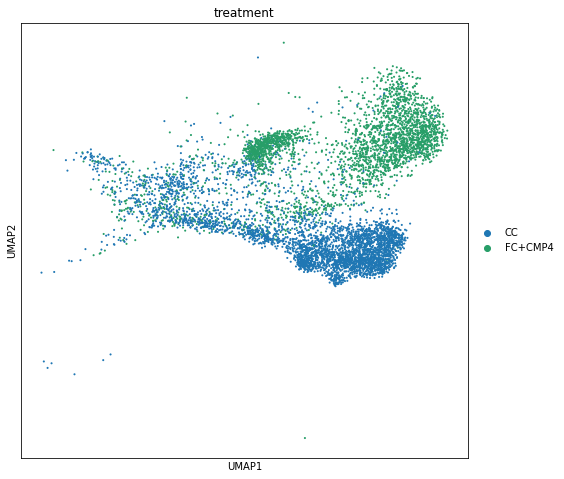

***DGE testing set-up: Fibroblasts FC+CMP4 vs. CC***

N cells (total):
7032

N cells (per condition):
CC         3953
FC+CMP4    3079
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 20:14:37
training location model: True
training scale model: True
iter   0: ll=48173939.184762
caught 205 linalg singular matrix errors
iter   1: ll=44414399.666364, converged: 0.00% (loc: 3.26%, scale update: False), in 7.29sec
iter   2: ll=43432737.447390, converged: 0.00% (loc: 3.26%, scale update: False), in 6.66sec
iter   3: ll=43360770.334531, converged: 0.00% (loc: 3.26%, scale update: False), in 6.68sec
iter   4: ll=43359845.749317, converged: 0.00% (loc: 3.26%, scale update: False), in 6.97sec
iter   5: ll=43359817.531954, converged: 0.00% (loc: 4.15%, scale update: False), in 6.87sec
iter   6: ll=40252257.895606, converged: 0.01% (loc: 0.01%, scale update: True), in 143.08sec
caught 202 linalg singular matrix errors
iter   7: ll=40230958.388333, converged: 0.01% (loc: 2.44%,

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

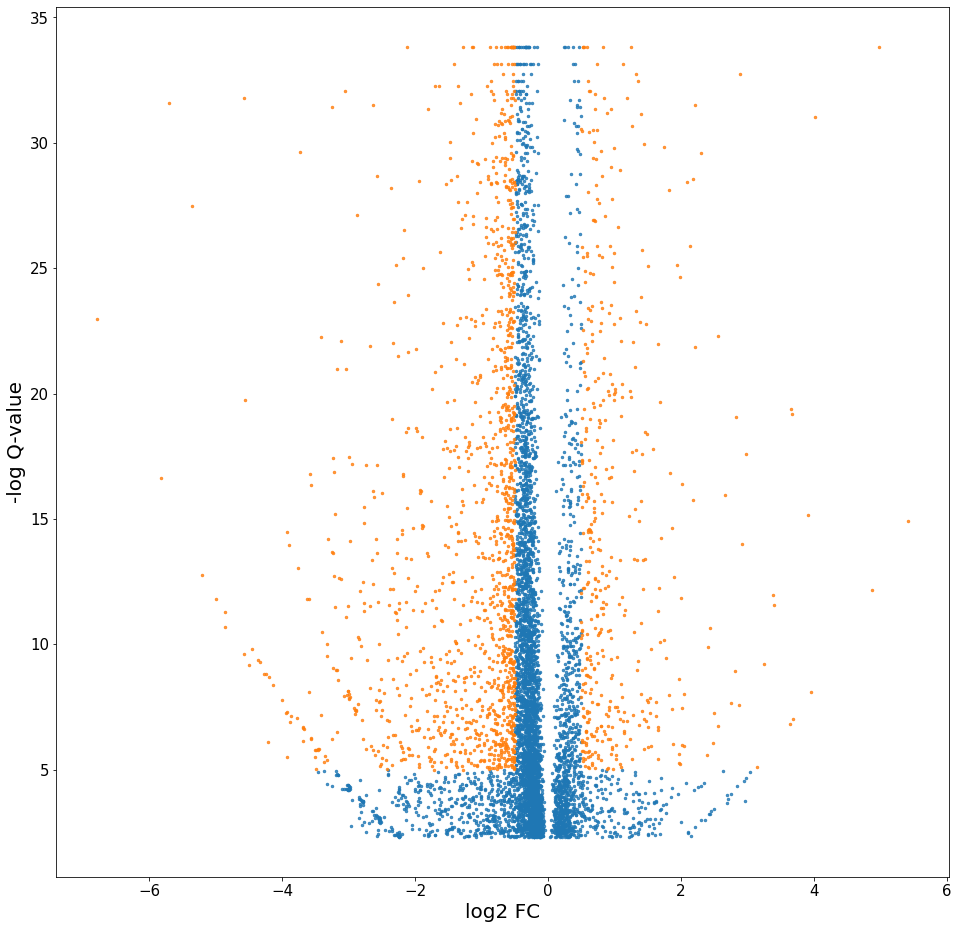

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_Fibroblasts_FC+CMP4_vs_CC_DGE_results.csv


Performing DGE testing: Fibroblasts FC+Nintedanib vs. CC 


filtered out 2737 genes that are detected in less than 5 cells


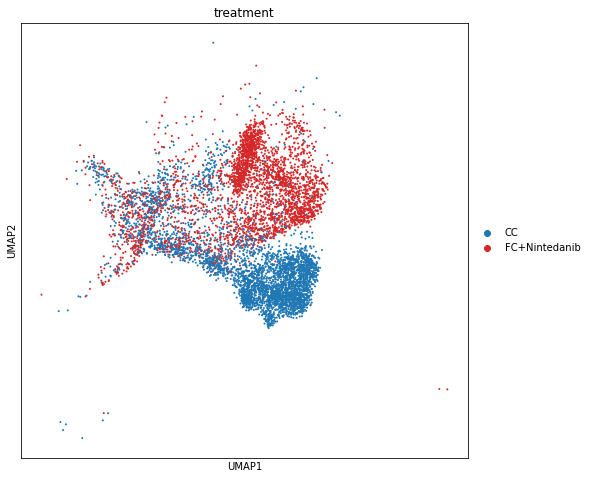

***DGE testing set-up: Fibroblasts FC+Nintedanib vs. CC***

N cells (total):
7354

N cells (per condition):
CC               3953
FC+Nintedanib    3401
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 20:29:47
training location model: True
training scale model: True
iter   0: ll=50596496.125047
caught 119 linalg singular matrix errors
iter   1: ll=46933891.674236, converged: 0.00% (loc: 2.03%, scale update: False), in 6.85sec
iter   2: ll=45931353.174787, converged: 0.00% (loc: 2.03%, scale update: False), in 7.14sec
iter   3: ll=45852193.203448, converged: 0.00% (loc: 2.03%, scale update: False), in 7.09sec
iter   4: ll=45851140.636286, converged: 0.00% (loc: 2.03%, scale update: False), in 6.98sec
iter   5: ll=45851116.057114, converged: 0.00% (loc: 3.03%, scale update: False), in 6.92sec
iter   6: ll=43164936.468764, converged: 0.00% (loc: 0.00%, scale update: True), in 147.81sec
caught 119 linalg singular matrix errors
iter   7: ll=43142451.134094, converged: 

iter  82: ll=43133090.778789, converged: 99.99% (loc: 99.99%, scale update: False), in 0.26sec
iter  83: ll=43133090.778789, converged: 99.99% (loc: 100.00%, scale update: False), in 0.28sec
iter  84: ll=43133090.778714, converged: 99.99% (loc: 99.99%, scale update: True), in 0.38sec
iter  85: ll=43133090.778663, converged: 99.99% (loc: 99.99%, scale update: False), in 0.42sec
iter  86: ll=43133090.778661, converged: 99.99% (loc: 99.99%, scale update: False), in 0.31sec
iter  87: ll=43133090.778661, converged: 99.99% (loc: 99.99%, scale update: False), in 0.27sec
iter  88: ll=43133090.778661, converged: 99.99% (loc: 100.00%, scale update: False), in 0.28sec
iter  89: ll=43133090.778624, converged: 99.99% (loc: 99.99%, scale update: True), in 0.34sec
iter  90: ll=43133090.778599, converged: 99.99% (loc: 99.99%, scale update: False), in 0.30sec
iter  91: ll=43133090.778598, converged: 99.99% (loc: 99.99%, scale update: False), in 0.29sec
iter  92: ll=43133090.778598, converged: 99.99% (l

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

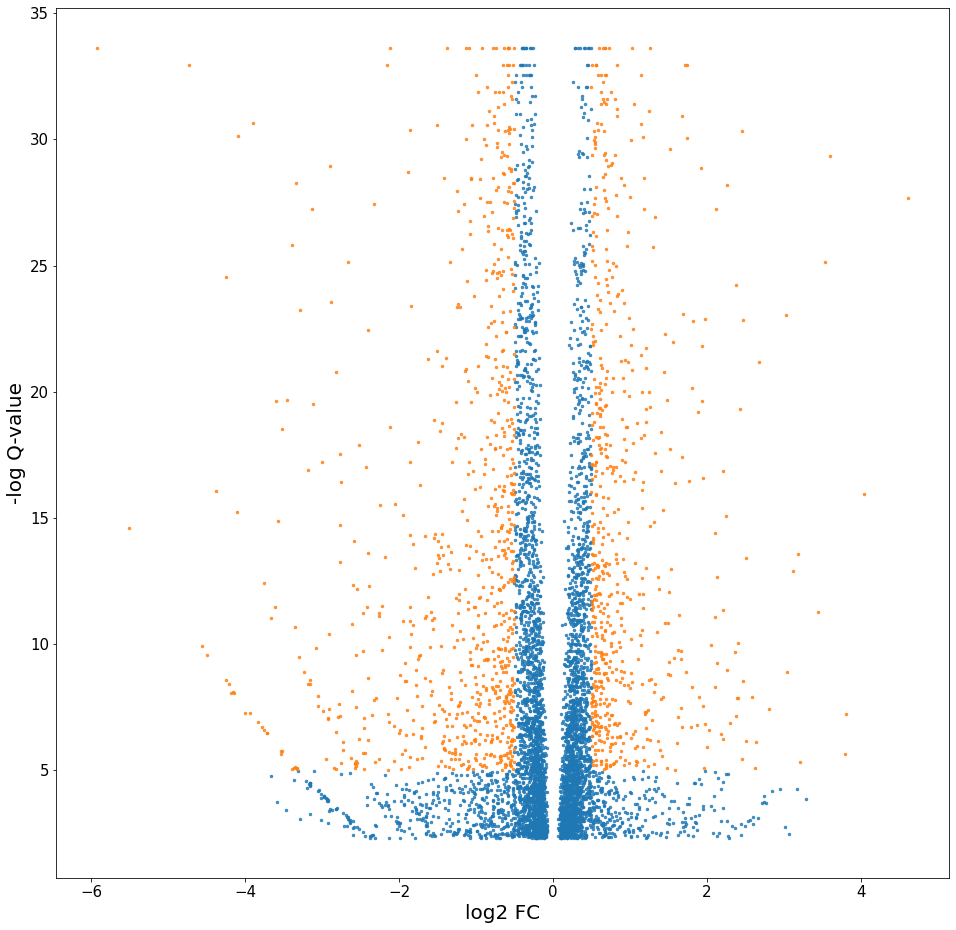

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_Fibroblasts_FC+Nintedanib_vs_CC_DGE_results.csv


Performing DGE testing: SMC/Pericytes FC vs. CC 


filtered out 4307 genes that are detected in less than 5 cells


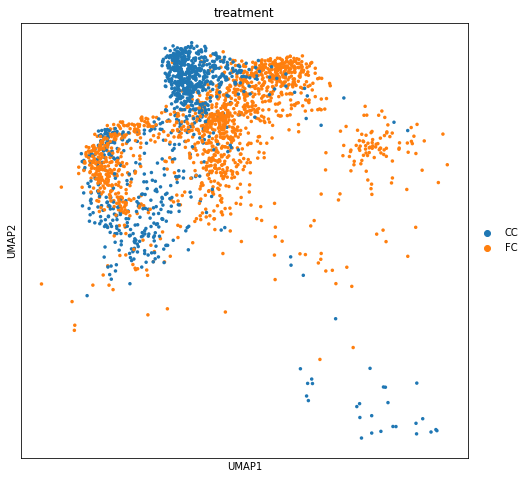

***DGE testing set-up: SMC/Pericytes FC vs. CC***

N cells (total):
2457

N cells (per condition):
FC    1482
CC     975
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 20:46:05
training location model: True
training scale model: True
iter   0: ll=22069137.609660
caught 226 linalg singular matrix errors
iter   1: ll=20114958.964975, converged: 0.00% (loc: 4.72%, scale update: False), in 3.11sec
iter   2: ll=19594392.036797, converged: 0.00% (loc: 4.72%, scale update: False), in 3.44sec
iter   3: ll=19549087.993754, converged: 0.00% (loc: 4.72%, scale update: False), in 3.21sec
iter   4: ll=19548053.200135, converged: 0.00% (loc: 4.72%, scale update: False), in 3.00sec
iter   5: ll=19548029.951400, converged: 0.00% (loc: 5.12%, scale update: False), in 3.18sec
iter   6: ll=16396234.934412, converged: 0.02% (loc: 0.02%, scale update: True), in 42.47sec
caught 220 linalg singular matrix errors
iter   7: ll=16387798.250266, converged: 0.02% (loc: 2.10%, scale update:

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

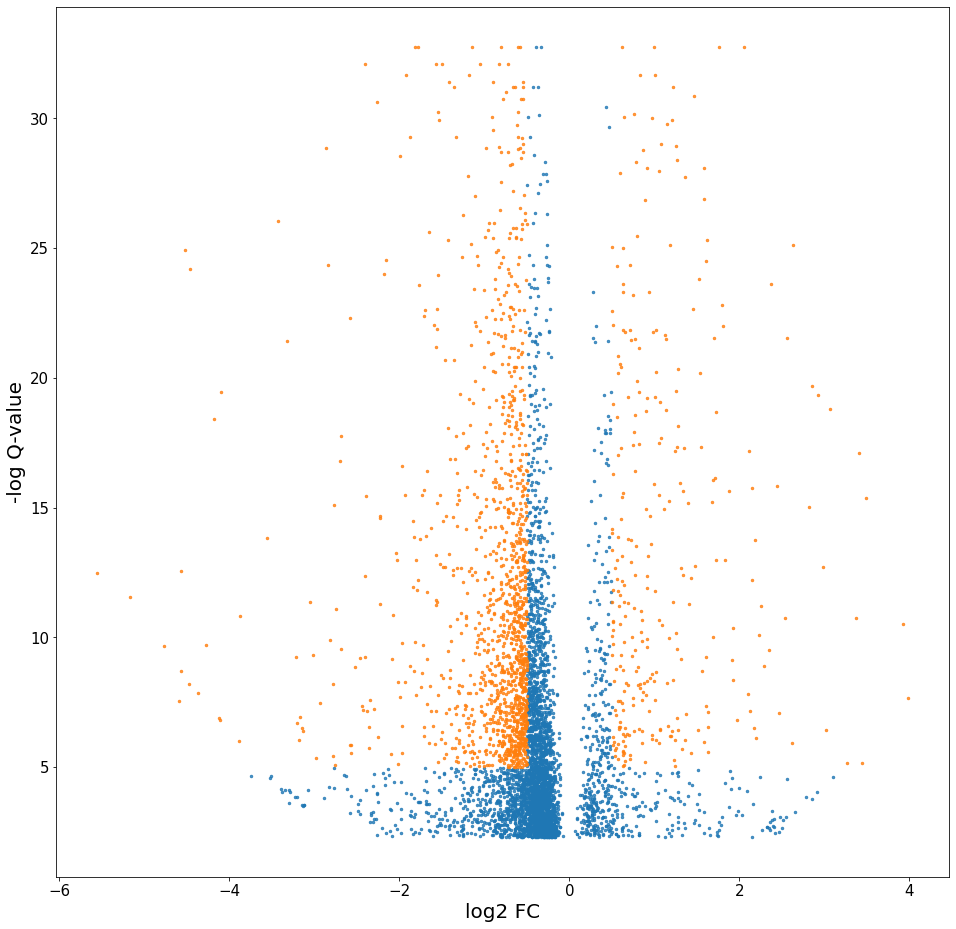

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_SMC_Pericytes_FC_vs_CC_DGE_results.csv


Performing DGE testing: SMC/Pericytes FC+CMP4 vs. CC 


filtered out 4720 genes that are detected in less than 5 cells


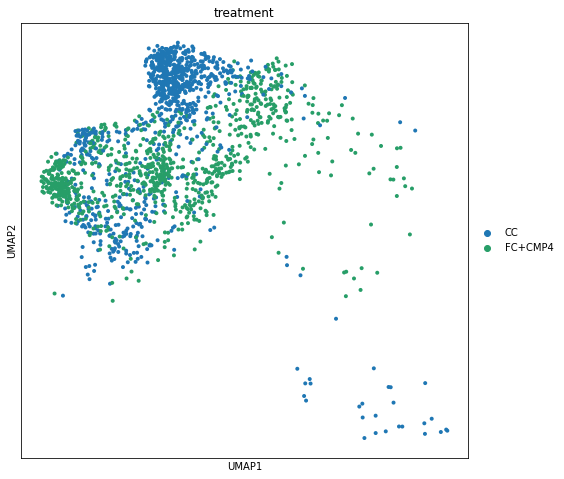

***DGE testing set-up: SMC/Pericytes FC+CMP4 vs. CC***

N cells (total):
1893

N cells (per condition):
CC         975
FC+CMP4    918
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 20:51:33
training location model: True
training scale model: True
iter   0: ll=14471592.422213
caught 101 linalg singular matrix errors
iter   1: ll=13085340.649114, converged: 0.00% (loc: 2.59%, scale update: False), in 2.91sec
iter   2: ll=12756803.935500, converged: 0.00% (loc: 2.59%, scale update: False), in 2.87sec
iter   3: ll=12735465.174283, converged: 0.00% (loc: 2.59%, scale update: False), in 2.78sec
iter   4: ll=12735251.223258, converged: 0.00% (loc: 2.59%, scale update: False), in 2.95sec
iter   5: ll=12735249.895114, converged: 0.00% (loc: 3.74%, scale update: False), in 2.76sec
iter   6: ll=11706697.514868, converged: 0.00% (loc: 0.00%, scale update: True), in 34.60sec
caught 101 linalg singular matrix errors
iter   7: ll=11702270.291687, converged: 0.00% (loc: 0.95%, 

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

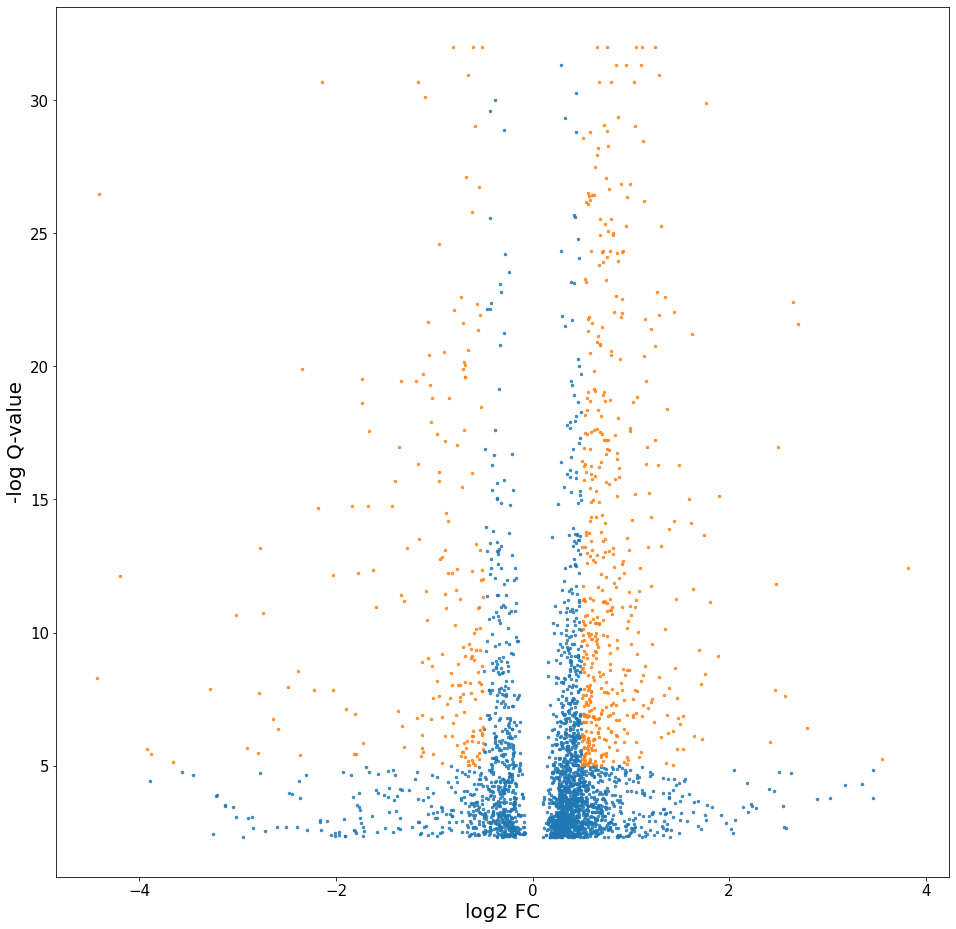

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_SMC_Pericytes_FC+CMP4_vs_CC_DGE_results.csv


Performing DGE testing: SMC/Pericytes FC+Nintedanib vs. CC 


filtered out 4482 genes that are detected in less than 5 cells


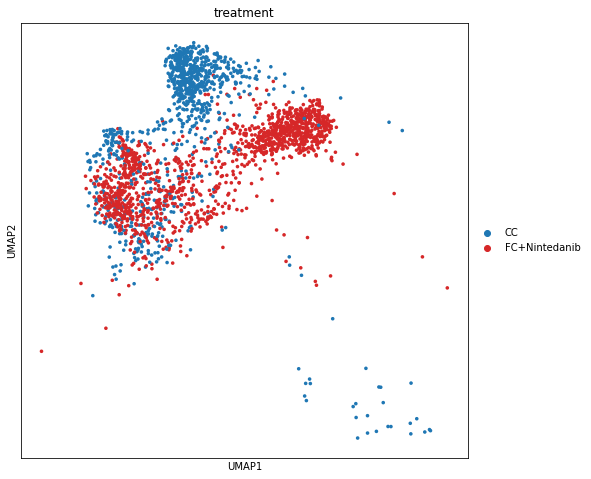

***DGE testing set-up: SMC/Pericytes FC+Nintedanib vs. CC***

N cells (total):
2333

N cells (per condition):
FC+Nintedanib    1358
CC                975
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 20:55:48
training location model: True
training scale model: True
iter   0: ll=20510017.292963
caught 177 linalg singular matrix errors
iter   1: ll=18492362.698715, converged: 0.00% (loc: 4.00%, scale update: False), in 3.35sec
iter   2: ll=17993734.768201, converged: 0.00% (loc: 4.00%, scale update: False), in 3.17sec
iter   3: ll=17956795.218169, converged: 0.00% (loc: 4.00%, scale update: False), in 3.35sec
iter   4: ll=17956246.257807, converged: 0.00% (loc: 4.00%, scale update: False), in 3.14sec
iter   5: ll=17956241.291548, converged: 0.00% (loc: 4.53%, scale update: False), in 3.30sec
iter   6: ll=15719868.768107, converged: 0.01% (loc: 0.01%, scale update: True), in 43.55sec
caught 172 linalg singular matrix errors
iter   7: ll=15713305.031748, converged:

iter  82: ll=15685364.471951, converged: 99.98% (loc: 100.00%, scale update: False), in 0.19sec
iter  83: ll=15685364.471863, converged: 99.98% (loc: 99.98%, scale update: True), in 0.22sec
iter  84: ll=15685364.471783, converged: 99.98% (loc: 99.98%, scale update: False), in 0.17sec
iter  85: ll=15685364.471782, converged: 99.98% (loc: 99.99%, scale update: False), in 0.19sec
iter  86: ll=15685364.471782, converged: 99.98% (loc: 100.00%, scale update: False), in 0.17sec
iter  87: ll=15685364.471707, converged: 99.98% (loc: 99.98%, scale update: True), in 0.22sec
iter  88: ll=15685364.471638, converged: 99.98% (loc: 99.98%, scale update: False), in 0.18sec
iter  89: ll=15685364.471638, converged: 99.98% (loc: 99.99%, scale update: False), in 0.19sec
iter  90: ll=15685364.471638, converged: 99.98% (loc: 100.00%, scale update: False), in 0.18sec
iter  91: ll=15685358.735711, converged: 99.98% (loc: 99.98%, scale update: True), in 0.23sec
iter  92: ll=15685358.254741, converged: 99.98% (l

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

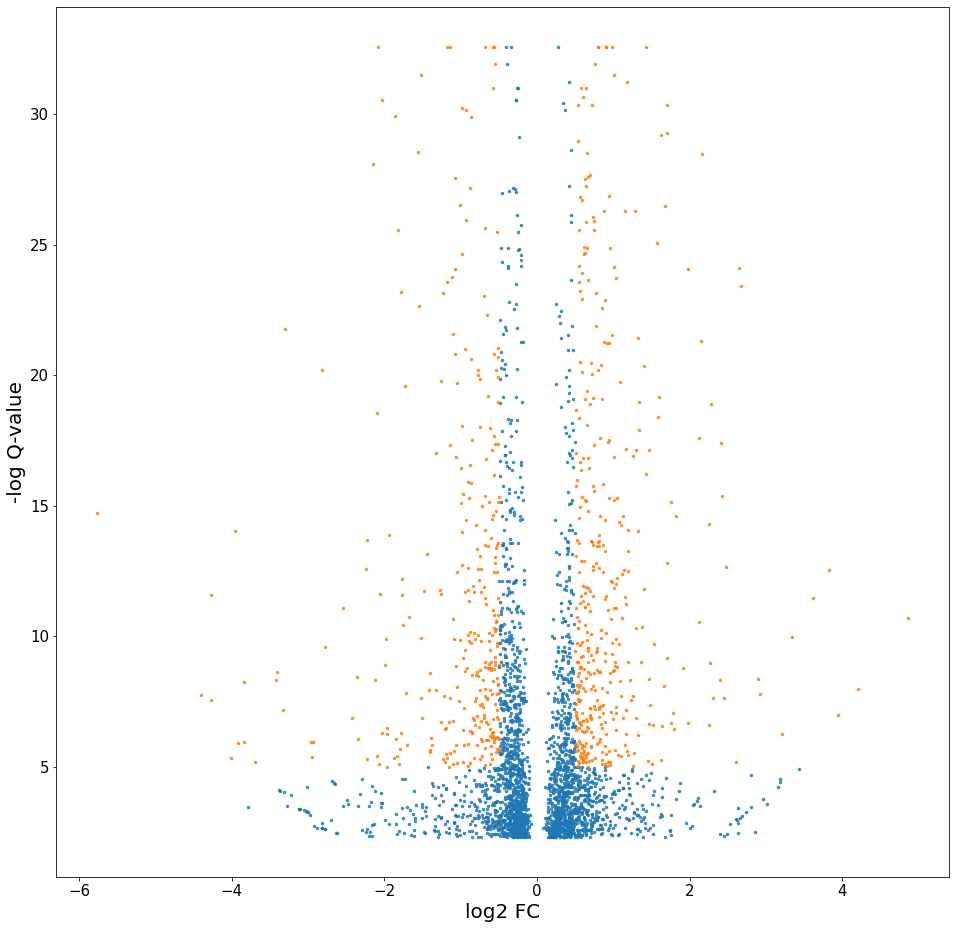

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_SMC_Pericytes_FC+Nintedanib_vs_CC_DGE_results.csv


Performing DGE testing: Macrophages FC vs. CC 


filtered out 4260 genes that are detected in less than 5 cells


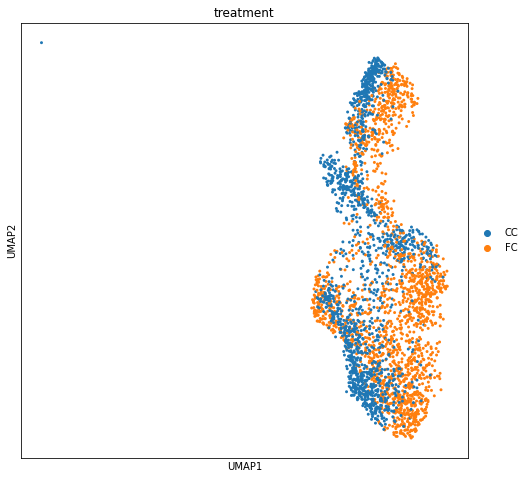

***DGE testing set-up: Macrophages FC vs. CC***

N cells (total):
3434

N cells (per condition):
FC    1894
CC    1540
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 21:01:01
training location model: True
training scale model: True
iter   0: ll=54534354.178763
caught 74 linalg singular matrix errors
iter   1: ll=51731875.622772, converged: 0.00% (loc: 15.24%, scale update: False), in 4.26sec
iter   2: ll=50881574.162673, converged: 0.00% (loc: 15.24%, scale update: False), in 3.36sec
iter   3: ll=50766926.698776, converged: 0.00% (loc: 15.24%, scale update: False), in 3.82sec
iter   4: ll=50757244.752526, converged: 0.00% (loc: 15.24%, scale update: False), in 3.70sec
iter   5: ll=50755863.457884, converged: 0.00% (loc: 15.50%, scale update: False), in 3.37sec
iter   6: ll=21894577.333468, converged: 0.00% (loc: 0.00%, scale update: True), in 70.12sec
caught 71 linalg singular matrix errors
iter   7: ll=21859723.185798, converged: 0.00% (loc: 1.60%, scale update

iter  82: ll=21708922.725929, converged: 99.95% (loc: 99.98%, scale update: False), in 0.23sec
iter  83: ll=21708922.725929, converged: 99.95% (loc: 99.98%, scale update: False), in 0.21sec
iter  84: ll=21708922.725727, converged: 99.96% (loc: 99.96%, scale update: True), in 6.09sec
iter  85: ll=21708922.725566, converged: 99.96% (loc: 99.96%, scale update: False), in 0.21sec
iter  86: ll=21708922.725534, converged: 99.96% (loc: 99.97%, scale update: False), in 0.21sec
iter  87: ll=21708922.725528, converged: 99.96% (loc: 99.97%, scale update: False), in 0.20sec
iter  88: ll=21708922.725527, converged: 99.96% (loc: 99.98%, scale update: False), in 0.22sec
iter  89: ll=21708922.725527, converged: 99.96% (loc: 99.99%, scale update: False), in 0.21sec
iter  90: ll=21708922.725336, converged: 99.96% (loc: 99.96%, scale update: True), in 5.65sec
iter  91: ll=21708922.725178, converged: 99.96% (loc: 99.96%, scale update: False), in 0.22sec
iter  92: ll=21708922.725148, converged: 99.96% (loc

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

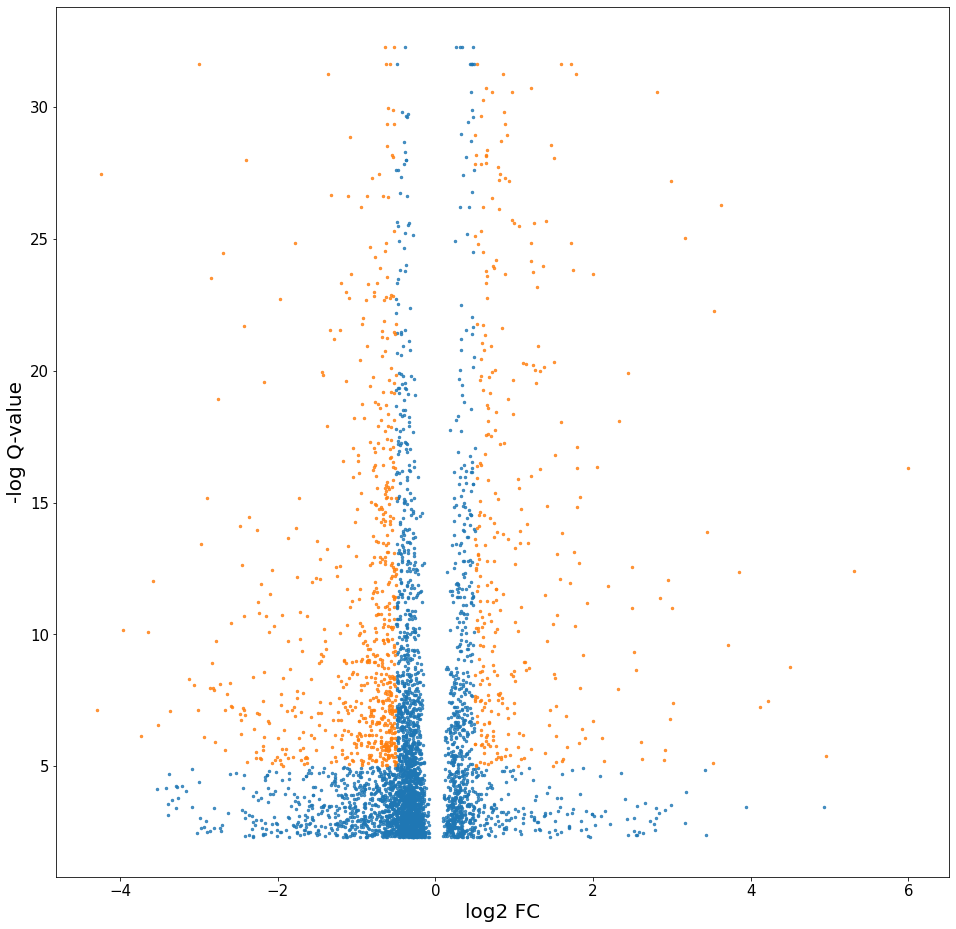

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_Macrophages_FC_vs_CC_DGE_results.csv


Performing DGE testing: Macrophages FC+CMP4 vs. CC 


filtered out 4271 genes that are detected in less than 5 cells


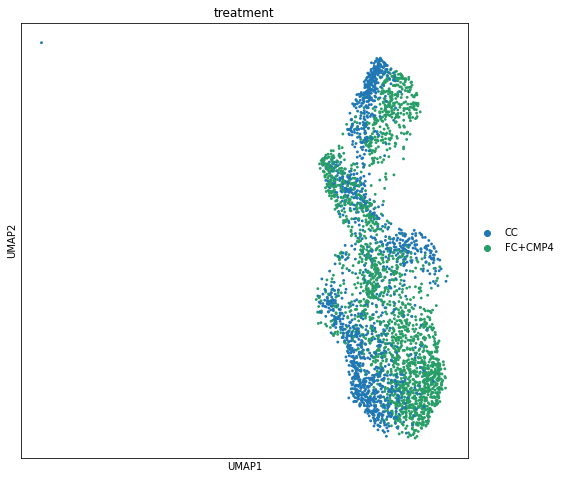

***DGE testing set-up: Macrophages FC+CMP4 vs. CC***

N cells (total):
3719

N cells (per condition):
FC+CMP4    2179
CC         1540
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 21:10:16
training location model: True
training scale model: True
iter   0: ll=53738317.165548
caught 91 linalg singular matrix errors
iter   1: ll=50758595.434007, converged: 0.00% (loc: 13.38%, scale update: False), in 4.93sec
iter   2: ll=49835093.506133, converged: 0.00% (loc: 13.38%, scale update: False), in 3.65sec
iter   3: ll=49706867.527950, converged: 0.00% (loc: 13.38%, scale update: False), in 4.30sec
iter   4: ll=49697164.021333, converged: 0.00% (loc: 13.38%, scale update: False), in 3.52sec
iter   5: ll=49696145.379273, converged: 0.00% (loc: 13.72%, scale update: False), in 3.99sec
iter   6: ll=23410639.783607, converged: 0.00% (loc: 0.00%, scale update: True), in 77.00sec
caught 87 linalg singular matrix errors
iter   7: ll=23380901.269048, converged: 0.00% (loc: 1.39

iter  83: ll=23275743.724311, converged: 99.87% (loc: 99.98%, scale update: False), in 0.22sec
iter  84: ll=23275743.723493, converged: 99.90% (loc: 99.90%, scale update: True), in 6.63sec
iter  85: ll=23275743.722801, converged: 99.90% (loc: 99.92%, scale update: False), in 0.39sec
iter  86: ll=23275743.722748, converged: 99.90% (loc: 99.98%, scale update: False), in 0.25sec
iter  87: ll=23275743.722744, converged: 99.90% (loc: 99.98%, scale update: False), in 0.21sec
iter  88: ll=23275743.722744, converged: 99.90% (loc: 99.98%, scale update: False), in 0.21sec
iter  89: ll=23275743.722744, converged: 99.90% (loc: 99.99%, scale update: False), in 0.22sec
iter  90: ll=23275743.722040, converged: 99.92% (loc: 99.92%, scale update: True), in 6.44sec
iter  91: ll=23275743.721428, converged: 99.92% (loc: 99.95%, scale update: False), in 0.25sec
iter  92: ll=23275743.721383, converged: 99.92% (loc: 99.98%, scale update: False), in 0.23sec
iter  93: ll=23275743.721379, converged: 99.92% (loc

iter 170: ll=23275743.690479, converged: 99.98% (loc: 99.99%, scale update: False), in 0.18sec
iter 171: ll=23275743.690476, converged: 99.98% (loc: 99.99%, scale update: False), in 0.19sec
iter 172: ll=23275743.690476, converged: 99.98% (loc: 99.99%, scale update: False), in 0.20sec
iter 173: ll=23275743.690476, converged: 99.98% (loc: 100.00%, scale update: False), in 0.19sec
iter 174: ll=23275743.685632, converged: 99.99% (loc: 99.99%, scale update: True), in 0.26sec
iter 175: ll=23275743.679857, converged: 99.99% (loc: 99.99%, scale update: False), in 0.20sec
iter 176: ll=23275743.679722, converged: 99.99% (loc: 99.99%, scale update: False), in 0.20sec
iter 177: ll=23275743.679720, converged: 99.99% (loc: 99.99%, scale update: False), in 0.21sec
iter 178: ll=23275743.679719, converged: 99.99% (loc: 99.99%, scale update: False), in 0.20sec
iter 179: ll=23275743.679719, converged: 99.99% (loc: 100.00%, scale update: False), in 0.20sec
iter 180: ll=23275743.671829, converged: 99.99% (

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

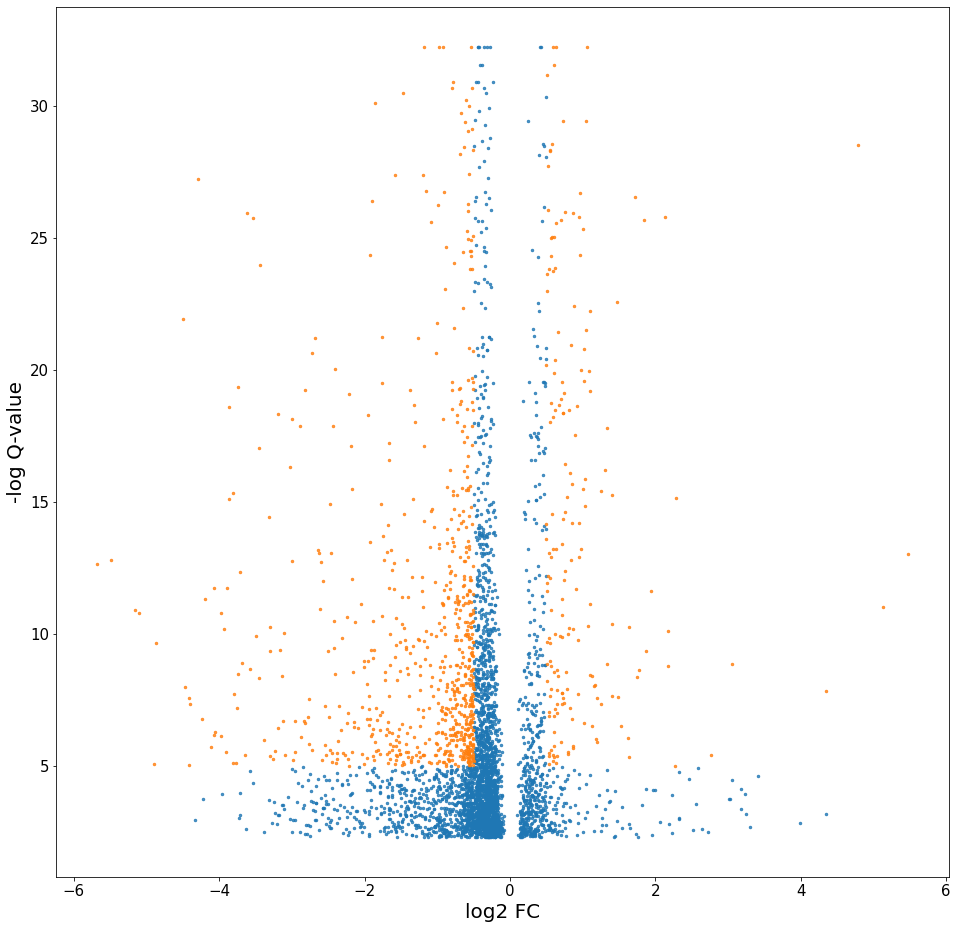

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_Macrophages_FC+CMP4_vs_CC_DGE_results.csv


Performing DGE testing: Macrophages FC+Nintedanib vs. CC 


filtered out 4724 genes that are detected in less than 5 cells


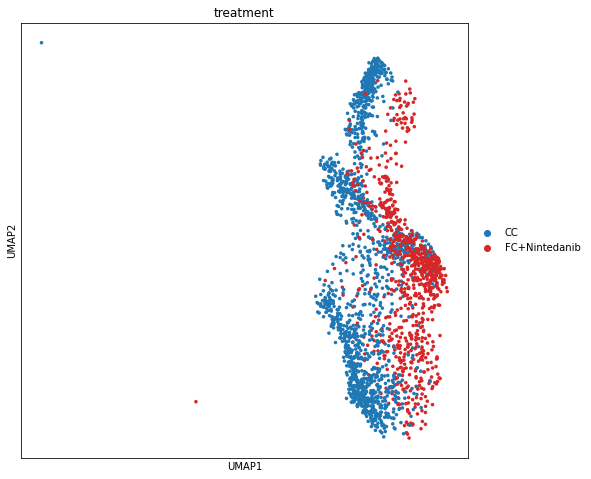

***DGE testing set-up: Macrophages FC+Nintedanib vs. CC***

N cells (total):
2372

N cells (per condition):
CC               1540
FC+Nintedanib     832
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 21:20:14
training location model: True
training scale model: True
iter   0: ll=48444705.481305
caught 539 linalg singular matrix errors
iter   1: ll=46035016.124050, converged: 0.00% (loc: 15.53%, scale update: False), in 3.39sec
iter   2: ll=45250866.171542, converged: 0.00% (loc: 15.53%, scale update: False), in 3.03sec
iter   3: ll=45115255.403875, converged: 0.00% (loc: 15.53%, scale update: False), in 3.25sec
iter   4: ll=45097337.099330, converged: 0.00% (loc: 15.53%, scale update: False), in 2.84sec
iter   5: ll=45094341.984897, converged: 0.00% (loc: 15.71%, scale update: False), in 2.81sec
iter   6: ll=16438535.958264, converged: 0.00% (loc: 0.00%, scale update: True), in 42.11sec
caught 526 linalg singular matrix errors
iter   7: ll=16395989.595382, converg

iter  83: ll=16331252.905827, converged: 99.93% (loc: 99.99%, scale update: False), in 0.19sec
iter  84: ll=16331252.905622, converged: 99.94% (loc: 99.94%, scale update: True), in 5.24sec
iter  85: ll=16331252.905481, converged: 99.94% (loc: 99.94%, scale update: False), in 0.22sec
iter  86: ll=16331252.905472, converged: 99.94% (loc: 99.96%, scale update: False), in 0.22sec
iter  87: ll=16331252.905471, converged: 99.94% (loc: 99.97%, scale update: False), in 0.21sec
iter  88: ll=16331252.905470, converged: 99.94% (loc: 99.99%, scale update: False), in 0.23sec
iter  89: ll=16331252.905470, converged: 99.94% (loc: 99.99%, scale update: False), in 0.16sec
iter  90: ll=16331252.905360, converged: 99.94% (loc: 99.94%, scale update: True), in 4.93sec
iter  91: ll=16331252.905284, converged: 99.94% (loc: 99.95%, scale update: False), in 0.20sec
iter  92: ll=16331252.905278, converged: 99.94% (loc: 99.96%, scale update: False), in 0.19sec
iter  93: ll=16331252.905278, converged: 99.94% (loc

iter 170: ll=16331252.905041, converged: 99.98% (loc: 100.00%, scale update: False), in 0.17sec
iter 171: ll=16331252.905041, converged: 99.99% (loc: 99.99%, scale update: True), in 0.22sec
iter 172: ll=16331252.905041, converged: 99.99% (loc: 99.99%, scale update: False), in 0.17sec
iter 173: ll=16331252.905041, converged: 99.99% (loc: 100.00%, scale update: False), in 0.17sec
iter 174: ll=16331252.905041, converged: 99.99% (loc: 99.99%, scale update: True), in 0.19sec
iter 175: ll=16331252.905041, converged: 99.99% (loc: 100.00%, scale update: False), in 0.17sec
iter 176: ll=16331252.905041, converged: 99.99% (loc: 99.99%, scale update: True), in 0.19sec
iter 177: ll=16331252.905041, converged: 99.99% (loc: 100.00%, scale update: False), in 0.17sec
iter 178: ll=16331252.905041, converged: 100.00% (loc: 100.00%, scale update: True), in 0.18sec
Finished Diffxpy Calculation:	13-01-2022 21:27:00
Writing DGE results table


Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

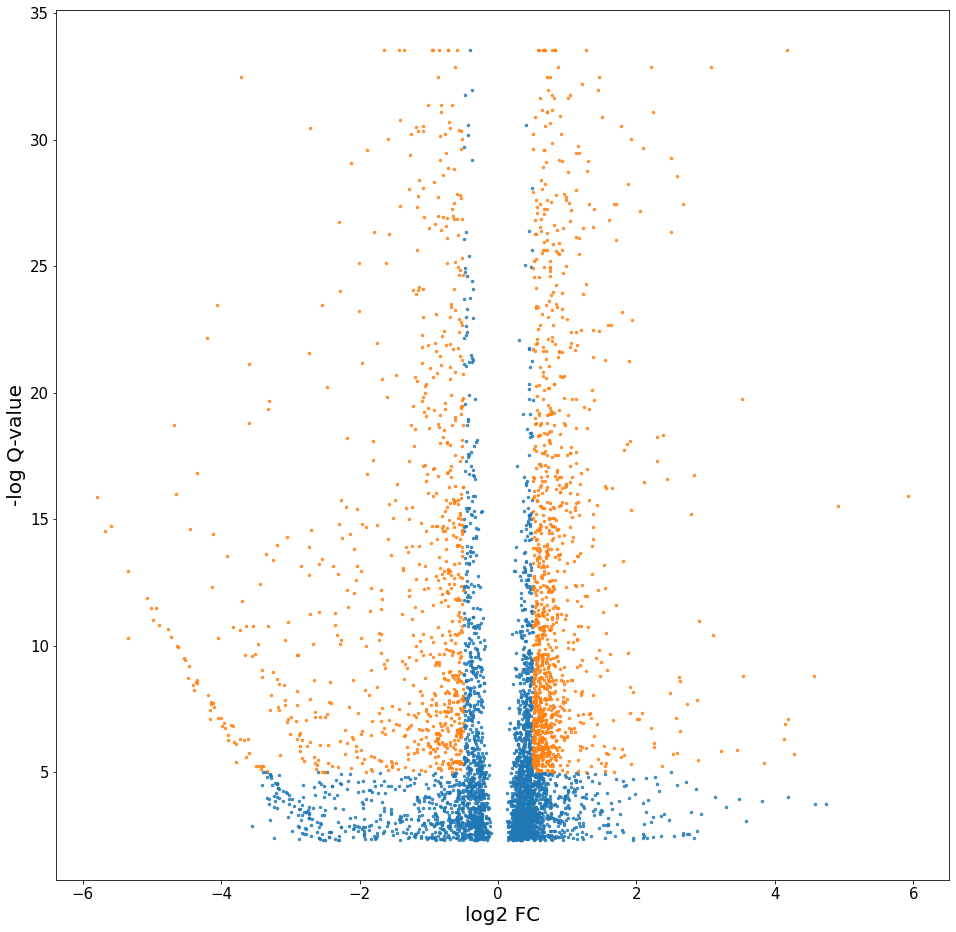

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_Macrophages_FC+Nintedanib_vs_CC_DGE_results.csv


Performing DGE testing: DC FC vs. CC 


filtered out 8876 genes that are detected in less than 5 cells


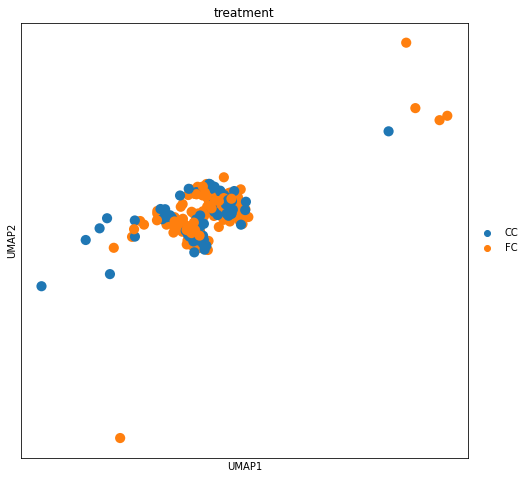

***DGE testing set-up: DC FC vs. CC***

N cells (total):
290

N cells (per condition):
FC    218
CC     72
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 21:27:02
training location model: True
training scale model: True
iter   0: ll=1629449.382892
caught 311 linalg singular matrix errors
iter   1: ll=1440091.188132, converged: 0.00% (loc: 4.18%, scale update: False), in 1.07sec
iter   2: ll=1400830.801859, converged: 0.00% (loc: 4.18%, scale update: False), in 0.92sec
iter   3: ll=1398693.928576, converged: 0.00% (loc: 4.18%, scale update: False), in 0.93sec
iter   4: ll=1398673.512922, converged: 0.00% (loc: 4.18%, scale update: False), in 1.06sec
iter   5: ll=1398673.364097, converged: 0.00% (loc: 6.68%, scale update: False), in 0.91sec
iter   6: ll=1244622.076178, converged: 0.02% (loc: 0.02%, scale update: True), in 10.87sec
caught 309 linalg singular matrix errors
iter   7: ll=1244329.629475, converged: 0.02% (loc: 4.06%, scale update: False), in 0.93sec
it

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

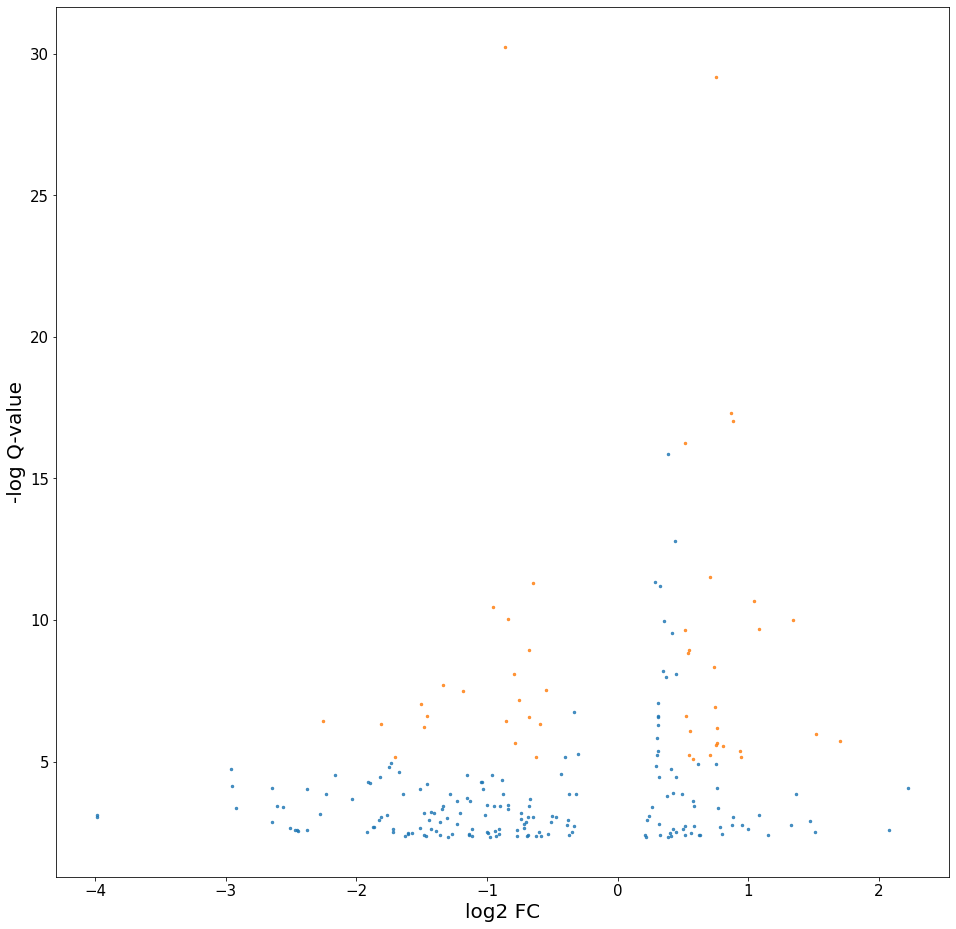

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_DC_FC_vs_CC_DGE_results.csv


Performing DGE testing: DC FC+CMP4 vs. CC 


filtered out 9753 genes that are detected in less than 5 cells


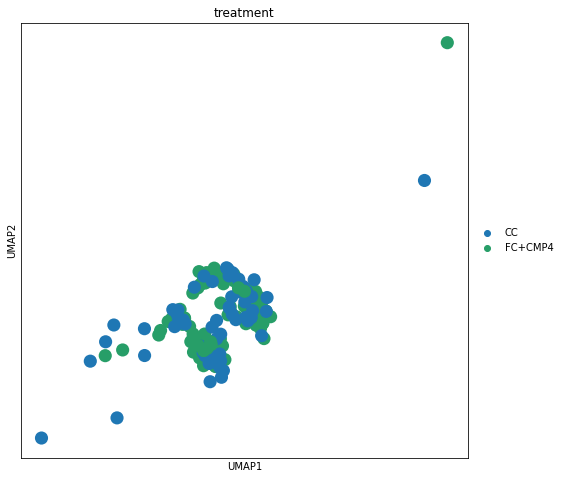

***DGE testing set-up: DC FC+CMP4 vs. CC***

N cells (total):
174

N cells (per condition):
FC+CMP4    102
CC          72
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 21:28:26
training location model: True
training scale model: True
iter   0: ll=1248660.353951
caught 115 linalg singular matrix errors
iter   1: ll=1135943.149561, converged: 0.00% (loc: 3.25%, scale update: False), in 0.80sec
iter   2: ll=1112054.260444, converged: 0.00% (loc: 3.25%, scale update: False), in 0.80sec
iter   3: ll=1110680.275234, converged: 0.00% (loc: 3.25%, scale update: False), in 0.96sec
iter   4: ll=1110664.071885, converged: 0.00% (loc: 3.25%, scale update: False), in 0.81sec
iter   5: ll=1110663.865253, converged: 0.00% (loc: 5.84%, scale update: False), in 0.81sec
iter   6: ll=744904.535793, converged: 0.00% (loc: 0.00%, scale update: True), in 8.88sec
caught 115 linalg singular matrix errors
iter   7: ll=744417.073603, converged: 0.00% (loc: 2.02%, scale update: False), i

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

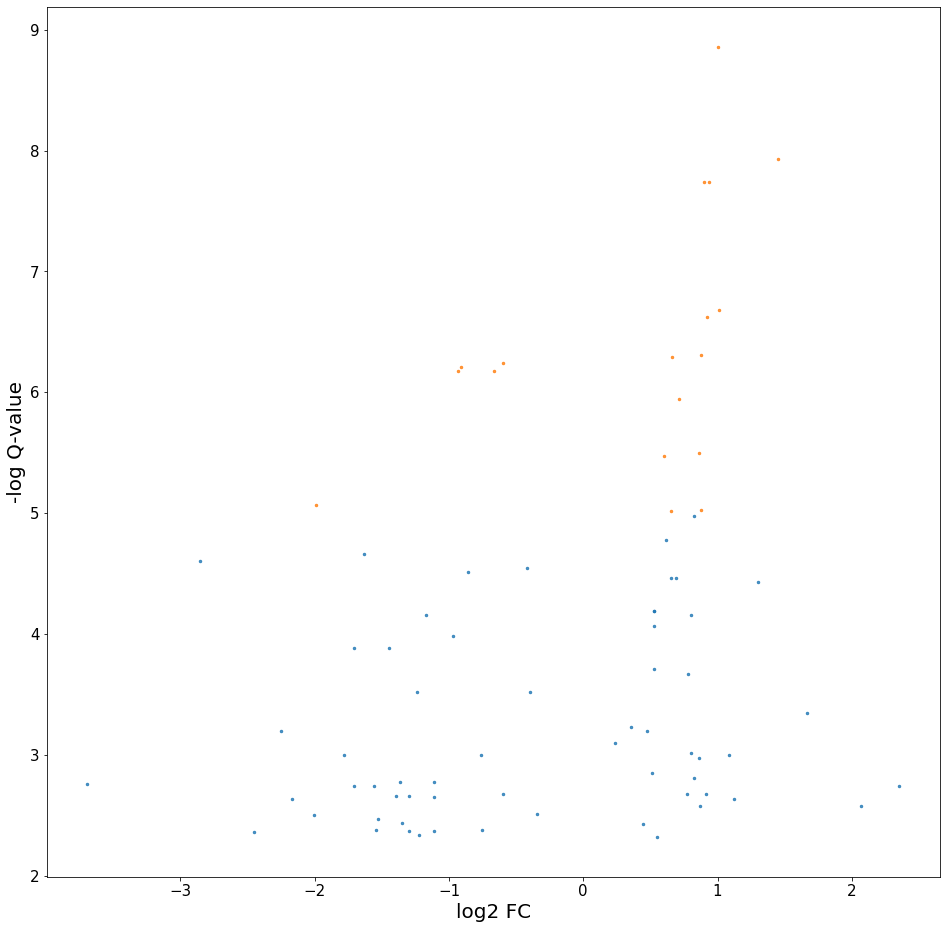

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_DC_FC+CMP4_vs_CC_DGE_results.csv


Performing DGE testing: DC FC+Nintedanib vs. CC 


filtered out 8793 genes that are detected in less than 5 cells


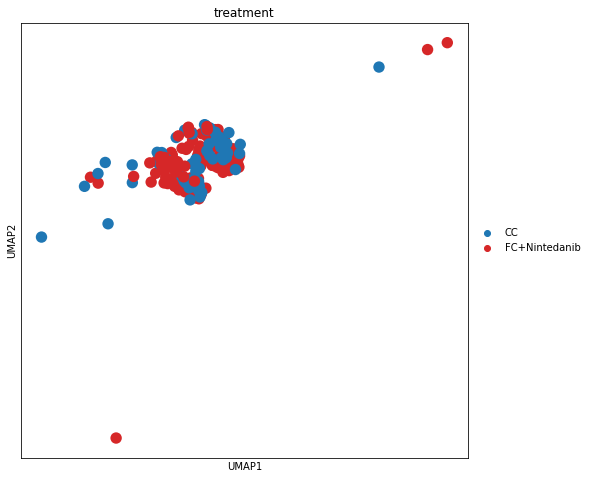

***DGE testing set-up: DC FC+Nintedanib vs. CC***

N cells (total):
231

N cells (per condition):
FC+Nintedanib    159
CC                72
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 21:29:40
training location model: True
training scale model: True
iter   0: ll=2903386.498310
caught 359 linalg singular matrix errors
iter   1: ll=2711940.762987, converged: 0.00% (loc: 7.85%, scale update: False), in 0.91sec
iter   2: ll=2672166.358833, converged: 0.00% (loc: 7.85%, scale update: False), in 0.89sec
iter   3: ll=2669820.196596, converged: 0.00% (loc: 7.85%, scale update: False), in 1.05sec
iter   4: ll=2669792.342006, converged: 0.00% (loc: 7.85%, scale update: False), in 0.90sec
iter   5: ll=2669792.121159, converged: 0.00% (loc: 9.51%, scale update: False), in 1.03sec
iter   6: ll=1149433.559716, converged: 0.05% (loc: 0.05%, scale update: True), in 10.66sec
caught 354 linalg singular matrix errors
iter   7: ll=1148339.792547, converged: 0.05% (loc: 6.12%, sc

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

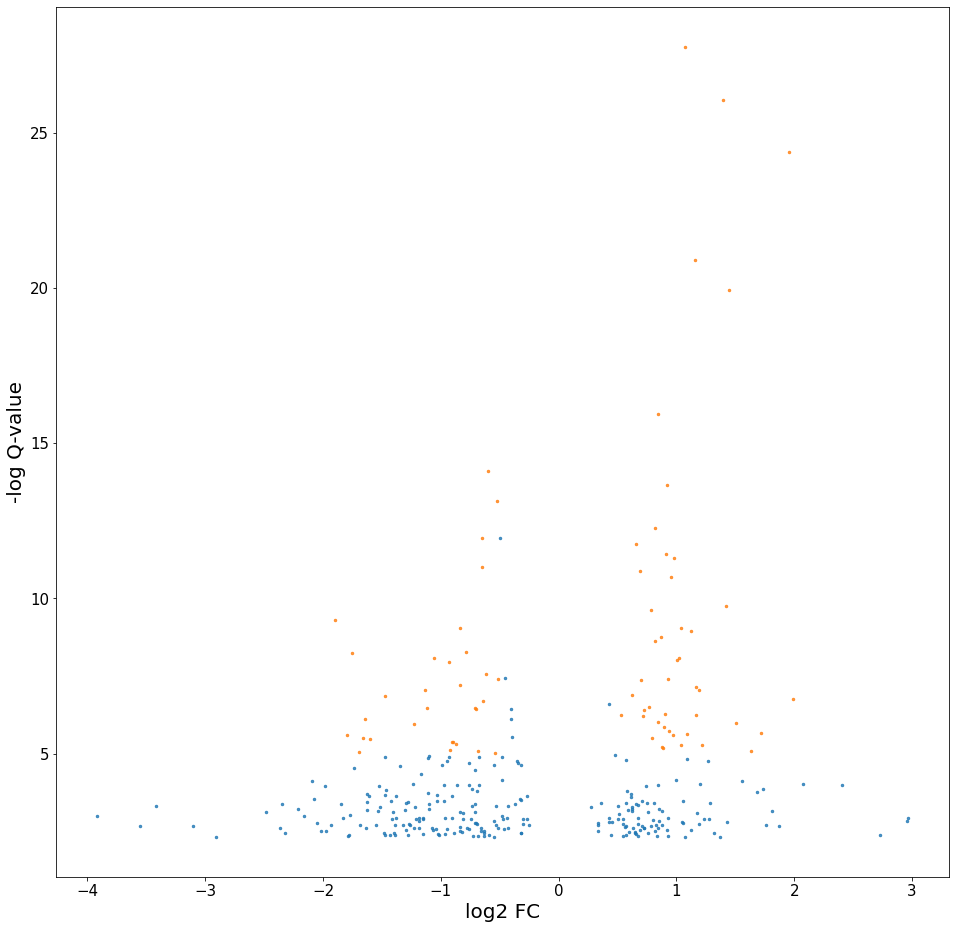

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_DC_FC+Nintedanib_vs_CC_DGE_results.csv


Performing DGE testing: Mast cells FC vs. CC 


filtered out 6207 genes that are detected in less than 5 cells


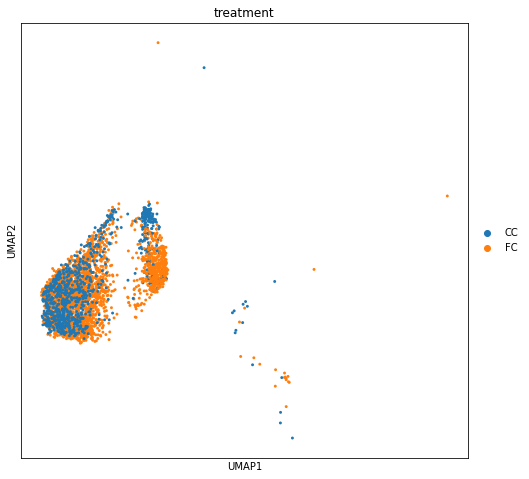

***DGE testing set-up: Mast cells FC vs. CC***

N cells (total):
3535

N cells (per condition):
FC    2660
CC     875
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 21:31:04
training location model: True
training scale model: True
iter   0: ll=12080517.528224
caught 182 linalg singular matrix errors
iter   1: ll=10554203.782570, converged: 0.00% (loc: 1.63%, scale update: False), in 3.50sec
iter   2: ll=10096214.341169, converged: 0.00% (loc: 1.63%, scale update: False), in 2.73sec
iter   3: ll=10056343.493458, converged: 0.00% (loc: 1.63%, scale update: False), in 3.17sec
iter   4: ll=10056007.101928, converged: 0.00% (loc: 1.64%, scale update: False), in 3.48sec
iter   5: ll=10056006.947764, converged: 0.00% (loc: 5.06%, scale update: False), in 3.51sec
iter   6: ll=9600469.241879, converged: 0.03% (loc: 0.03%, scale update: True), in 60.37sec
caught 179 linalg singular matrix errors
iter   7: ll=9599153.196305, converged: 0.03% (loc: 3.60%, scale update: Fals

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

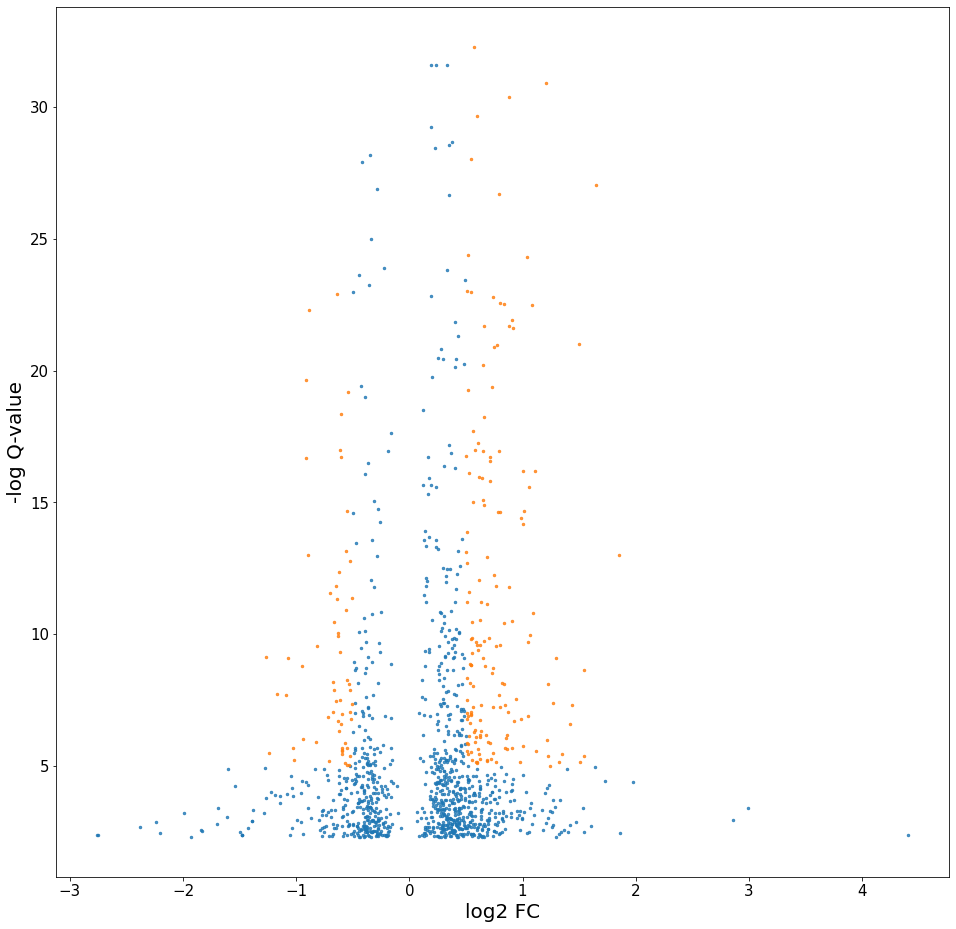

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_Mast_cells_FC_vs_CC_DGE_results.csv


Performing DGE testing: Mast cells FC+CMP4 vs. CC 


filtered out 6835 genes that are detected in less than 5 cells


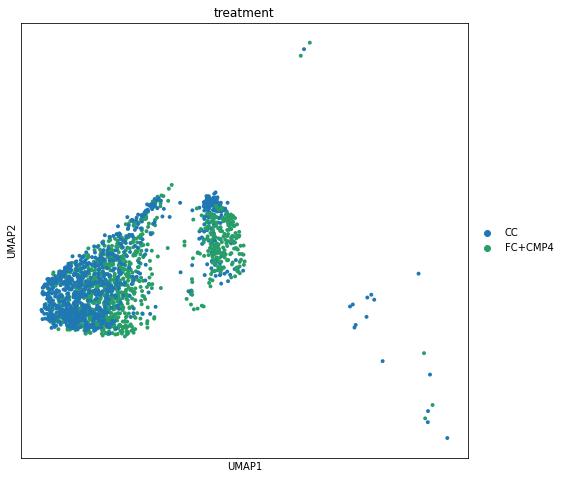

***DGE testing set-up: Mast cells FC+CMP4 vs. CC***

N cells (total):
1939

N cells (per condition):
FC+CMP4    1064
CC          875
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 21:35:45
training location model: True
training scale model: True
iter   0: ll=6760555.538610
caught 51 linalg singular matrix errors
iter   1: ll=5935246.451158, converged: 0.00% (loc: 0.49%, scale update: False), in 2.49sec
iter   2: ll=5695437.789870, converged: 0.00% (loc: 0.49%, scale update: False), in 2.78sec
iter   3: ll=5675436.297864, converged: 0.00% (loc: 0.49%, scale update: False), in 2.56sec
iter   4: ll=5675269.223445, converged: 0.00% (loc: 0.49%, scale update: False), in 2.79sec
iter   5: ll=5675269.137807, converged: 0.00% (loc: 5.69%, scale update: False), in 2.50sec
iter   6: ll=5409167.170542, converged: 0.03% (loc: 0.03%, scale update: True), in 31.25sec
caught 48 linalg singular matrix errors
iter   7: ll=5408615.541494, converged: 0.03% (loc: 2.91%, scale updat

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

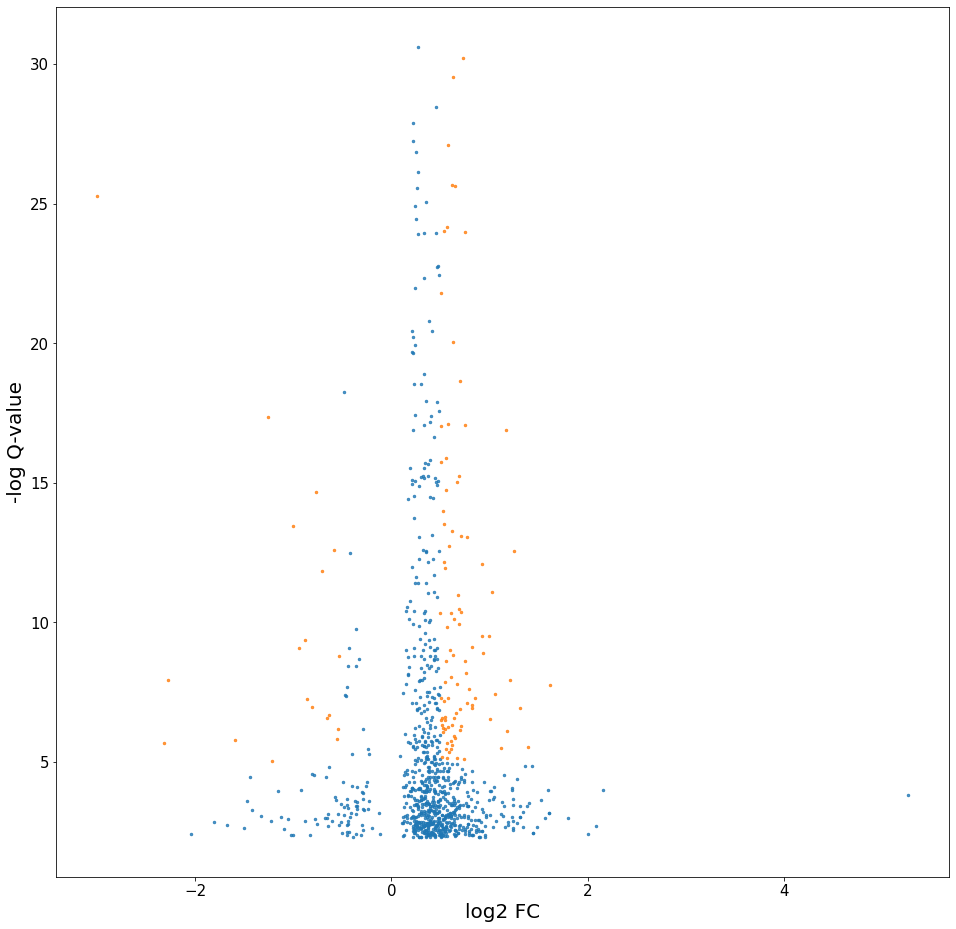

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_Mast_cells_FC+CMP4_vs_CC_DGE_results.csv


Performing DGE testing: Mast cells FC+Nintedanib vs. CC 


filtered out 6139 genes that are detected in less than 5 cells


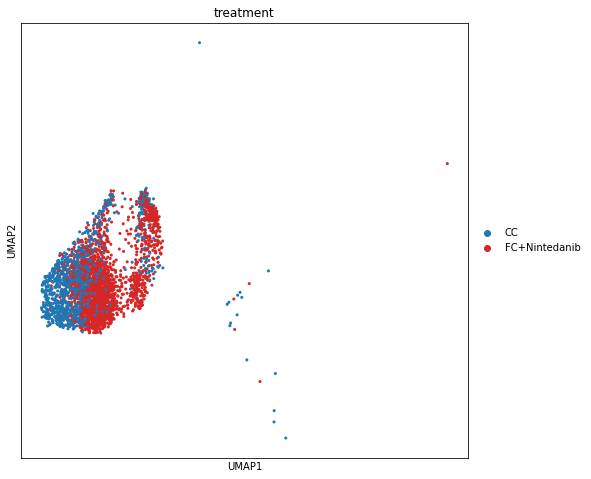

***DGE testing set-up: Mast cells FC+Nintedanib vs. CC***

N cells (total):
3244

N cells (per condition):
FC+Nintedanib    2369
CC                875
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 21:38:24
training location model: True
training scale model: True
iter   0: ll=12246865.355138
caught 256 linalg singular matrix errors
iter   1: ll=10705011.241256, converged: 0.00% (loc: 2.28%, scale update: False), in 3.35sec
iter   2: ll=10267719.219228, converged: 0.00% (loc: 2.28%, scale update: False), in 2.96sec
iter   3: ll=10232694.943500, converged: 0.00% (loc: 2.28%, scale update: False), in 3.23sec
iter   4: ll=10232433.187320, converged: 0.00% (loc: 2.28%, scale update: False), in 3.33sec
iter   5: ll=10232433.062130, converged: 0.00% (loc: 9.40%, scale update: False), in 3.02sec
iter   6: ll=9753788.995098, converged: 0.06% (loc: 0.06%, scale update: True), in 52.63sec
caught 249 linalg singular matrix errors
iter   7: ll=9753256.538499, converged: 0.06

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

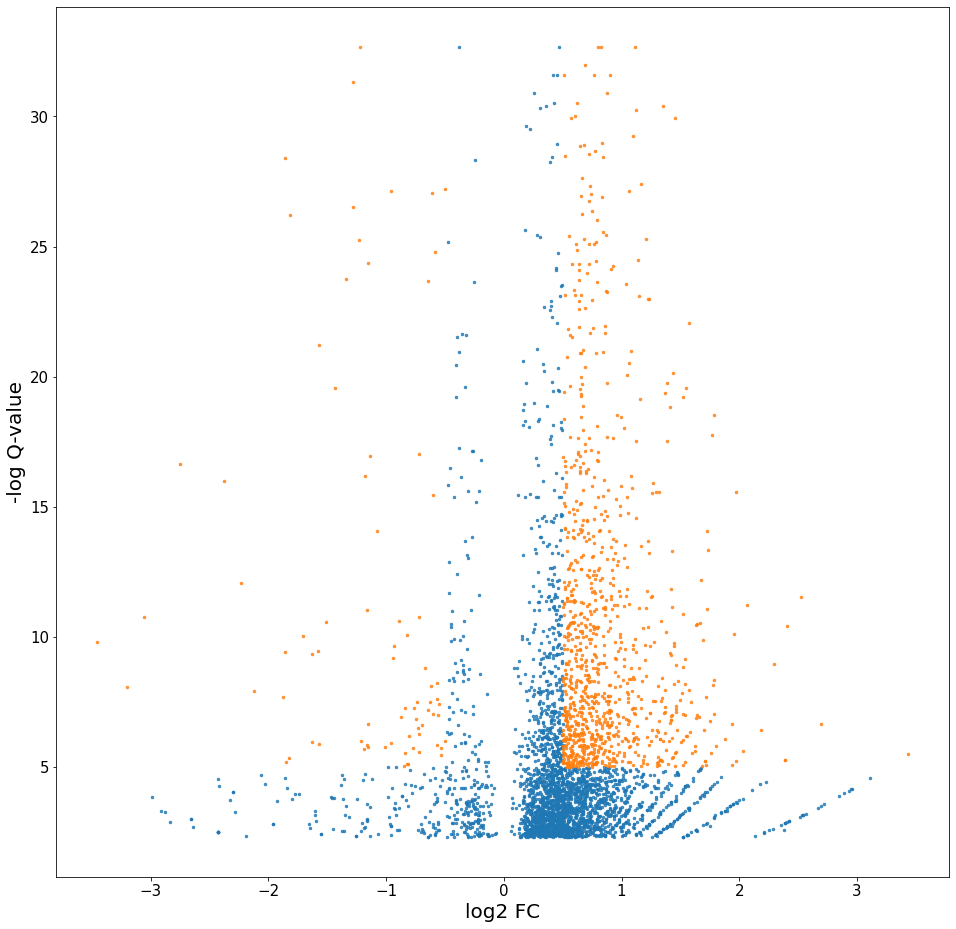

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_Mast_cells_FC+Nintedanib_vs_CC_DGE_results.csv


Performing DGE testing: B cells FC vs. CC 


filtered out 11125 genes that are detected in less than 5 cells


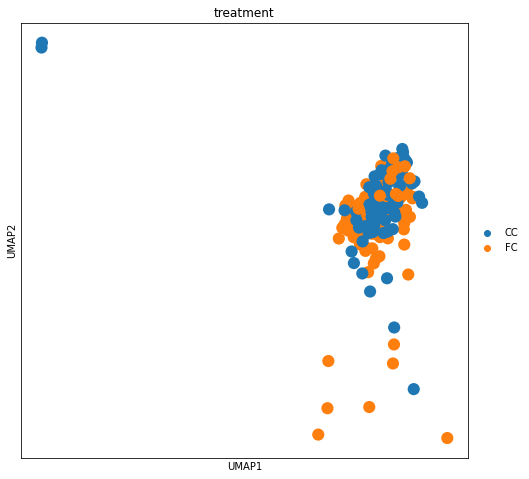

***DGE testing set-up: B cells FC vs. CC***

N cells (total):
203

N cells (per condition):
FC    114
CC     89
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 21:42:23
training location model: True
training scale model: True
iter   0: ll=564842.846182
caught 166 linalg singular matrix errors
iter   1: ll=493941.980244, converged: 0.00% (loc: 2.67%, scale update: False), in 0.65sec
iter   2: ll=470314.687440, converged: 0.00% (loc: 2.67%, scale update: False), in 0.68sec
iter   3: ll=467542.522758, converged: 0.00% (loc: 2.67%, scale update: False), in 0.68sec
iter   4: ll=467485.843950, converged: 0.00% (loc: 2.69%, scale update: False), in 0.79sec
iter   5: ll=467485.666795, converged: 0.00% (loc: 8.30%, scale update: False), in 0.66sec
iter   6: ll=429196.512702, converged: 0.00% (loc: 0.00%, scale update: True), in 8.22sec
caught 166 linalg singular matrix errors
iter   7: ll=429030.554298, converged: 0.00% (loc: 6.51%, scale update: False), in 0.68sec
iter  

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

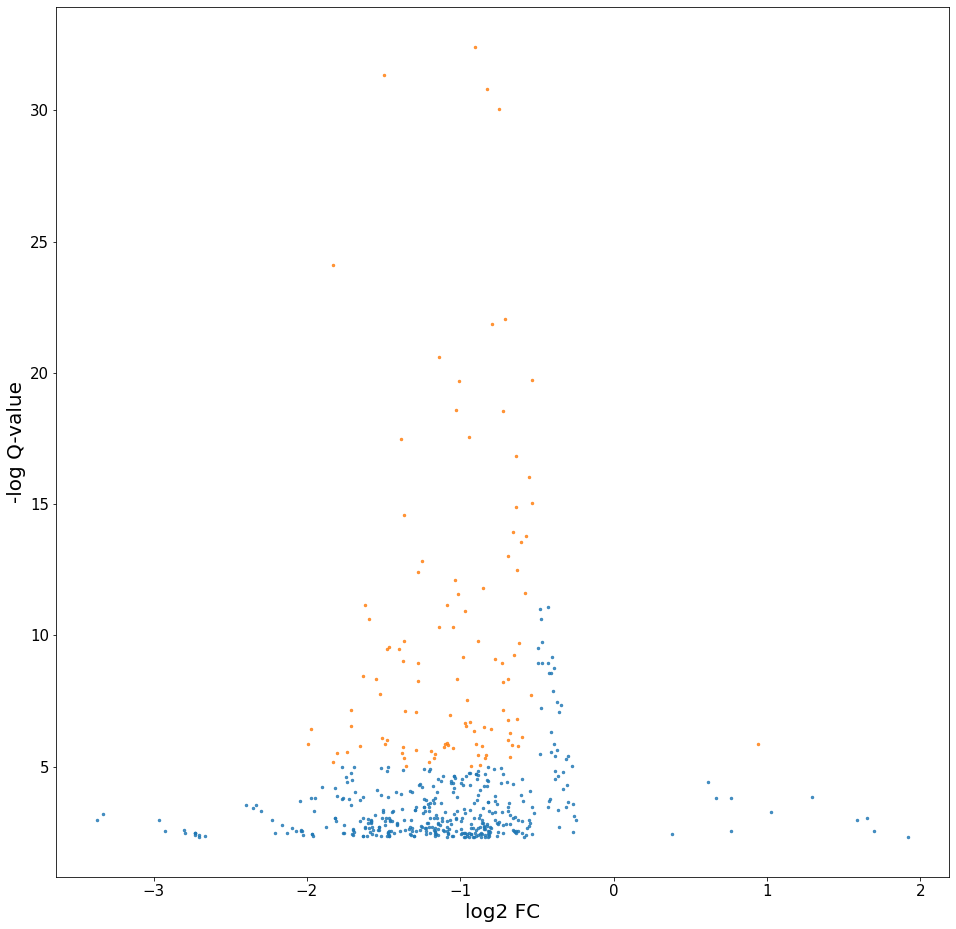

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_B_cells_FC_vs_CC_DGE_results.csv


Performing DGE testing: B cells FC+CMP4 vs. CC 


filtered out 10574 genes that are detected in less than 5 cells


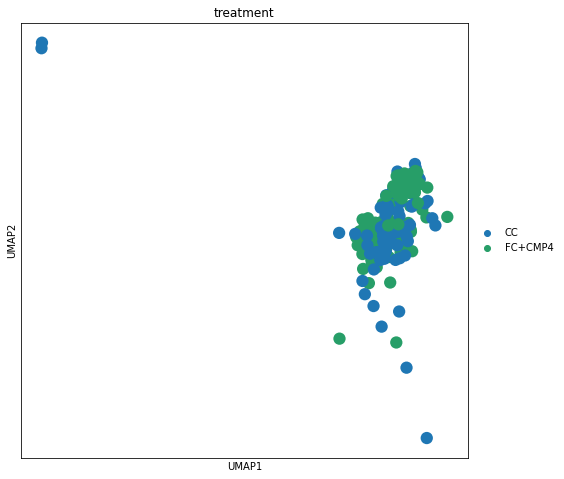

***DGE testing set-up: B cells FC+CMP4 vs. CC***

N cells (total):
199

N cells (per condition):
FC+CMP4    110
CC          89
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 21:43:11
training location model: True
training scale model: True
iter   0: ll=639249.737149
caught 64 linalg singular matrix errors
iter   1: ll=562449.373777, converged: 0.00% (loc: 0.95%, scale update: False), in 0.70sec
iter   2: ll=540994.779987, converged: 0.00% (loc: 0.95%, scale update: False), in 0.85sec
iter   3: ll=539245.176934, converged: 0.00% (loc: 0.95%, scale update: False), in 0.74sec
iter   4: ll=539224.549971, converged: 0.00% (loc: 0.95%, scale update: False), in 0.73sec
iter   5: ll=539224.432593, converged: 0.00% (loc: 12.44%, scale update: False), in 0.71sec
iter   6: ll=501337.149915, converged: 0.00% (loc: 0.00%, scale update: True), in 8.97sec
caught 64 linalg singular matrix errors
iter   7: ll=501162.448487, converged: 0.00% (loc: 5.54%, scale update: False), in 

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

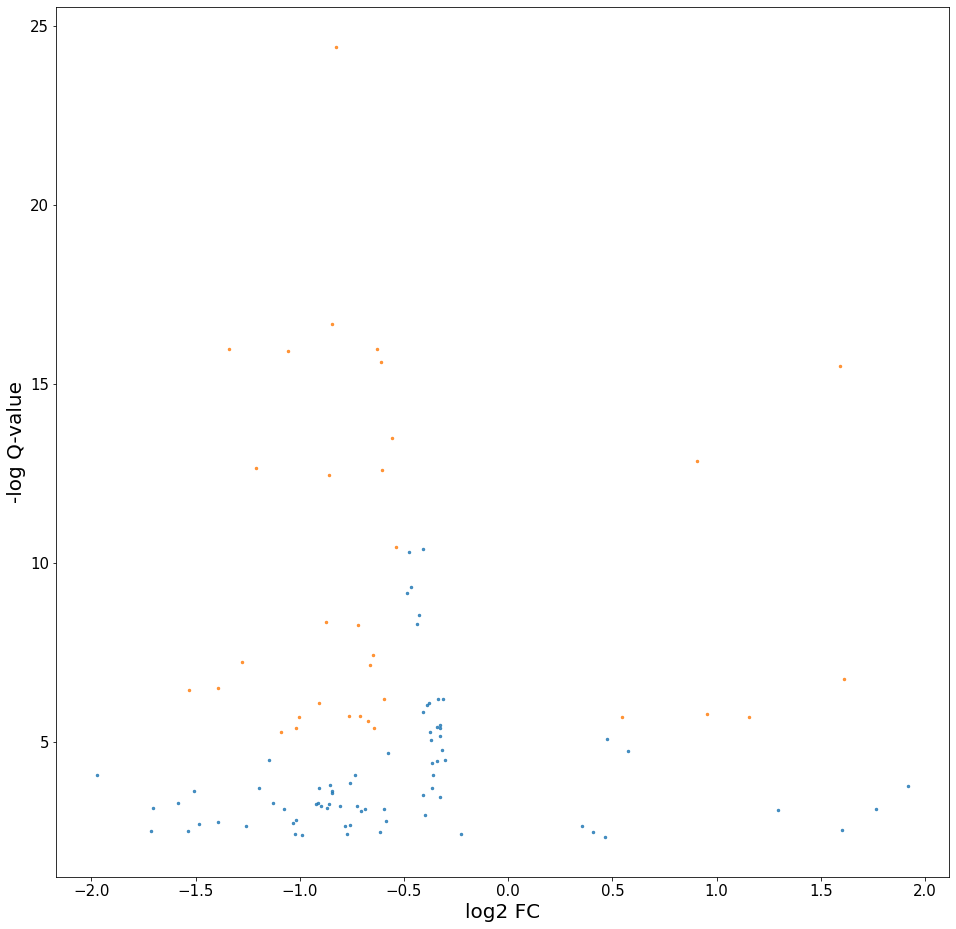

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_B_cells_FC+CMP4_vs_CC_DGE_results.csv


Performing DGE testing: B cells FC+Nintedanib vs. CC 


filtered out 10426 genes that are detected in less than 5 cells


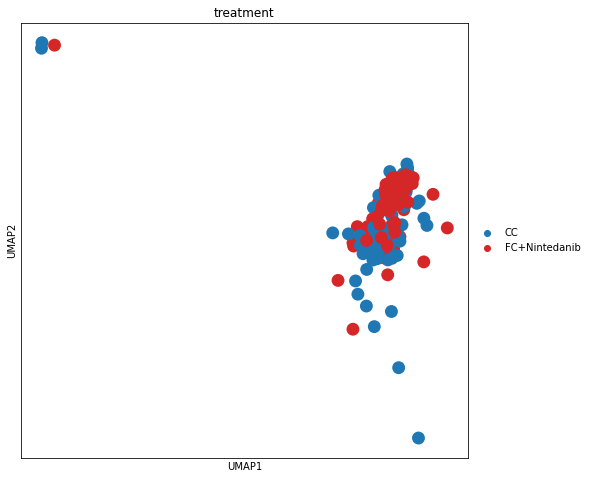

***DGE testing set-up: B cells FC+Nintedanib vs. CC***

N cells (total):
181

N cells (per condition):
FC+Nintedanib    92
CC               89
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 21:44:04
training location model: True
training scale model: True
iter   0: ll=632305.786064
caught 63 linalg singular matrix errors
iter   1: ll=557162.813302, converged: 0.00% (loc: 0.91%, scale update: False), in 0.73sec
iter   2: ll=538018.484099, converged: 0.00% (loc: 0.91%, scale update: False), in 0.89sec
iter   3: ll=536693.990635, converged: 0.00% (loc: 0.91%, scale update: False), in 0.76sec
iter   4: ll=536679.766728, converged: 0.00% (loc: 0.91%, scale update: False), in 0.75sec
iter   5: ll=536679.652146, converged: 0.00% (loc: 20.01%, scale update: False), in 0.88sec
iter   6: ll=499587.065512, converged: 0.00% (loc: 0.00%, scale update: True), in 8.92sec
caught 63 linalg singular matrix errors
iter   7: ll=499465.496519, converged: 0.00% (loc: 5.64%, scale upd

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

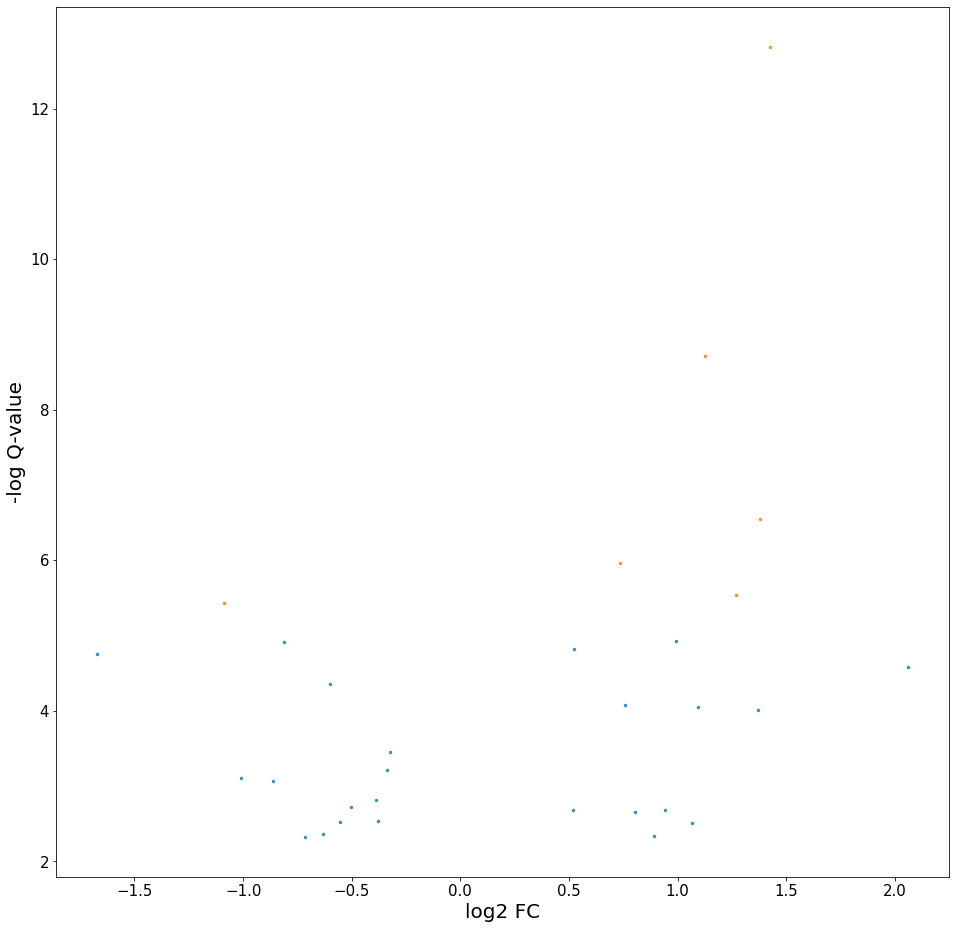

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_B_cells_FC+Nintedanib_vs_CC_DGE_results.csv


Performing DGE testing: Plasma cells FC vs. CC 


filtered out 12963 genes that are detected in less than 5 cells


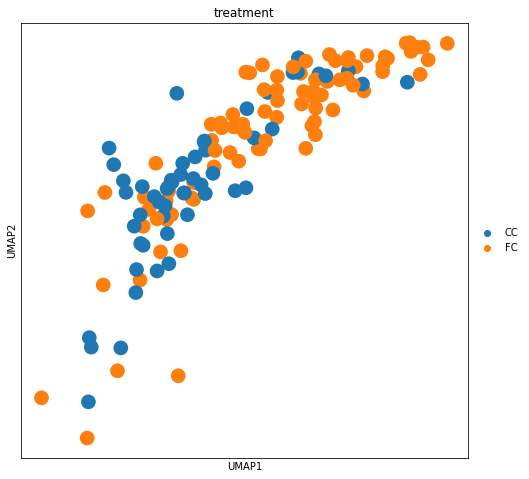

***DGE testing set-up: Plasma cells FC vs. CC***

N cells (total):
139

N cells (per condition):
FC    85
CC    54
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 21:44:56
training location model: True
training scale model: True
iter   0: ll=1407536.364080
caught 311 linalg singular matrix errors
iter   1: ll=1379082.673529, converged: 0.00% (loc: 14.66%, scale update: False), in 0.47sec
iter   2: ll=1370503.387932, converged: 0.00% (loc: 14.66%, scale update: False), in 0.47sec
iter   3: ll=1369415.310227, converged: 0.00% (loc: 14.66%, scale update: False), in 0.48sec
iter   4: ll=1369343.519388, converged: 0.00% (loc: 14.66%, scale update: False), in 0.49sec
iter   5: ll=1369338.776946, converged: 0.00% (loc: 15.00%, scale update: False), in 0.49sec
iter   6: ll=347987.417094, converged: 0.05% (loc: 0.05%, scale update: True), in 4.95sec
caught 305 linalg singular matrix errors
iter   7: ll=345915.711014, converged: 0.05% (loc: 7.83%, scale update: False), in 

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

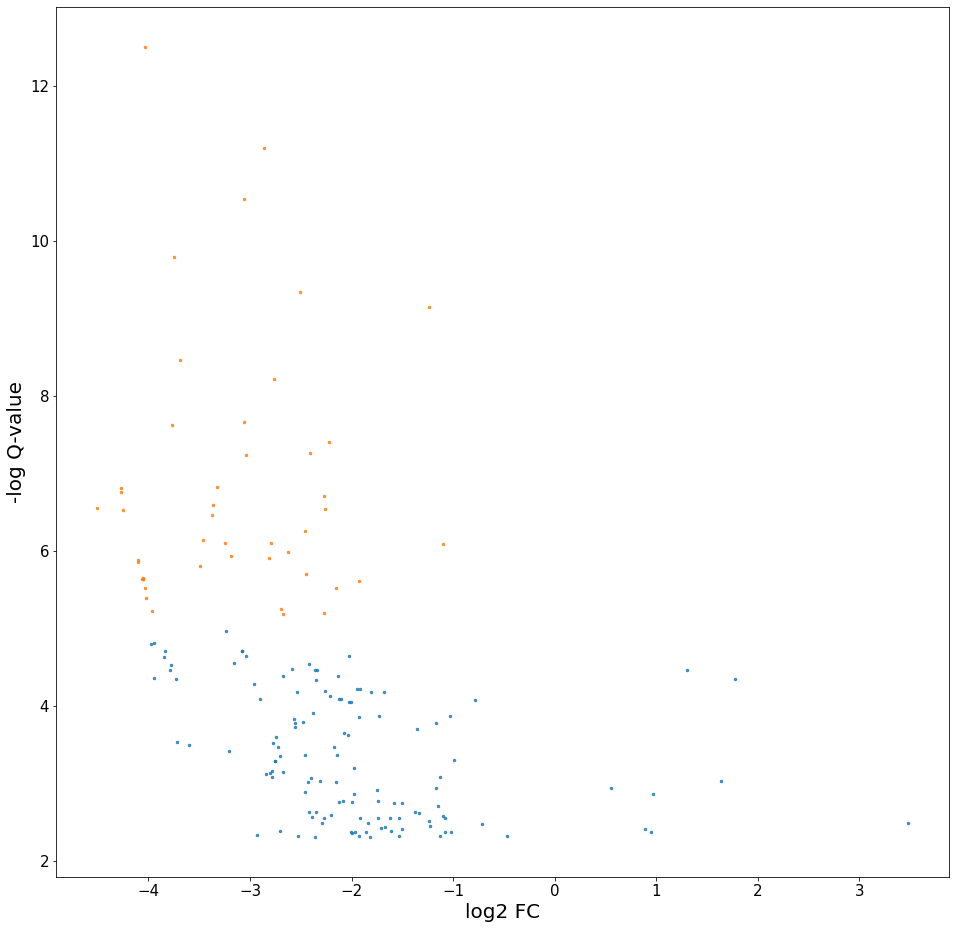

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_Plasma_cells_FC_vs_CC_DGE_results.csv


Performing DGE testing: Plasma cells FC+CMP4 vs. CC 


filtered out 13501 genes that are detected in less than 5 cells


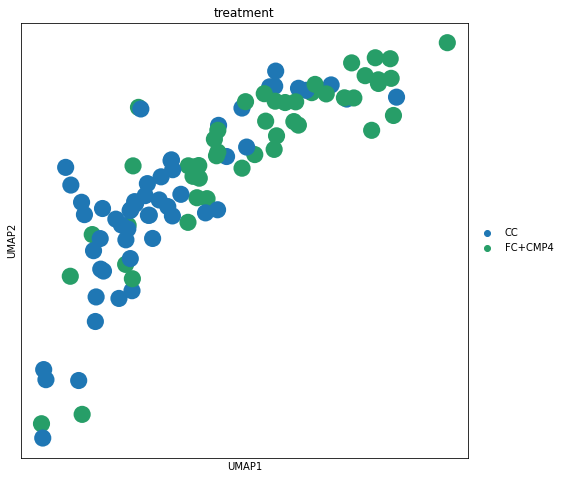

***DGE testing set-up: Plasma cells FC+CMP4 vs. CC***

N cells (total):
102

N cells (per condition):
CC         54
FC+CMP4    48
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 21:46:07
training location model: True
training scale model: True
iter   0: ll=1480389.696269
caught 179 linalg singular matrix errors
iter   1: ll=1460427.575723, converged: 0.00% (loc: 16.37%, scale update: False), in 0.57sec
iter   2: ll=1455034.203457, converged: 0.00% (loc: 16.37%, scale update: False), in 0.42sec
iter   3: ll=1454533.218161, converged: 0.00% (loc: 16.37%, scale update: False), in 0.43sec
iter   4: ll=1454516.836966, converged: 0.00% (loc: 16.37%, scale update: False), in 0.42sec
iter   5: ll=1454516.181843, converged: 0.00% (loc: 18.92%, scale update: False), in 0.43sec
iter   6: ll=277812.902217, converged: 0.00% (loc: 0.00%, scale update: True), in 4.58sec
caught 171 linalg singular matrix errors
iter   7: ll=276736.722073, converged: 0.00% (loc: 7.86%, scale upda

iter  84: ll=197379.779420, converged: 99.97% (loc: 99.97%, scale update: True), in 0.09sec
iter  85: ll=197379.779420, converged: 99.97% (loc: 99.97%, scale update: False), in 0.08sec
iter  86: ll=197379.779420, converged: 99.97% (loc: 100.00%, scale update: False), in 0.08sec
iter  87: ll=197379.779420, converged: 99.97% (loc: 99.97%, scale update: True), in 0.07sec
iter  88: ll=197379.779420, converged: 99.97% (loc: 99.97%, scale update: False), in 0.08sec
iter  89: ll=197379.779420, converged: 99.97% (loc: 100.00%, scale update: False), in 0.08sec
iter  90: ll=197379.779420, converged: 99.97% (loc: 99.97%, scale update: True), in 0.07sec
iter  91: ll=197379.779420, converged: 99.97% (loc: 100.00%, scale update: False), in 0.08sec
iter  92: ll=197379.779420, converged: 99.97% (loc: 99.97%, scale update: True), in 0.07sec
iter  93: ll=197379.779420, converged: 99.97% (loc: 100.00%, scale update: False), in 0.08sec
iter  94: ll=197379.779420, converged: 100.00% (loc: 100.00%, scale up

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

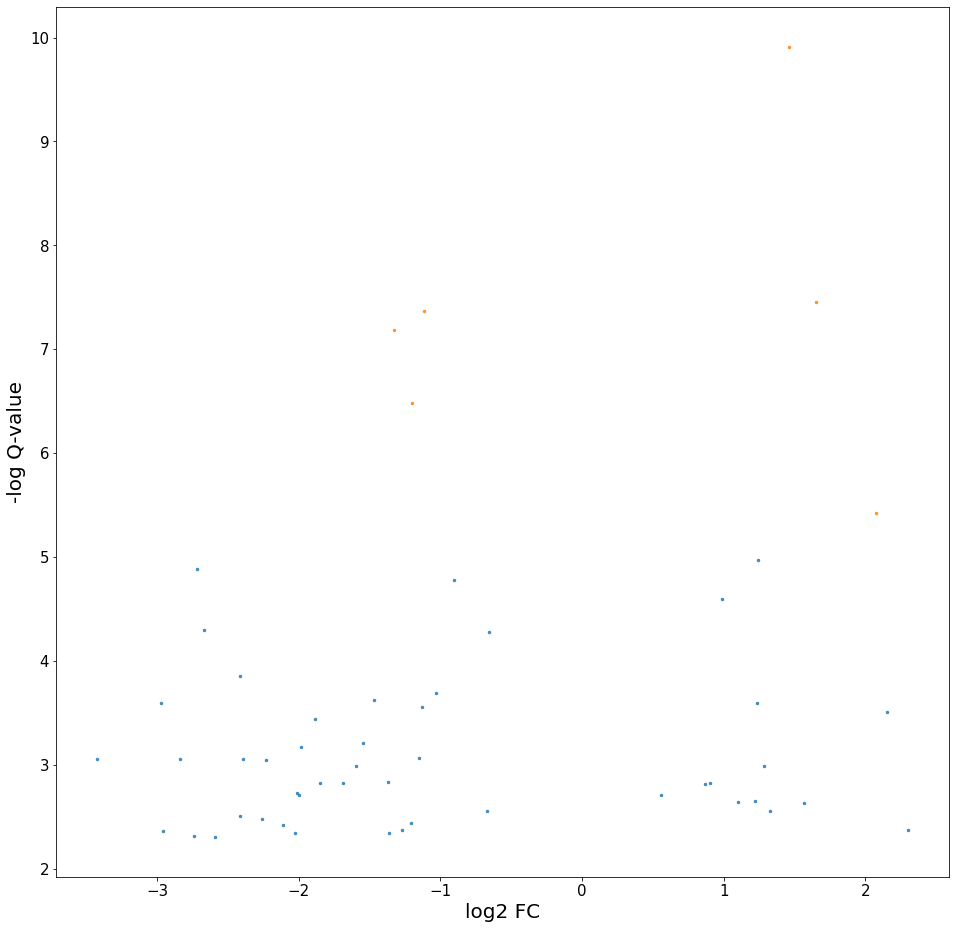

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_Plasma_cells_FC+CMP4_vs_CC_DGE_results.csv


Performing DGE testing: Plasma cells FC+Nintedanib vs. CC 


filtered out 13875 genes that are detected in less than 5 cells


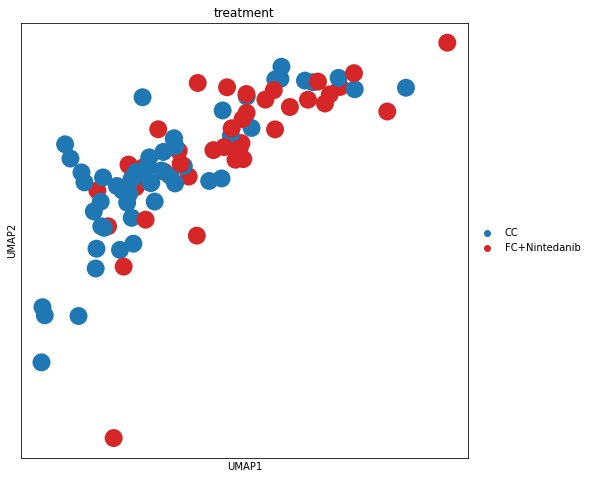

***DGE testing set-up: Plasma cells FC+Nintedanib vs. CC***

N cells (total):
93

N cells (per condition):
CC               54
FC+Nintedanib    39
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 21:47:01
training location model: True
training scale model: True
iter   0: ll=561123.610622
caught 88 linalg singular matrix errors
iter   1: ll=541539.100099, converged: 0.00% (loc: 7.27%, scale update: False), in 0.38sec
iter   2: ll=536162.013393, converged: 0.00% (loc: 7.27%, scale update: False), in 0.41sec
iter   3: ll=535569.377215, converged: 0.00% (loc: 7.27%, scale update: False), in 0.41sec
iter   4: ll=535530.919484, converged: 0.00% (loc: 7.27%, scale update: False), in 0.39sec
iter   5: ll=535527.927708, converged: 0.00% (loc: 7.70%, scale update: False), in 0.39sec
iter   6: ll=196987.207492, converged: 0.03% (loc: 0.03%, scale update: True), in 3.77sec
caught 87 linalg singular matrix errors
iter   7: ll=196113.895510, converged: 0.03% (loc: 3.03%, scale 

iter 172: ll=183002.616183, converged: 99.91% (loc: 99.91%, scale update: True), in 0.09sec
iter 173: ll=183002.616170, converged: 99.91% (loc: 99.91%, scale update: False), in 0.11sec
iter 174: ll=183002.616169, converged: 99.91% (loc: 99.91%, scale update: False), in 0.10sec
iter 175: ll=183002.616169, converged: 99.91% (loc: 100.00%, scale update: False), in 0.10sec
iter 176: ll=183002.616157, converged: 99.91% (loc: 99.91%, scale update: True), in 0.09sec
iter 177: ll=183002.616145, converged: 99.91% (loc: 99.91%, scale update: False), in 0.10sec
iter 178: ll=183002.616145, converged: 99.91% (loc: 99.91%, scale update: False), in 0.11sec
iter 179: ll=183002.616145, converged: 99.91% (loc: 100.00%, scale update: False), in 0.10sec
iter 180: ll=183002.616134, converged: 99.91% (loc: 99.91%, scale update: True), in 0.10sec
iter 181: ll=183002.616124, converged: 99.91% (loc: 99.91%, scale update: False), in 0.10sec
iter 182: ll=183002.616124, converged: 99.91% (loc: 99.94%, scale updat

iter 349: ll=182973.770568, converged: 99.97% (loc: 100.00%, scale update: False), in 0.08sec
iter 350: ll=182973.770568, converged: 99.97% (loc: 99.97%, scale update: True), in 0.07sec
iter 351: ll=182973.770568, converged: 99.97% (loc: 99.97%, scale update: False), in 0.08sec
iter 352: ll=182973.770568, converged: 99.97% (loc: 100.00%, scale update: False), in 0.08sec
iter 353: ll=182973.770568, converged: 99.97% (loc: 99.97%, scale update: True), in 0.07sec
iter 354: ll=182973.770568, converged: 99.97% (loc: 99.97%, scale update: False), in 0.08sec
iter 355: ll=182973.770568, converged: 99.97% (loc: 100.00%, scale update: False), in 0.08sec
iter 356: ll=182973.770568, converged: 99.97% (loc: 99.97%, scale update: True), in 0.07sec
iter 357: ll=182973.770568, converged: 99.97% (loc: 99.97%, scale update: False), in 0.08sec
iter 358: ll=182973.770568, converged: 99.97% (loc: 100.00%, scale update: False), in 0.08sec
iter 359: ll=182973.770568, converged: 99.97% (loc: 99.97%, scale upd

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

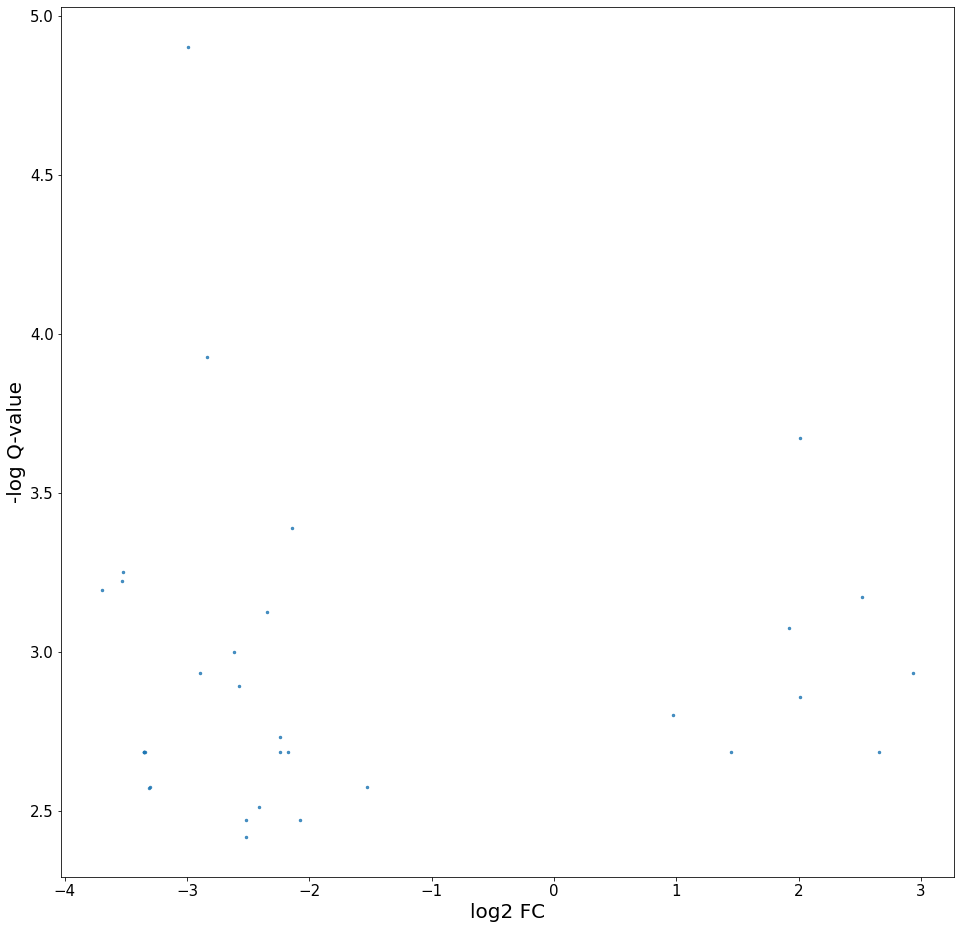

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_Plasma_cells_FC+Nintedanib_vs_CC_DGE_results.csv


Performing DGE testing: T cells FC vs. CC 


filtered out 6515 genes that are detected in less than 5 cells


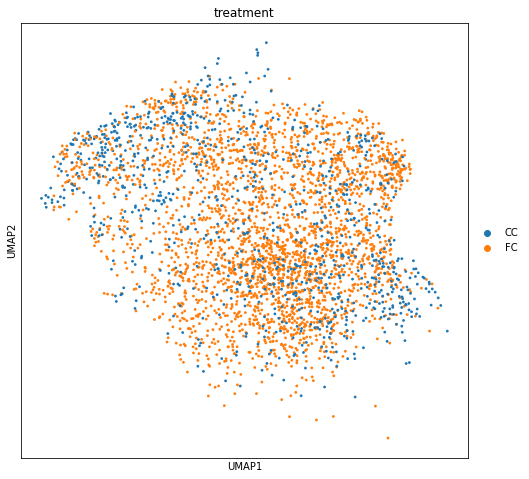

***DGE testing set-up: T cells FC vs. CC***

N cells (total):
3886

N cells (per condition):
FC    2898
CC     988
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 21:48:30
training location model: True
training scale model: True
iter   0: ll=10208837.111700
caught 132 linalg singular matrix errors
iter   1: ll=8893918.988202, converged: 0.00% (loc: 1.23%, scale update: False), in 3.79sec
iter   2: ll=8333885.586632, converged: 0.00% (loc: 1.31%, scale update: False), in 3.33sec
iter   3: ll=8240500.625317, converged: 0.00% (loc: 1.31%, scale update: False), in 3.55sec
iter   4: ll=8237780.886116, converged: 0.00% (loc: 1.31%, scale update: False), in 3.16sec
iter   5: ll=8237777.091973, converged: 0.00% (loc: 1.73%, scale update: False), in 3.52sec
iter   6: ll=7791555.803552, converged: 0.03% (loc: 0.03%, scale update: True), in 58.09sec
caught 129 linalg singular matrix errors
iter   7: ll=7790389.617141, converged: 0.03% (loc: 1.72%, scale update: False), in 3

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

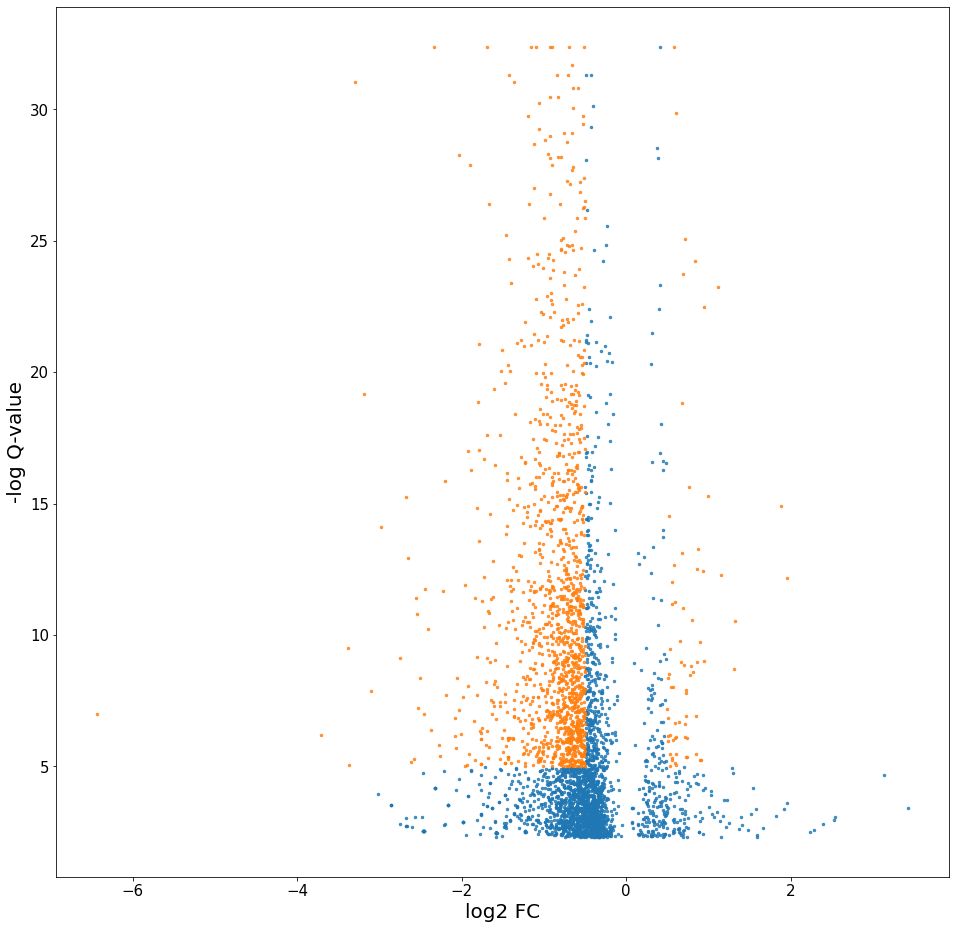

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_T_cells_FC_vs_CC_DGE_results.csv


Performing DGE testing: T cells FC+CMP4 vs. CC 


filtered out 6922 genes that are detected in less than 5 cells


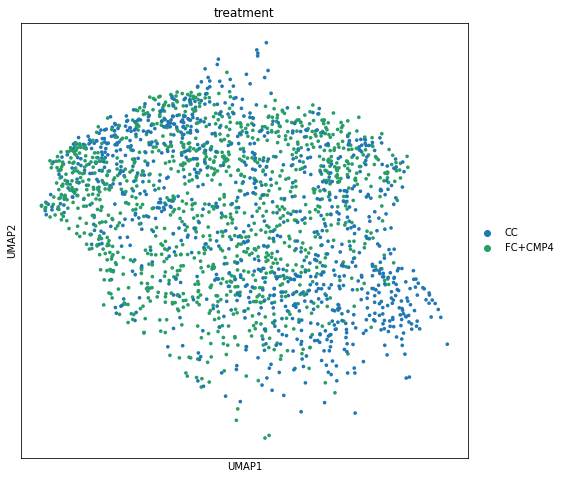

***DGE testing set-up: T cells FC+CMP4 vs. CC***

N cells (total):
2236

N cells (per condition):
FC+CMP4    1248
CC          988
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 21:53:46
training location model: True
training scale model: True
iter   0: ll=6704281.651072
caught 53 linalg singular matrix errors
iter   1: ll=5902854.748005, converged: 0.00% (loc: 0.51%, scale update: False), in 2.37sec
iter   2: ll=5608815.458528, converged: 0.00% (loc: 0.53%, scale update: False), in 2.47sec
iter   3: ll=5571541.293586, converged: 0.00% (loc: 0.53%, scale update: False), in 2.41sec
iter   4: ll=5570842.611146, converged: 0.00% (loc: 0.53%, scale update: False), in 2.52sec
iter   5: ll=5570841.331887, converged: 0.00% (loc: 1.65%, scale update: False), in 2.14sec
iter   6: ll=5291055.169233, converged: 0.01% (loc: 0.01%, scale update: True), in 32.82sec
caught 52 linalg singular matrix errors
iter   7: ll=5290294.180737, converged: 0.01% (loc: 1.32%, scale update: 

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

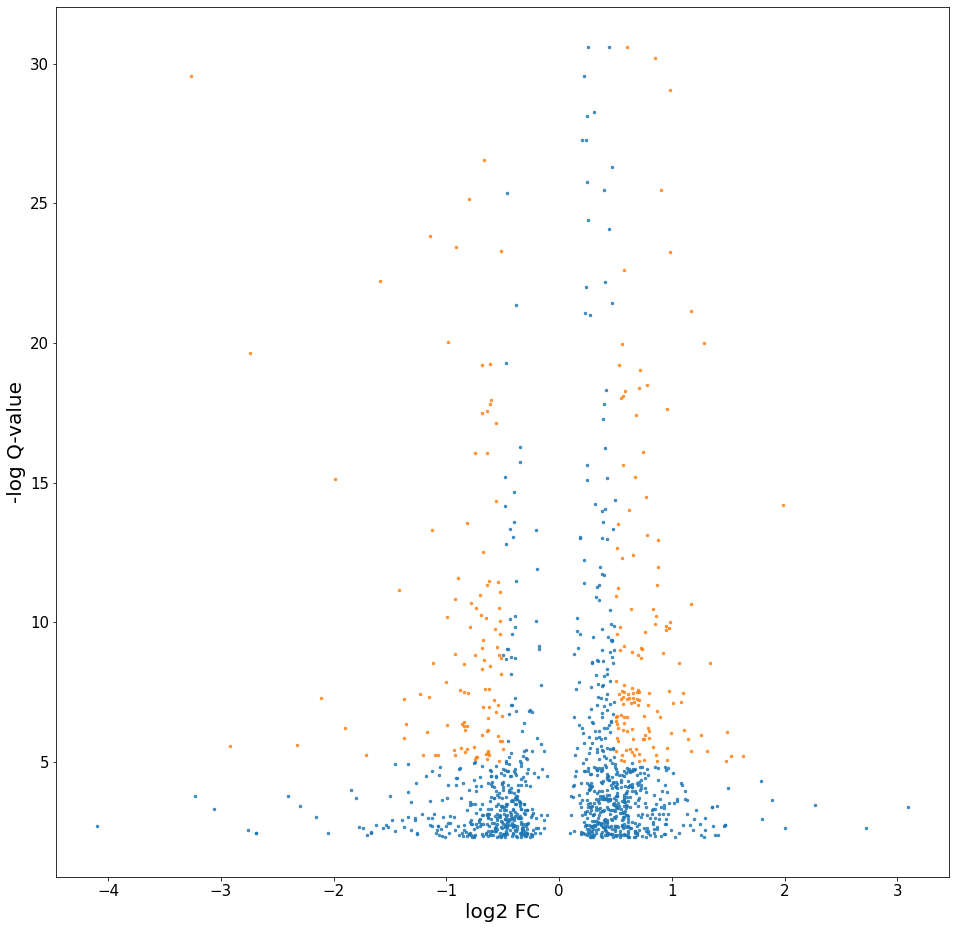

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_T_cells_FC+CMP4_vs_CC_DGE_results.csv


Performing DGE testing: T cells FC+Nintedanib vs. CC 


filtered out 6409 genes that are detected in less than 5 cells


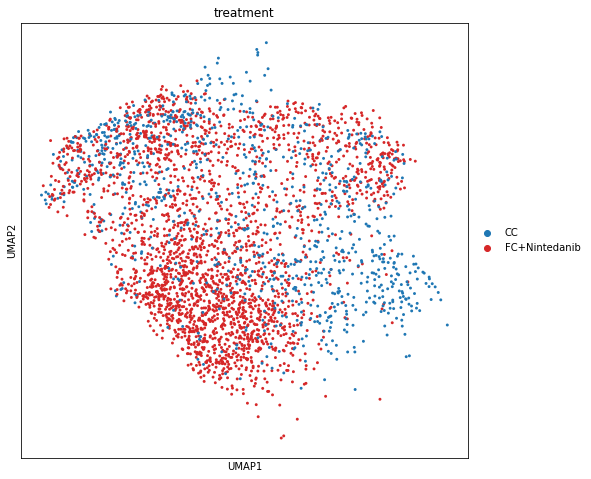

***DGE testing set-up: T cells FC+Nintedanib vs. CC***

N cells (total):
3510

N cells (per condition):
FC+Nintedanib    2522
CC                988
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 21:57:10
training location model: True
training scale model: True
iter   0: ll=11097353.512079
caught 221 linalg singular matrix errors
iter   1: ll=9744453.405426, converged: 0.00% (loc: 2.02%, scale update: False), in 3.41sec
iter   2: ll=9262922.850577, converged: 0.00% (loc: 2.02%, scale update: False), in 2.96sec
iter   3: ll=9205038.066361, converged: 0.00% (loc: 2.02%, scale update: False), in 3.00sec
iter   4: ll=9204066.983061, converged: 0.00% (loc: 2.02%, scale update: False), in 3.35sec
iter   5: ll=9204065.458511, converged: 0.00% (loc: 3.12%, scale update: False), in 3.39sec
iter   6: ll=8792634.473930, converged: 0.04% (loc: 0.04%, scale update: True), in 48.42sec
caught 217 linalg singular matrix errors
iter   7: ll=8792150.693962, converged: 0.04% (loc: 

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

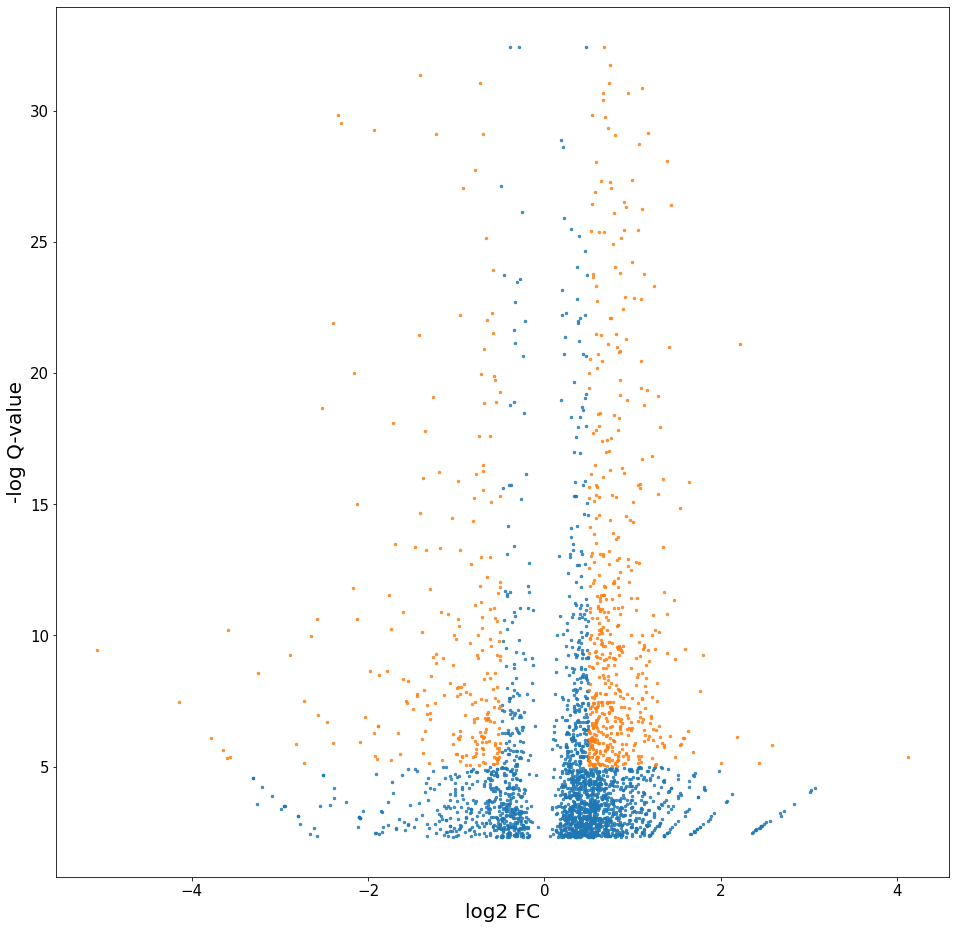

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_T_cells_FC+Nintedanib_vs_CC_DGE_results.csv


Performing DGE testing: NK cells FC vs. CC 


filtered out 8123 genes that are detected in less than 5 cells


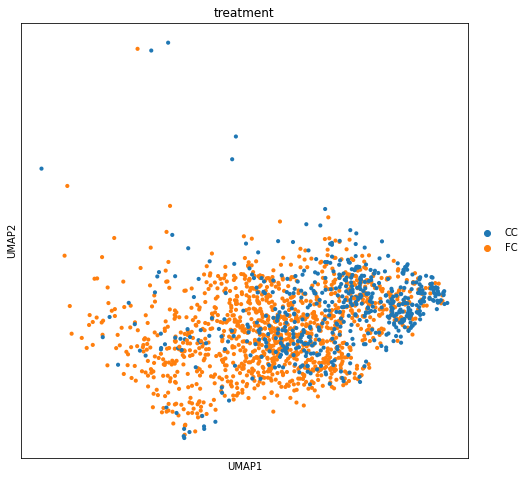

***DGE testing set-up: NK cells FC vs. CC***

N cells (total):
1752

N cells (per condition):
FC    1204
CC     548
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 22:01:31
training location model: True
training scale model: True
iter   0: ll=3456908.143993
caught 165 linalg singular matrix errors
iter   1: ll=2954276.914323, converged: 0.00% (loc: 1.79%, scale update: False), in 2.67sec
iter   2: ll=2674609.777015, converged: 0.00% (loc: 1.79%, scale update: False), in 1.80sec
iter   3: ll=2595717.703743, converged: 0.00% (loc: 1.79%, scale update: False), in 2.11sec
iter   4: ll=2589501.304098, converged: 0.00% (loc: 1.79%, scale update: False), in 1.69sec
iter   5: ll=2589458.288991, converged: 0.00% (loc: 1.80%, scale update: False), in 1.88sec
iter   6: ll=2410796.393238, converged: 0.03% (loc: 0.03%, scale update: True), in 25.97sec
caught 162 linalg singular matrix errors
iter   7: ll=2410537.692263, converged: 0.03% (loc: 5.00%, scale update: False), in 1

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

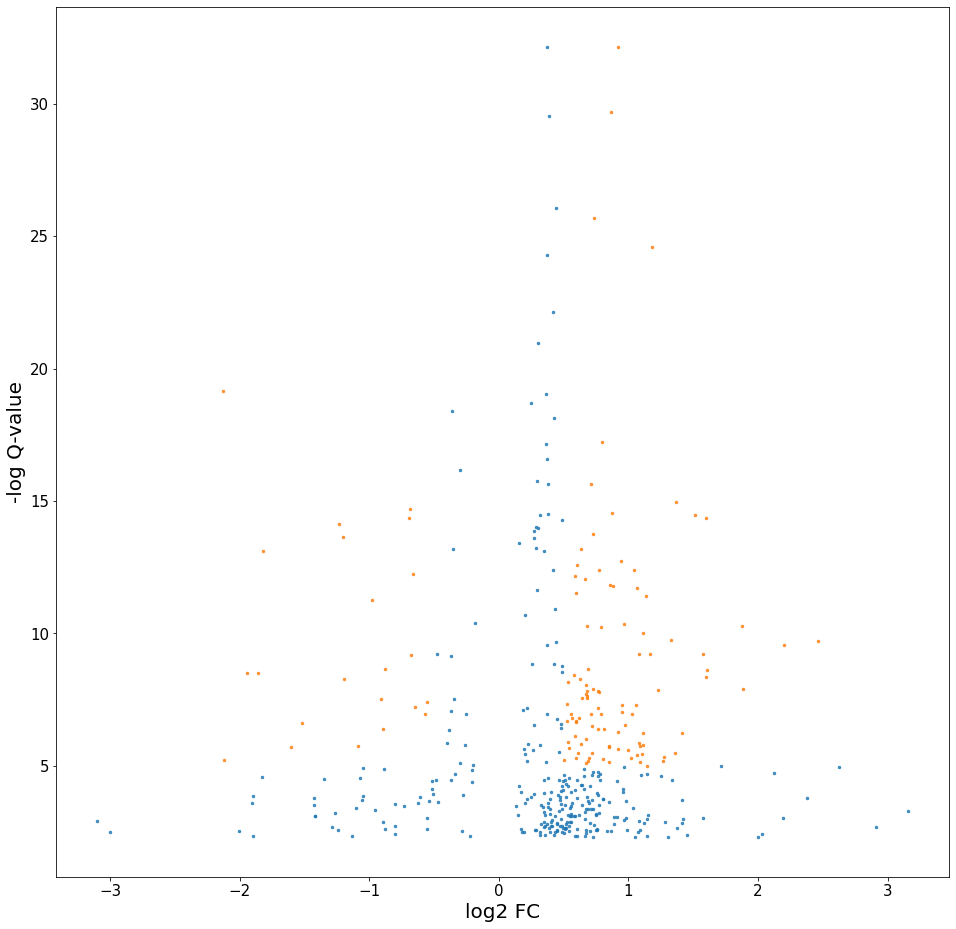

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_NK_cells_FC_vs_CC_DGE_results.csv


Performing DGE testing: NK cells FC+CMP4 vs. CC 


filtered out 8901 genes that are detected in less than 5 cells


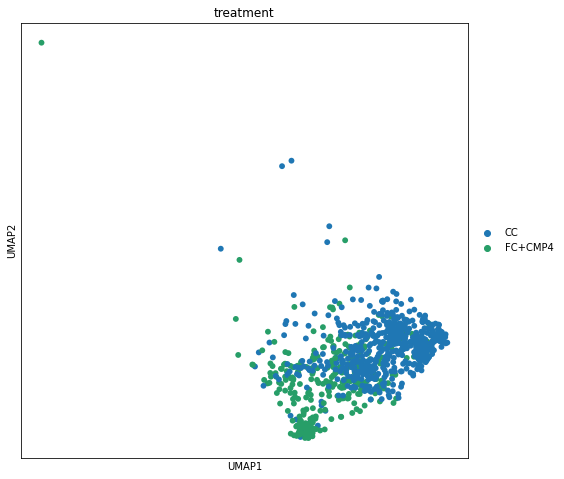

***DGE testing set-up: NK cells FC+CMP4 vs. CC***

N cells (total):
877

N cells (per condition):
CC         548
FC+CMP4    329
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 22:03:37
training location model: True
training scale model: True
iter   0: ll=1871040.387482
caught 125 linalg singular matrix errors
iter   1: ll=1610318.988959, converged: 0.00% (loc: 1.48%, scale update: False), in 0.94sec
iter   2: ll=1473003.074881, converged: 0.00% (loc: 1.48%, scale update: False), in 1.06sec
iter   3: ll=1436987.083923, converged: 0.00% (loc: 1.48%, scale update: False), in 0.93sec
iter   4: ll=1434252.581264, converged: 0.00% (loc: 1.48%, scale update: False), in 0.93sec
iter   5: ll=1434231.282128, converged: 0.00% (loc: 1.54%, scale update: False), in 1.04sec
iter   6: ll=1315423.119203, converged: 0.04% (loc: 0.04%, scale update: True), in 15.57sec
caught 122 linalg singular matrix errors
iter   7: ll=1315197.779128, converged: 0.04% (loc: 5.22%, scale update: 

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

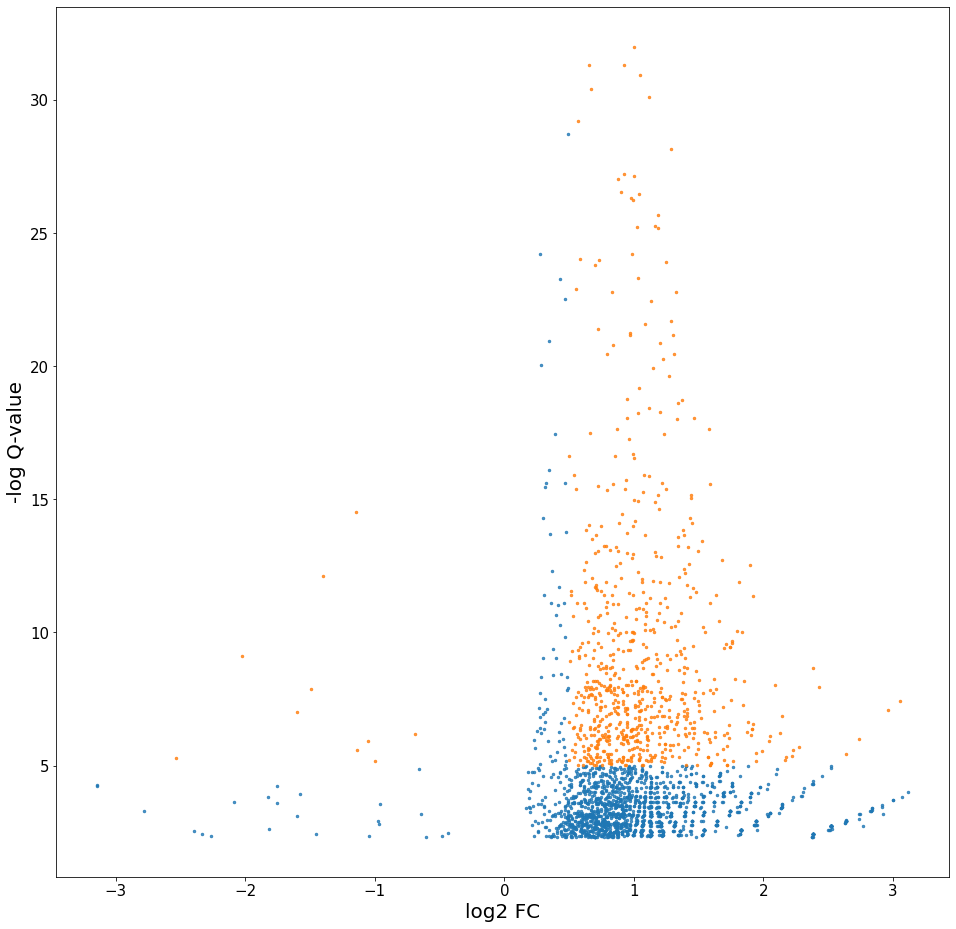

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_NK_cells_FC+CMP4_vs_CC_DGE_results.csv


Performing DGE testing: NK cells FC+Nintedanib vs. CC 


filtered out 7844 genes that are detected in less than 5 cells


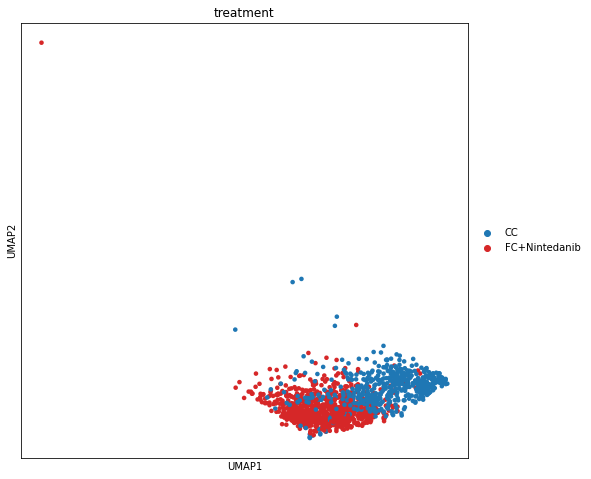

***DGE testing set-up: NK cells FC+Nintedanib vs. CC***

N cells (total):
1439

N cells (per condition):
FC+Nintedanib    891
CC               548
Name: treatment, dtype: int64

Started Diffxpy Calculation:	13-01-2022 22:04:52
training location model: True
training scale model: True
iter   0: ll=3562065.626765
caught 335 linalg singular matrix errors
iter   1: ll=3078769.662242, converged: 0.00% (loc: 3.53%, scale update: False), in 2.16sec
iter   2: ll=2844094.111179, converged: 0.00% (loc: 3.53%, scale update: False), in 1.61sec
iter   3: ll=2790729.051924, converged: 0.00% (loc: 3.53%, scale update: False), in 1.81sec
iter   4: ll=2787402.695584, converged: 0.00% (loc: 3.53%, scale update: False), in 1.59sec
iter   5: ll=2787380.118384, converged: 0.00% (loc: 3.55%, scale update: False), in 1.69sec
iter   6: ll=2574402.608525, converged: 0.14% (loc: 0.14%, scale update: True), in 23.62sec
caught 322 linalg singular matrix errors
iter   7: ll=2574212.641022, converged: 0.14% (loc: 7.

Warning: given your thresholds, more than 50 genes would have to be labeled.

To prevent overcrowding of your plot, make your thresholds stricter.
We will leave out the labels for now.

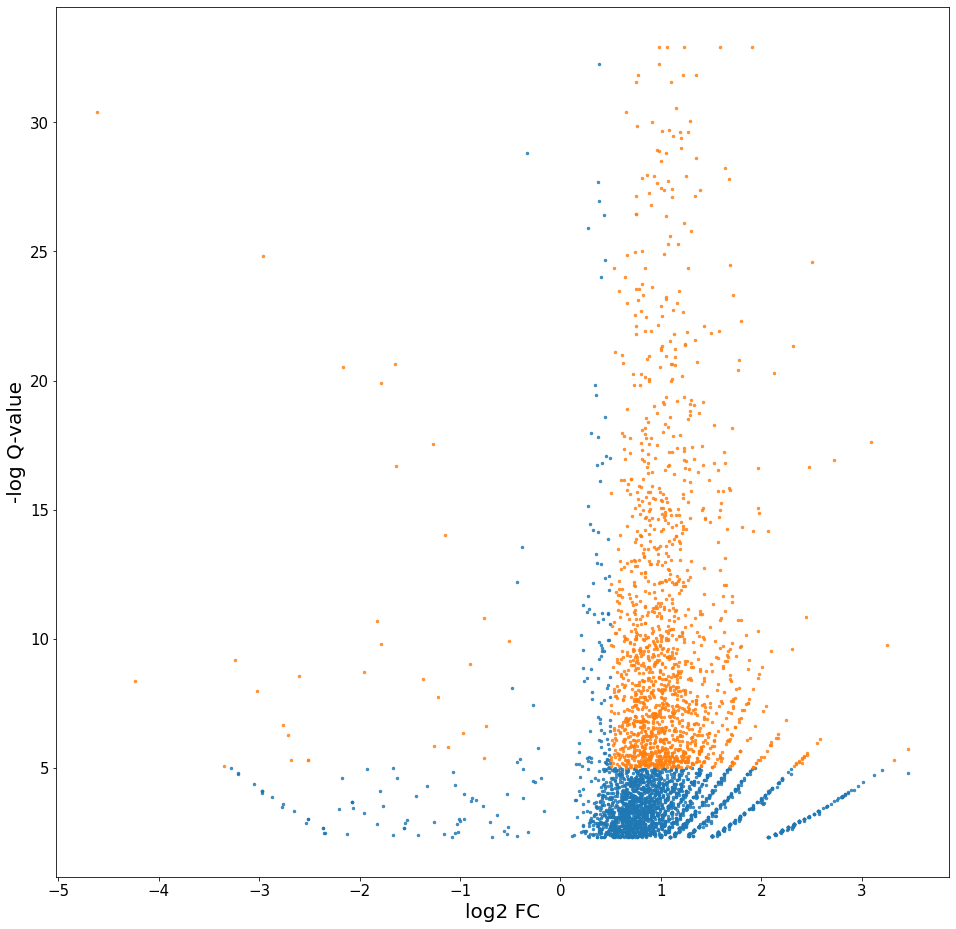

Filtering DGE results table
Saved DGE results to /home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_CC/211206_PCLS_human_ASK_joint_NK_cells_FC+Nintedanib_vs_CC_DGE_results.csv


In [15]:
## iterative DGE testing
for ct in cell_type_names:
    for tg in treatment_groups:
    
        ## step 1: define DGE testing set up
        cell_type = ct # cell type of interest
        condition_label = 'treatment'# meta data variable storing the condition to test
        groups = ['CC',tg]
        print('\n\nPerforming DGE testing: {} {} vs. {} \n\n'.format(cell_type, groups[1],groups[0]))
        
        adata_sub = adata[adata.obs.treatment.isin(['CC',tg])].copy()

        ## step 2: generate count object for DGE testing
        adata_raw = sct.calc.generate_count_object(adata_sub, hue = condition_label,
                                                cell_type_label = 'cell_type_group',
                                                cell_type = [cell_type], ref = 'CC', min_cells = 5,
                                                subset = groups)
        print('***DGE testing set-up: {} {} vs. {}***\n'.format(cell_type, groups[1],groups[0]))
        print('N cells (total):\n{}\n'.format(adata_raw.shape[0]))
        print('N cells (per condition):\n{}\n'.format(adata_raw.obs[condition_label].value_counts()))

        ## step 3: perform DGE testing
        print('Started Diffxpy Calculation:\t%s' %sct.util.timestamp())
        de_test = de.test.wald(data = adata_raw.X,
                               formula_loc = '~ 1 + treatment',
                               factor_loc_totest = 'treatment',
                               gene_names = adata_raw.var_names,
                               sample_description = adata_raw.obs,
                               noise_model = 'nb',
                               size_factors = 'n_counts_scaled')
        
        print('Finished Diffxpy Calculation:\t%s' %sct.util.timestamp())

        ## step 4: generate and filter results
        # create unfiltered results table
        print('Writing DGE results table')
        qval_thresh = 0.1
        result = de_test.summary().sort_values(by=["qval"], ascending=True)
        result = result[result.qval < qval_thresh].loc[:, ].copy()
        dge = sct.calc.add_percentages(adata[adata_raw.obs_names], result, ids=groups, group_by=condition_label)

        # overview volcano plot
        sct.plot.volcano_plot(dge, fdr_thresh = 5, log_fc_thresh = 0.5,
                              adj_p_val = 'qval', log_fc = 'log2fc',
                              gene = 'gene', figsize = (16, 16), save = None)

        # filter DGE table
        print('Filtering DGE results table')
        #dge = dge[dge.qval < 0.05].copy()
        #dge = dge[(dge.log2fc > 0.5) | (dge.log2fc < -0.5)].copy()

        # sort DGE table by logFC
        dge = dge.sort_values('log2fc', ascending = False)

        ## step 5: save results
        ct_label = ct.split()
        s = '_'
        ct_label = s.join(ct_label)
        ct_label = ct_label.replace('/','_')
        ct_label = str(ct_label)
        csv_dir = results_dir + '211206_PCLS_human_ASK_joint_' + ct_label + '_' + tg + '_vs_CC_DGE_results.csv' 
        csv_dir = str(csv_dir)
        dge.to_csv(csv_dir, index = False)
        print('Saved DGE results to', csv_dir)